**Universidad Eafit**
Grupo:
* **Alejandro Ramírez Arango**
* **Maria Margarita Hernández Montoya**
* **David Fernando Restrepo Ramírez**


# REINFORCEMENT LEARNING

El aprendizaje por refuerzo, consiste en determinar cómo los **agentes** interactúan con el **entorno** a través de **acciones** para obtener la máxima **recompensa**

El objetivo es ***aprender*** qué acciones tomar para maximizar la recompensa (Política Óptima $\Pi^*(s)$)

Una representación gráfica de la interacción de estos 4 elementos es la siguiente:


<img src="AA_RLDiagram.png">


In [2]:
import numpy as np
import gym
import time
import pandas as pd
import matplotlib.pyplot as plt

# Descripción del problema

Para la implementar el aprendizaje por refuerzo, se toma los ejemplos clásicos de **GridWord**. En particular se toma el entorno propuesto por Sutton & Barto (2017), que consiste en una malla de 4x12 que tiene la recompensa en la esquina inferior derecha (Ver figura). El juego consiste en que el **robot** aprenda en llegar a la recompensa evitando el risco. Caer en un risco da una recompensa negativa de -100 y devuelve al robot al inicio. Cada paso tomado da una recompensa de -1. Las acciones permitidas son moverse: Arriba, Abajo, Izquierda y Derecha




<img src="AA_CliffGame.png">

> Fuente imagen: Sutton & Barto (2017)


In [3]:
env = gym.make("CliffWalking-v0") #Crea entorno de Cliff Walking
env.reset()
init_state = env.reset() #Lee el estado inicial, cada cuadrícula le corresponde un número

Python a través de la librería **gym** tiene preconstruidos diversos entornos que pueden ser usados para aprendizaje reforzado. También se encuentra incluído el entorno *Cliff Walking* para el desarrollo del caso de estudio elegido. Las siguientes son unas líneas que ayudan a familiarizarse en el manejo de este entorno.

## Entorno

Para este ejemplo el agente (la x) se desplaza arriba, derecha, abajo (cayendo al risco). Nótese que en vez de visualizar el 
agente en el risco este aparece en el punto de inicio. En este punto se ha detectado un posible **bug** de la librería dado
que no aparece ***done=True*** que es lo esperado y descrito en las condiciones de funcionamiento del entorno, porque en este punto se considera que la exploració ha terminado, reinicando el juego, además entrega una falsa señal de estado siguiente. Para solucionar esto se fuerza al algoritmo a cambiar a ***Done = True*** cuando el agente cae al risco.

Otro posible **bug** que se ha detectado en el entorno, es cuando el agente llega a la recompensa, esta devuelve -1, haciendo entender al algoritmo que no hay recompensas en el entorno. Para solucionar lo anterior, se fuerza que la recompensa sea 1 cuando se llega a este estado.

In [4]:
env.reset() #Vuelve el agente al estado inicia
state0 = env.reset() #Lee el estado inicial, cada cuadrícula le corresponde un número
print('estado inicial',state0)  
env.render() #Visualización del entorno

#PRIMER PASO
action = 0  
state2, reward, done, info = env.step(action)
print('info',info)
print('estado 1:',state2)
print('recompensa:',reward)
print('done:',done)
env.render()
#SEGUNDO PASO
action = 1  
state2, reward, done, info = env.step(action)
print('info',info)
print('estado 2:',state2)
print('recompensa:',reward)
print('done:',done)
env.render()
#TERCER PASO
action = 2  
state2, reward, done, info = env.step(action)
print('info',info)
print('estado 3:',state2)
print('recompensa:',reward)
print('done:',done)
env.render()

estado inicial 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

info {'prob': 1.0}
estado 1: 24
recompensa: -1
done: False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

info {'prob': 1.0}
estado 2: 25
recompensa: -1
done: False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

info {'prob': 1.0}
estado 3: 36
recompensa: -100
done: False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



El aprendizaje reforzado se hará bajo el enfoque off-policy, las transiciones se asignarán de manera determinística y estocástica, para ver el efecto en la ejucución del código.

Adicionalmente, el enfoque de aprendizaje será Model Free, dado que solo necesitamos conocer los movimientos legales. Se busca aprender la política sin ningún modelo. Para esto se hará uso de los métodos de Diferencia Temporal Q learning. 

<img src="Qlearning.png">

> Fuente imagen: https://blog.valohai.com/reinforcement-learning-tutorial-part-1-q-learning

## Interacción

El siguiente código crea las interacciones básicas que se tendrán con el entorno:

In [5]:
def action_convert(action):
    if action==0:
        word_action = 'Up'
    elif action==1:
        word_action = 'Right'
    elif action==2:
        word_action = 'Down'
    else:
        word_action = 'Left'
    return word_action

#Decisión del robot. Se toma el enfoque Greedy Search
def choose_action(Q, state, epsilon=0.1):
    #Greedy Search
    action = env.action_space.sample()
    if np.random.uniform(0, 1) < epsilon:
        #Explore
        print('Exploro',Q[state, :])
        action = env.action_space.sample()
    else:
        #Exploit
        print('Exploto',Q[state, :])
        action = np.argmax(Q[state, :])
    return action

#Función de aprendizaje.
def learn(Q, state, state2, reward, action, done, control_policies='Q-Learning'):
    if control_policies=='Q-Learning':
        done = not(done)*1.0
        predict = Q[state, action]
        target = reward + gamma * np.max(Q[state2, :]) * done
        Q[state, action] = Q[state, action] + alpha * (target - predict)
    elif control_policies=='SARSA':
        action2 = choose_action(Q, state2, epsilon)
        done = not(done)*1.0
        predict = Q[state, action]
        target = reward + gamma * Q[state2, action2] * done #done tiene la lógica inversa
        Q[state, action] = Q[state, action] + alpha * (target - predict)
    else:
        pass        
    return Q

#Aprendizaje. Cálculo de la política        
def fit_learn(total_episodes,max_steps, control_policies='Q-Learning'):
    sum_reward = np.zeros((total_episodes))
    episode_steps = np.zeros((total_episodes))
    
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    if(control_policies == 'SARSA'):
        Q[:,1] = 1 #Política por defecto, siempre a la derecha
    for episode in range(total_episodes):
        t = 0
        state = env.reset()
        print('episode',episode+1,'---- estado:', state)
        #Q[state, 2]=-100
        env.render()    
        while t < max_steps:
            action = choose_action(Q, state, epsilon)
            state2, reward, done, info = env.step(action) #ACCIÓN
            if state2 == (env.observation_space.n-1): #Control bug de la recompensa
                reward = 1
            elif reward < control_reward & state2 == init_state: #Control bug del risco por reseteo de posición                     
                done = True
            print('ACCION',action_convert(action),' estado',state,' reward',reward,' done',done)
            Q = learn(Q, state, state2, reward, action, done, control_policies) #APRENDO
            print('Q_después',Q[state])
            state = state2
            sum_reward[episode] += reward
            episode_steps[episode] = t
            t += 1       
            env.render()
            if done:
                env.reset()
                break
    return Q, sum_reward, episode_steps

#Aplica el aprendizaje obtenido.
def play_game(q_values, max_steps, time_visual=0.5):
    t = 0
    env.render()
    state = env.reset()
    done = False    
    while not done:
        #Selecciona acción
        action = choose_action(q_values, state, 0.0)
        #Ejecuta acción
        state2, reward, done, _ = env.step(action)
        # Update state and action        
        state = state2 
        env.render()
        t += 1
        if t > max_steps:
            done = True
            print('GAME OVER')
        elif done:
            print('YOU WIN')
        time.sleep(time_visual)

Los parámetros requeridos para el aprendizaje se controlarán con las siguientes variables. Como primer experimento se hará un aprendizaje pobre y se verificará el desempeño obtenido por el agente:

In [14]:
env = gym.make("CliffWalking-v0")#Las acciones están codificados con: 0(up), 1(right), 2(down), 3(left)
print('Número de estados', env.observation_space.n)
print('Número de acciones', env.action_space.n)    

#Parámetros

control_reward=-50 #Para manejar el bug de Cliff Walking
epsilon = 0.10 #Epsilon Greedy Search

alpha = 0.81 #0.81 #Learning Rate
gamma = 0.96 #0.96 # Discounting rate

total_episodes = 10 #Número de iteraciones
max_steps = 100 #Máximo número de pasos permitidos en cada episodio
control_policies = 'Q-Learning' # Opciones: 'Q-Learning', 'SARSA'

Número de estados 48
Número de acciones 4


In [15]:
# Start    
Q, sum_reward, episode_steps = fit_learn(total_episodes,max_steps,control_policies)

episode 1 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [0. 0. 0. 0.]
ACCION Up  estado 36  reward -1  done False
Q_después [-0.81  0.    0.    0.  ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [0. 0. 0. 0.]
ACCION Up  estado 24  reward -1  done False
Q_después [-0.81  0.    0.    0.  ]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [0. 0. 0. 0.]
ACCION Up  estado 12  reward -1  done False
Q_después [-0.81  0.    0.    0.  ]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [0. 0. 0. 0.]
ACCION Up  estado 0  reward -1  done False
Q_después [-0.81  0.    0.    0.  ]
x  

o  C  C  C  C  C  C  C  C  C  C  T

Exploro [0. 0. 0. 0.]
ACCION Down  estado 26  reward -100  done False
Q_después [  0.   0. -81.   0.]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.81  0.    0.    0.  ]
ACCION Right  estado 36  reward -100  done False
Q_después [ -0.81 -81.     0.     0.  ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -0.81 -81.     0.     0.  ]
ACCION Down  estado 36  reward -1  done False
Q_después [ -0.81 -81.    -0.81   0.  ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -0.81 -81.    -0.81   0.  ]
ACCION Left  estado 36  reward -1  done False
Q_después [ -0.81 -81.    -0.81  -0.81]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  

Exploto [ -0.81        -0.81       -81.77226644  -1.439856  ]
ACCION Up  estado 25  reward -1  done False
Q_después [ -0.9639      -0.81       -81.77226644  -1.439856  ]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.81   -0.81   -0.9639  0.    ]
ACCION Left  estado 13  reward -1  done False
Q_después [-0.81     -0.81     -0.9639   -1.439856]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.9639   -0.81     -1.439856 -0.81    ]
ACCION Right  estado 12  reward -1  done False
Q_después [-0.9639   -1.593756 -1.439856 -0.81    ]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.81     -0.81     -0.9639   -1.439856]
ACCION Up  estado 13  reward -1  done False
Q_después [-1.593756 -0.

ACCION Down  estado 9  reward -1  done False
Q_después [-0.81 -0.81 -0.81  0.  ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [0. 0. 0. 0.]
ACCION Up  estado 21  reward -1  done False
Q_después [-0.81  0.    0.    0.  ]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.81 -0.81 -0.81  0.  ]
ACCION Left  estado 9  reward -1  done False
Q_después [-0.81 -0.81 -0.81 -0.81]
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.81 -0.81  0.    0.  ]
ACCION Down  estado 8  reward -1  done False
Q_después [-0.81 -0.81 -0.81  0.  ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [0. 0. 0. 0.]
A

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -1.74266964  -0.9639     -81.77226644  -1.439856  ]
ACCION Right  estado 25  reward -1  done False
Q_después [ -1.74266964  -1.622997   -81.77226644  -1.439856  ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -0.81        -0.81       -81.          -1.55952864]
ACCION Up  estado 26  reward -1  done False
Q_después [ -1.593756    -0.81       -81.          -1.55952864]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.593756 -1.593756 -0.81     -0.81    ]
ACCION Down  estado 14  reward -1  done False
Q_después [-1.593756 -1.593756 -1.593756 -0.81    ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -1.593756    -0.81       -81.          -

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.593756 -0.81     -0.81     -0.81    ]
ACCION Right  estado 20  reward -1  done False
Q_después [-1.593756 -1.593756 -0.81     -0.81    ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-0.81 -0.81 -0.81 -0.81]
ACCION Up  estado 21  reward -1  done False
Q_después [-1.593756 -0.81     -0.81     -0.81    ]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.593756 -1.593756 -0.81     -0.81    ]
ACCION Down  estado 9  reward -1  done False
Q_después [-1.593756 -1.593756 -1.593756 -0.81    ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-1.593756 -0.81     -0.81     -0.81    ]
ACCION Right  estado 21  rewar

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.593756 -1.593756 -0.81     -0.81    ]
ACCION Down  estado 16  reward -1  done False
Q_después [-1.593756 -1.593756 -1.593756 -0.81    ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -1.593756    -0.81       -83.57438988  -1.58226644]
ACCION Right  estado 28  reward -1  done False
Q_después [ -1.593756    -0.9639     -83.57438988  -1.58226644]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.81 -0.81  0.    0.  ]
ACCION Down  estado 29  reward -100  done False
Q_después [ -0.81        -0.81       -83.85581772   0.        ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C 

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.35211831 -1.74266964 -2.34318402 -2.20320467]
ACCION Right  estado 16  reward -1  done False
Q_después [-2.35211831 -1.89063587 -2.34318402 -2.20320467]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.593756   -1.593756   -0.9639     -2.20320467]
ACCION Down  estado 17  reward -1  done False
Q_después [-1.593756   -1.593756   -1.622997   -2.20320467]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [ -1.593756    -0.81       -83.85581772  -1.55952864]
ACCION Right  estado 29  reward -1  done False
Q_después [ -1.593756    -0.9639     -83.85581772  -1.55952864]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.81 -0.81  0.    0.  ]
ACCIO

Q_después [-3.33350187 -3.10896637 -3.19673353 -3.7959262 ]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.33350187 -3.10896637 -3.19673353 -3.7959262 ]
ACCION Right  estado 12  reward -1  done False
Q_después [-3.33350187 -3.79598679 -3.19673353 -3.7959262 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.08590967 -3.15398996 -3.27057985 -3.08035388]
ACCION Left  estado 13  reward -1  done False
Q_después [-3.08590967 -3.15398996 -3.27057985 -3.88104723]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.33350187 -3.79598679 -3.19673353 -3.7959262 ]
ACCION Down  estado 12  reward -1  done False
Q_después [-3.33350187 -3.79598679 -3.97806817 -3.7959262 ]
o  o  o  o  o  o  o  o  

Q_después [-3.22533003 -2.3804119  -2.35211831 -2.62771099]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.22533003 -2.3804119  -2.35211831 -2.62771099]
ACCION Down  estado 4  reward -1  done False
Q_después [-3.22533003 -2.3804119  -2.97011443 -2.62771099]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.35211831 -2.40852548 -2.34318402 -2.20320467]
ACCION Left  estado 16  reward -1  done False
Q_después [-2.35211831 -2.40852548 -2.34318402 -3.16965956]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.49620714 -2.73243671 -3.17595206 -3.29957065]
ACCION Up  estado 15  reward -1  done False
Q_después [-3.22533003 -2.73243671 -3.17595206 -3.29957065]
o  o  o  x  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -3.79103316  -3.20972339 -81.          -3.77662884]
ACCION Right  estado 26  reward -1  done False
Q_después [ -3.79103316  -3.85968585 -81.          -3.77662884]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -3.72929448  -3.13765228 -83.39960336  -3.77489079]
ACCION Right  estado 27  reward -1  done False
Q_después [ -3.72929448  -3.32520351 -83.39960336  -3.77489079]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -2.46791355  -2.50104679 -83.57438988  -3.1806783 ]
ACCION Up  estado 28  reward -1  done False
Q_después [ -3.10791077  -2.50104679 -83.57438988  -3.1806783 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o 

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-3.11328655 -2.3804119  -2.97011443 -2.5837088 ]
ACCION Up  estado 5  reward -1  done False
Q_después [-3.25253274 -2.3804119  -2.97011443 -2.5837088 ]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.25253274 -2.3804119  -2.97011443 -2.5837088 ]
ACCION Right  estado 5  reward -1  done False
Q_después [-3.25253274 -2.97549021 -2.97011443 -2.5837088 ]
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.35211831 -2.4042053  -2.35211831 -2.20320467]
ACCION Left  estado 6  reward -1  done False
Q_después [-2.35211831 -2.4042053  -2.35211831 -3.23770085]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.252532

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.61632257 -2.97011443 -2.37485611 -2.61003008]
ACCION Down  estado 18  reward -1  done False
Q_después [-2.61632257 -2.97011443 -3.1133961  -2.61003008]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -2.49620714  -2.38191029 -83.89739013  -2.93783154]
ACCION Right  estado 30  reward -1  done False
Q_después [ -2.49620714  -2.5289256  -83.89739013  -2.93783154]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -2.560971    -1.62855279 -82.50652671  -2.93531764]
ACCION Right  estado 31  reward -1  done False
Q_después [ -2.560971    -2.3814675  -82.50652671  -2.93531764]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -1.71342864  -1.62299

Q_después [-2.35211831 -1.74266964 -1.88508008 -2.31899991]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.593756 -1.593756 -0.993141 -1.593756]
ACCION Down  estado 21  reward -1  done False
Q_después [-1.593756   -1.593756   -2.07032449 -1.593756  ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [ -1.593756    -1.37812204 -84.43901077  -2.43867255]
ACCION Left  estado 33  reward -1  done False
Q_después [ -1.593756    -1.37812204 -84.43901077  -2.6057099 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -1.71342864  -2.49220586 -84.08160787  -1.71342864]
ACCION Up  estado 32  reward -1  done False
Q_después [ -2.37485611  -2.49220586 -84.08160787  -1.71342864]
o  o  o  o  o  o  o

o  o  o  o  o  o  o  x  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -3.1652737   -2.59484093 -82.50652671  -2.93531764]
ACCION Right  estado 31  reward -1  done False
Q_después [ -3.1652737   -3.24095905 -82.50652671  -2.93531764]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -2.70938002  -2.49220586 -84.08160787  -3.12696249]
ACCION Right  estado 32  reward -1  done False
Q_después [ -2.70938002  -2.35514681 -84.08160787  -3.12696249]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -1.593756    -1.37812204 -84.43901077  -2.6057099 ]
ACCION Right  estado 33  reward -1  done False
Q_después [ -1.593756    -1.15485798 -84.43901077  -2.6057099 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  C  C  C  C  C  C  C 

In [16]:
#Q-TABLE
print('Q table')
df = pd.DataFrame(Q, columns=['up', 'right', 'down', 'left'])
print(df)

politica = np.max(Q,axis=1).reshape(4,12)
politica_action = np.argmax(Q,axis=1).reshape(4,12)
aux = np.vectorize(action_convert)
politica_action = aux(politica_action)
politica_action = pd.DataFrame(politica_action)
politica = pd.DataFrame(politica)
print('politica tomada directamente de la Q-table')
print(politica)
print('politica convertida en acciones')
print(politica_action)

Q table
          up       right       down      left
0  -5.262978   -4.700285  -5.360725 -5.147691
1  -4.482938   -4.398118  -4.559981 -5.134589
2  -4.482938   -4.488784  -3.905509 -4.848698
3  -4.482938   -4.046895  -4.668898 -3.881035
4  -3.930829   -4.007640  -3.782259 -4.495371
5  -3.252533   -3.818430  -3.778900 -3.344213
6  -3.795926   -3.349899  -3.291355 -3.237701
7  -3.225330   -3.154811  -3.203329 -3.545865
8  -2.496207   -2.728117  -2.380412 -2.438673
9  -2.352118   -2.380412  -2.407470 -2.319000
10 -2.352118   -1.862342  -1.862342 -2.203205
11 -1.742670   -2.352118  -1.622997 -2.352118
12 -5.010642   -5.034817  -5.088032 -5.147691
13 -4.318257   -4.738362  -5.201041 -4.640745
14 -4.529393   -4.786561  -4.500106 -4.382515
15 -4.570542   -4.113643  -4.350796 -4.500587
16 -3.839297   -3.844885  -3.866517 -3.977981
17 -3.714244   -3.427098  -3.203807 -3.864008
18 -3.176611   -3.243011  -3.368038 -3.717615
19 -3.299855   -2.528641  -3.683162 -3.703867
20 -2.352118   -2.403150  

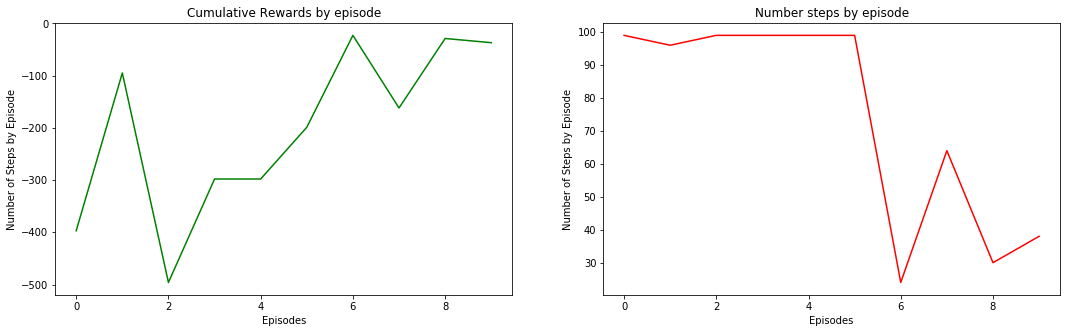

In [17]:
#Gráficas
fig, axs = plt.subplots(1, 2, figsize=(18, 5), sharey=False)
axs[0].plot(sum_reward, color='g')
axs[0].set_xlabel('Episodes')
axs[0].set_ylabel('Number of Steps by Episode')
axs[0].set_title('Cumulative Rewards by episode')
axs[1].plot(episode_steps, color='r')
axs[1].set_xlabel('Episodes')
axs[1].set_ylabel('Number of Steps by Episode')
axs[1].set_title('Number steps by episode')
plt.show()

Es claro que no se entrenó lo suficiente al robot para ganar el juego, esta situación se ve en la política donde se observa que aún no se han revisado todos los estados para aprender la mejor decisión. Sin embargo, se quiere probar lo que este hace con lo aprendido hasta el momento. El juego termina si el robot cae por el risco o supera el número máximo de pasos, en cuyo caso será GAME OVER. Para ganar el robot debe llegar a la recompensa.

Para este caso es muy problame que el juego termine en GAME OVER

In [18]:
max_steps = 30
play_game(Q, max_steps, time_visual=0.2)

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -5.95883659 -104.11076431   -5.84519916   -6.19652388]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -5.95883659 -104.11076431   -5.84519916   -6.19652388]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -5.95883659 -104.11076431   -5.84519916   -6.19652388]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -5.95883659 -104.11076431   -5.84519916   -6.19652388]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -5.95883659 -104.110

Se realiza el mismo ejercio anterior, pero haciendo un mayor número de iteraciones. Se espera encontrar una mejora significativa en la política. El aprendizaje se pondrá a prueba con la misma limitante de pasos del ejercicio anterior (max_steps = 20)

## Q-Learning

In [19]:
env = gym.make("CliffWalking-v0")#Las acciones están codificados con: 0(up), 1(right), 2(down), 3(left)
print('Número de estados', env.observation_space.n)
print('Número de acciones', env.action_space.n)    

#Parámetros

control_reward=-50 #Para manejar el bug de Cliff Walking
epsilon = 0.10 #Epsilon Greedy Search

alpha = 0.81 #0.81 #Learning Rate
gamma = 0.96 #0.96 # Discounting rate

total_episodes = 300 #Número de iteraciones
max_steps = 100 #Máximo número de pasos permitidos en cada episodio
control_policies = 'Q-Learning' # Opciones: 'Q-Learning', 'SARSA'

# Start    
Q, sum_reward, episode_steps = fit_learn(total_episodes,max_steps,control_policies)

Número de estados 48
Número de acciones 4
episode 1 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [0. 0. 0. 0.]
ACCION Up  estado 36  reward -1  done False
Q_después [-0.81  0.    0.    0.  ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [0. 0. 0. 0.]
ACCION Up  estado 24  reward -1  done False
Q_después [-0.81  0.    0.    0.  ]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [0. 0. 0. 0.]
ACCION Left  estado 12  reward -1  done False
Q_después [ 0.    0.    0.   -0.81]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ 0.    0.    0.   -0.81]
ACCION Up  estado 12  rewa

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.593756 -1.593756 -0.9639   -0.81    ]
ACCION Left  estado 11  reward -1  done False
Q_después [-1.593756 -1.593756 -0.9639   -1.593756]
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.593756 -1.593756 -0.81     -0.81    ]
ACCION Down  estado 10  reward -1  done False
Q_después [-1.593756 -1.593756 -0.9639   -0.81    ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.81     -1.439856  0.        0.      ]
ACCION Down  estado 22  reward -1  done False
Q_después [-0.81     -1.439856 -0.81      0.      ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [0. 0. 0. 0.]
ACCION Up  estado 34  reward -1  done Fa

ACCION Right  estado 36  reward -100  done False
Q_después [ -0.81 -81.    -0.81  -0.81]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -0.81 -81.    -0.81  -0.81]
ACCION Up  estado 36  reward -1  done False
Q_después [ -0.9639 -81.      -0.81    -0.81  ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.81  0.    0.    0.  ]
ACCION Right  estado 24  reward -1  done False
Q_después [-0.81 -0.81  0.    0.  ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [0. 0. 0. 0.]
ACCION Up  estado 25  reward -1  done False
Q_después [-0.81  0.    0.    0.  ]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.81   -0.81   -0.9639 -0.81  ]
ACCION Up  estado 1  reward -1  done False
Q_después [-1.593756 -0.81     -0.9639   -0.81    ]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.593756 -0.81     -0.9639   -0.81    ]
ACCION Right  estado 1  reward -1  done False
Q_después [-1.593756 -1.593756 -0.9639   -0.81    ]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.81 -0.81 -0.81 -0.81]
ACCION Up  estado 2  reward -1  done False
Q_después [-1.593756 -0.81     -0.81     -0.81    ]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.593756 -0.81     -0.81     -0.81    ]
ACCION Right  estado 2  reward -1  done Fa

Q_después [-0.9639   -1.593756 -1.593756 -0.81    ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -1.593756    -0.81       -81.77658662  -1.55952864]
ACCION Right  estado 25  reward -1  done False
Q_después [ -1.593756    -0.9639     -81.77658662  -1.55952864]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.81 -0.81  0.    0.  ]
ACCION Down  estado 26  reward -100  done False
Q_después [ -0.81        -0.81       -82.47113525   0.        ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -1.89189204 -81.          -2.35211831  -2.35211831]
ACCION Up  estado 36  reward -1  done False
Q_después [ -2.39982987 -81.          -2.35211831  -2.35211831]
o  o  o  o  o  o  o  o  o  o  o  o
o

Q_después [-2.35211831 -1.593756   -1.593756   -1.593756  ]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.35211831 -1.593756   -1.593756   -1.593756  ]
ACCION Right  estado 4  reward -1  done False
Q_después [-2.35211831 -2.35211831 -1.593756   -1.593756  ]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.593756 -1.593756 -1.593756 -1.593756]
ACCION Up  estado 5  reward -1  done False
Q_después [-2.35211831 -1.593756   -1.593756   -1.593756  ]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-2.35211831 -1.593756   -1.593756   -1.593756  ]
ACCION Up  estado 5  reward -1  done False
Q_después [-2.49620714 -1.593756   -1.593756   -1.593756  ]
o  o  o  o  o  x  o  o  o  o  o  o
o  o

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.593756 -1.593756 -0.9639   -1.439856]
ACCION Down  estado 16  reward -1  done False
Q_después [-1.593756 -1.593756 -1.622997 -1.439856]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -1.71342864  -0.81       -83.39960336  -1.58226644]
ACCION Right  estado 28  reward -1  done False
Q_después [ -1.71342864  -0.9639     -83.39960336  -1.58226644]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.81 -0.81  0.    0.  ]
ACCION Down  estado 29  reward -100  done False
Q_después [ -0.81        -0.81       -83.65117831   0.        ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -3.40943713 -81.          -3.7959262   -3.7959262 ]
ACCION Up  e

o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -2.35211831  -2.38211085 -82.47113525  -2.93783154]
ACCION Up  estado 26  reward -1  done False
Q_después [ -3.12559168  -2.38211085 -82.47113525  -2.93783154]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-3.12559168 -2.4031497  -2.73220195 -2.43867255]
ACCION Up  estado 14  reward -1  done False
Q_después [-3.37013359 -2.4031497  -2.73220195 -2.43867255]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.08590967 -2.52864091 -3.08590967 -3.05386431]
ACCION Right  estado 2  reward -1  done False
Q_después [-3.08590967 -3.11944897 -3.08590967 -3.05386431]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.35211831 -2.47884512 -2.3310589  -3.05255919]
ACCION Down  estado 15  reward -1  done False
Q_después [-2.35211831 -2.47884512 -3.14696685 -3.05255919]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -2.61200239  -2.43578403 -82.94809977  -2.93531764]
ACCION Right  estado 27  reward -1  done False
Q_después [ -2.61200239  -2.60516108 -82.94809977  -2.93531764]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -1.71342864  -1.86895367 -83.39960336  -2.37699327]
ACCION Up  estado 28  reward -1  done False
Q_después [ -2.37485611  -1.86895367 -83.39960336  -2.37699327]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o


o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.35211831 -1.86234228 -2.35211831 -1.593756  ]
ACCION Left  estado 6  reward -1  done False
Q_después [-2.35211831 -1.86234228 -2.35211831 -2.94182083]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-2.49620714 -2.3804119  -2.35211831 -2.94182083]
ACCION Left  estado 5  reward -1  done False
Q_después [-2.49620714 -2.3804119  -2.35211831 -3.42132728]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-3.08590967 -2.63937927 -3.08590967 -2.96382193]
ACCION Left  estado 4  reward -1  done False
Q_después [-3.08590967 -2.63937927 -3.08590967 -3.33185776]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  

ACCION Up  estado 27  reward -1  done False
Q_después [ -3.89243302  -3.15166871 -82.94809977  -4.11141181]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.19795315 -3.74818155 -3.84592338 -3.96556411]
ACCION Up  estado 15  reward -1  done False
Q_después [-3.80866085 -3.74818155 -3.84592338 -3.96556411]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.24733113 -3.11328655 -3.07490966 -3.74363085]
ACCION Down  estado 3  reward -1  done False
Q_después [-3.24733113 -3.11328655 -4.30881881 -3.74363085]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.80866085 -3.74818155 -3.84592338 -3.96556411]
ACCION Right  estado 15  reward -1  done False
Q_después [-3.80866085 -3.90591264 -3.8

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.08734411 -4.55261191 -4.1651233  -4.48293819]
ACCION Up  estado 24  reward -1  done False
Q_después [-4.53830759 -4.55261191 -4.1651233  -4.48293819]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.82324841 -3.86281435 -4.66136529 -3.7959262 ]
ACCION Left  estado 12  reward -1  done False
Q_después [-3.82324841 -3.86281435 -4.66136529 -4.48293819]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.82324841 -3.86281435 -4.66136529 -4.48293819]
ACCION Up  estado 12  reward -1  done False
Q_después [-3.93602056 -3.86281435 -4.66136529 -4.48293819]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.7959262  -3.20764912 -4.2861493  -3.08590

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.19795315 -3.21451109 -3.25218361 -3.69737819]
ACCION Up  estado 16  reward -1  done False
Q_después [-3.81721446 -3.21451109 -3.25218361 -3.69737819]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.08590967 -3.16249035 -3.08590967 -3.33185776]
ACCION Up  estado 4  reward -1  done False
Q_después [-3.7959262  -3.16249035 -3.08590967 -3.33185776]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.7959262  -3.16249035 -3.08590967 -3.33185776]
ACCION Down  estado 4  reward -1  done False
Q_después [-3.7959262  -3.16249035 -3.89592666 -3.33185776]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-3.81721446 -3.21451109 -3.25218361 -3.6973781

o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.93082934 -3.94414912 -4.65803244 -3.89059079]
ACCION Left  estado 1  reward -1  done False
Q_después [-3.93082934 -3.94414912 -4.65803244 -4.50092446]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.48293819 -4.5890885  -4.2861493  -3.7959262 ]
ACCION Left  estado 0  reward -1  done False
Q_después [-4.48293819 -4.5890885  -4.2861493  -4.48293819]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-4.48293819 -4.5890885  -4.2861493  -4.48293819]
ACCION Down  estado 0  reward -1  done False
Q_después [-4.48293819 -4.5890885  -5.1103011  -4.48293819]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  

ACCION Right  estado 27  reward -1  done False
Q_después [ -3.89243302  -4.50029612 -82.94809977  -4.11141181]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [ -3.81233141  -3.81589863 -83.39960336  -4.40616053]
ACCION Right  estado 28  reward -1  done False
Q_después [ -3.81233141  -3.97485915 -83.39960336  -4.40616053]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -3.92562773  -3.13765228 -83.65117831  -3.40731978]
ACCION Right  estado 29  reward -1  done False
Q_después [ -3.92562773  -3.51673114 -83.65117831  -3.40731978]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -3.08590967  -2.71421966 -83.95171221  -3.2213371 ]
ACCION Right  estado 30  reward -1  done False
Q_después [

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.09022985 -3.1052674  -3.5086715  -3.57201505]
ACCION Up  estado 19  reward -1  done False
Q_después [-3.53899451 -3.1052674  -3.5086715  -3.57201505]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.22533003 -2.75443781 -3.08696527 -3.11497901]
ACCION Right  estado 7  reward -1  done False
Q_después [-3.22533003 -3.55286178 -3.08696527 -3.11497901]
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.08590967 -3.09560564 -2.85431918 -3.42075442]
ACCION Down  estado 8  reward -1  done False
Q_después [-3.08590967 -3.09560564 -3.21668967 -3.42075442]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.17595206 -2.39759391 -3.2175105  -3.0576

o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -5.61537398  -5.26110081 -81.77658662  -5.30501947]
ACCION Right  estado 25  reward -1  done False
Q_después [ -5.61537398  -5.38687284 -81.77658662  -5.30501947]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [ -4.60039054  -5.18171046 -82.47113525  -5.23277145]
ACCION Right  estado 26  reward -1  done False
Q_después [ -4.60039054  -5.32494741 -82.47113525  -5.23277145]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -4.54015229  -4.62952517 -82.94809977  -4.93251194]
ACCION Up  estado 27  reward -1  done False
Q_después [ -5.24200848  -4.62952517 -82.94809977  -4.93251194]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C 

o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -4.40942425  -4.72421963 -83.39960336  -5.48269178]
ACCION Up  estado 28  reward -1  done False
Q_después [ -4.75385412  -4.72421963 -83.39960336  -5.48269178]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.99442325 -4.20148385 -4.91133415 -4.54973952]
ACCION Up  estado 16  reward -1  done False
Q_después [-4.65459536 -4.20148385 -4.91133415 -4.54973952]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.48293819 -4.61011269 -4.04982989 -3.96817766]
ACCION Left  estado 4  reward -1  done False
Q_después [-4.48293819 -4.61011269 -4.04982989 -5.1674058 ]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4

ACCION Left  estado 14  reward -1  done False
Q_después [-5.70134119 -5.48970895 -6.28931059 -6.4008922 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.78535548 -5.93515718 -5.83280541 -6.24155724]
ACCION Up  estado 13  reward -1  done False
Q_después [-6.26258665 -5.93515718 -5.83280541 -6.24155724]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.91311662 -5.59846851 -5.94454942 -5.63894579]
ACCION Right  estado 1  reward -1  done False
Q_después [-5.91311662 -5.87655353 -5.94454942 -5.63894579]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.14769099 -5.42534102 -5.43911237 -5.28689232]
ACCION Up  estado 2  reward -1  done False
Q_después [-5.7909058  -5.42534102 -5.439112

ACCION Right  estado 15  reward -1  done False
Q_después [-5.5802863  -5.61331395 -5.31009303 -6.04518492]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.4630438  -4.89266166 -4.91133415 -5.9672479 ]
ACCION Right  estado 16  reward -1  done False
Q_después [-5.4630438  -5.28209897 -4.91133415 -5.9672479 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.23000621 -4.55567548 -4.94200392 -5.18484829]
ACCION Right  estado 17  reward -1  done False
Q_después [-5.23000621 -4.74814565 -4.94200392 -5.18484829]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.54621235 -4.52047244 -4.21857383 -3.95134685]
ACCION Left  estado 18  reward -1  done False
Q_después [-4.54621235 -4.52047244 -

o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -7.05359448 -105.06160734   -7.59818829   -7.59818829]
ACCION Up  estado 36  reward -1  done False
Q_después [  -7.13714983 -105.06160734   -7.59818829   -7.59818829]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.56209602 -6.74327298 -6.66954172 -6.41328046]
ACCION Left  estado 24  reward -1  done False
Q_después [-6.56209602 -6.74327298 -6.66954172 -7.01549017]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.56209602 -6.74327298 -6.66954172 -7.01549017]
ACCION Up  estado 24  reward -1  done False
Q_después [-6.96641111 -6.74327298 -6.66954172 -7.01549017]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Ex

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.41328046 -6.20326301 -6.43592762 -6.5859167 ]
ACCION Right  estado 2  reward -1  done False
Q_después [-6.41328046 -6.423938   -6.43592762 -6.5859167 ]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.93240198 -5.70385549 -6.20565697 -6.37523307]
ACCION Right  estado 3  reward -1  done False
Q_después [-5.93240198 -5.89657706 -6.20565697 -6.37523307]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.14769099 -5.39591278 -5.36998032 -5.1674058 ]
ACCION Up  estado 4  reward -1  done False
Q_después [-5.7909058  -5.39591278 -5.36998032 -5.1674058 ]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.81 -0.81  1.   -0.81]
ACCION Down  estado 35  reward 1  done True
Q_después [-0.81 -0.81  1.   -0.81]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 20 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -7.72178656 -105.06160734   -8.16200699   -8.16200699]
ACCION Up  estado 36  reward -1  done False
Q_después [  -8.02249937 -105.06160734   -8.16200699   -8.16200699]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-7.49230712 -7.38858015 -7.62706064 -7.59818829]
ACCION Right  estado 24  reward -1  done False
Q_después [-7.49230712 -7.58366116 -7.62706064 -7.59818829]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-7.59818829 -7.39517032 -7.04904062 -7.01549017]
ACCION Left  estado 0  reward -1  done False
Q_después [-7.59818829 -7.39517032 -7.04904062 -7.59818829]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-7.59818829 -7.39517032 -7.04904062 -7.59818829]
ACCION Down  estado 0  reward -1  done False
Q_después [-7.59818829 -7.39517032 -7.64965057 -7.59818829]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-7.44580146 -7.07347331 -7.25890205 -7.50505213]
ACCION Right  estado 12  reward -1  done False
Q_después [-7.44580146 -7.56028768 -7.25890205 -7.50505213]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C

ACCION Down  estado 9  reward -1  done False
Q_después [-3.08590967 -3.0166405  -2.9105168  -3.06317187]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.62169835 -2.46791355 -1.99698376 -3.03487828]
ACCION Down  estado 21  reward -1  done False
Q_después [-2.62169835 -2.46791355 -1.99688677 -3.03487828]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [ -2.560971    -1.03840002 -84.32161587  -3.229397  ]
ACCION Down  estado 33  reward -100  done False
Q_después [  -2.560971     -1.03840002 -103.60475406   -3.229397  ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.46662429 -107.30714915   -8.70755796   -8.70755796]
ACCION Up  estado 36  reward -1  done False
Q_después [  -8.5626

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.91311662 -5.40811364 -5.71683002 -6.15883534]
ACCION Right  estado 5  reward -1  done False
Q_después [-5.91311662 -5.74609731 -5.71683002 -6.15883534]
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-5.27399403 -5.02643482 -5.44899183 -5.62362897]
ACCION Right  estado 6  reward -1  done False
Q_después [-5.27399403 -5.16472078 -5.44899183 -5.62362897]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.61347047 -4.37203982 -4.6299797  -5.37147986]
ACCION Right  estado 7  reward -1  done False
Q_después [-4.61347047 -4.53670483 -4.6299797  -5.37147986]
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.91311662 -5.74609731 -5.71683002 -6.15883534]
ACCION Down  estado 5  reward -1  done False
Q_después [-5.91311662 -5.74609731 -6.15697776 -6.15883534]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.56310278 -5.47939822 -5.60232377 -5.61417461]
ACCION Right  estado 17  reward -1  done False
Q_después [-5.56310278 -5.47517841 -5.60232377 -5.61417461]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.3961115  -4.6606131  -4.75167674 -5.25291396]
ACCION Right  estado 18  reward -1  done False
Q_después [-5.3961115  -4.65349296 -4.75167674 -5.25291396]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.99174133 -3.80398209 -3.95993507 -4.

ACCION Right  estado 34  reward -1  done False
Q_después [-1.74266964e+00 -4.00000000e-02 -8.16298560e+01 -2.19643989e+00]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.81 -0.81  1.   -0.81]
ACCION Down  estado 35  reward 1  done True
Q_después [-0.81 -0.81  1.   -0.81]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 30 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -9.1236531  -107.30714915   -9.23543308   -9.23543308]
ACCION Up  estado 36  reward -1  done False
Q_después [  -9.15059701 -107.30714915   -9.23543308   -9.23543308]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  

o  o  o  o  o  o  o  o  x  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -3.66986657   -1.99686401 -103.63138391   -3.67715402]
ACCION Right  estado 32  reward -1  done False
Q_después [  -3.66986657   -1.996864   -103.63138391   -3.67715402]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -2.560971     -1.0384     -103.60475406   -3.229397  ]
ACCION Right  estado 33  reward -1  done False
Q_después [  -2.560971     -1.0384     -103.60475406   -3.229397  ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.74266964e+00 -4.00000000e-02 -1.03631390e+02 -2.19643989e+00]
ACCION Right  estado 34  reward -1  done False
Q_después [-1.74266964e+00 -4.00000000e-02 -1.03631390e+02 -2.19643989e+00]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.74266964e+00 -4.00000000e-02 -1.03631390e+02 -2.19643989e+00]
ACCION Right  estado 34  reward -1  done False
Q_después [-1.74266964e+00 -4.00000000e-02 -1.03631390e+02 -2.19643989e+00]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.81 -0.81  1.   -0.81]
ACCION Down  estado 35  reward 1  done True
Q_después [-0.81 -0.81  1.   -0.81]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 36 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -9.07167539 -107.30714915   -9.23543308   -9.23543308]
ACCION Up  estado 36  reward -1 

Q_después [  -6.0194803    -4.64829747 -103.97820457   -6.09378606]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -5.09238797  -3.80030986 -83.95171221  -4.47462217]
ACCION Right  estado 30  reward -1  done False
Q_después [ -5.09238797  -3.80030986 -83.95171221  -4.47462217]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -3.79857274  -2.91698944 -83.13007977  -3.76731371]
ACCION Right  estado 31  reward -1  done False
Q_después [ -3.79857274  -2.91698944 -83.13007977  -3.76731371]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -3.66986657   -1.996864   -103.63138391   -3.67715402]
ACCION Right  estado 32  reward -1  done False
Q_después [  -3.66986657   -1.996864   -103.631383

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -6.38488789  -5.46236557 -83.39960336  -6.37437328]
ACCION Right  estado 28  reward -1  done False
Q_después [ -6.38488789  -5.46236557 -83.39960336  -6.37437328]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.0194803    -4.64829747 -103.97820457   -6.09378606]
ACCION Right  estado 29  reward -1  done False
Q_después [  -6.0194803    -4.64829747 -103.97820457   -6.09378606]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -5.09238797  -3.80030986 -83.95171221  -4.47462217]
ACCION Right  estado 30  reward -1  done False
Q_después [ -5.09238797  -3.80030986 -83.95171221  -4.47462217]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -9.06954639 -107.30714915   -9.23543308   -9.23543308]
ACCION Up  estado 36  reward -1  done False
Q_después [  -9.06954634 -107.30714915   -9.23543308   -9.23543308]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-8.61991286 -8.40577743 -9.52567292 -8.9859228 ]
ACCION Right  estado 24  reward -1  done False
Q_después [-8.61991286 -8.40577741 -9.52567292 -8.9859228 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.36052363   -7.71435147 -103.59003111   -8.50408651]
ACCION Right  estado 25  reward -1  done False
Q_después [  -8.36052363   -7.71435147 -103.59003111   -8.50408651]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.81 -0.81  1.   -0.81]
ACCION Down  estado 35  reward 1  done True
Q_después [-0.81 -0.81  1.   -0.81]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 48 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -9.06954631 -107.30714915   -9.23543308   -9.23543308]
ACCION Up  estado 36  reward -1  done False
Q_después [  -9.06954631 -107.30714915   -9.23543308   -9.23543308]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-8.61991286 -8.40577741 -9.52567292 -8.9859228 ]
ACCION Right  estado 24  reward -1  done False
Q_después [-

o  o  o  o  o  o  x  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -5.09238797   -3.80030986 -104.00330456   -5.27469432]
ACCION Right  estado 30  reward -1  done False
Q_después [  -5.09238797   -3.80030986 -104.00330456   -5.27469432]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [  -3.79857274   -2.91698944 -107.78344817   -3.76731371]
ACCION Left  estado 31  reward -1  done False
Q_después [  -3.79857274   -2.91698944 -107.78344817   -4.48091055]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -5.09238797   -3.80030986 -104.00330456   -5.27469432]
ACCION Right  estado 30  reward -1  done False
Q_después [  -5.09238797   -3.80030986 -104.00330456   -5.27469432]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -3.79857274   -2.91698944 -107.78344817   -4.48091055]
ACCION Right  estado 31  reward -1  done False
Q_después [  -3.79857274   -2.91698944 -107.78344817   -4.48091055]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -3.77552764   -1.996864   -103.63138391   -3.67715402]
ACCION Right  estado 32  reward -1  done False
Q_después [  -3.77552764   -1.996864   -103.63138391   -3.67715402]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -2.84934594   -1.0384     -103.60475406   -3.229397  ]
ACCION Right  estado 33  reward -1  done False
Q_después [  -2.84934594   -1.0384     -103.60475406   -3.229397  ]
o  o  o  o  o  o  o  o  o  o  o  o

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.95581355e+00 -4.00000000e-02 -1.03631390e+02 -2.19643989e+00]
ACCION Right  estado 34  reward -1  done False
Q_después [-1.95581355e+00 -4.00000000e-02 -1.03631390e+02 -2.19643989e+00]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.81 -0.81  1.   -0.81]
ACCION Down  estado 35  reward 1  done True
Q_después [-0.81 -0.81  1.   -0.81]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 57 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploro [  -9.06954631 -107.30714915   -9.23543308   -9.23543308]
ACCION Left  estado 36  reward -1  done False
Q_después [  -9.06954631 -107.30714915   -9.23543308   -9.6172115 ]
o  o  o  o  o  o  o  o 

ACCION Down  estado 35  reward 1  done True
Q_después [-0.81   -0.1863  1.     -0.81  ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 60 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -9.06954631 -107.30714915   -9.23543308   -9.6172115 ]
ACCION Up  estado 36  reward -1  done False
Q_después [  -9.06954631 -107.30714915   -9.23543308   -9.6172115 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-8.61991286 -8.40577741 -9.52567292 -9.05365784]
ACCION Right  estado 24  reward -1  done False
Q_después [-8.61991286 -8.40577741 -9.52567292 -9.05365784]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C 

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -9.06954631 -107.30714915   -9.23543308   -9.6172115 ]
ACCION Up  estado 36  reward -1  done False
Q_después [  -9.06954631 -107.30714915   -9.23543308   -9.6172115 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-8.61991286 -8.40577741 -9.52567292 -9.05365784]
ACCION Right  estado 24  reward -1  done False
Q_después [-8.61991286 -8.40577741 -9.52567292 -9.05365784]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.36052363   -7.71435146 -103.59003111   -8.96210895]
ACCION Right  estado 25  reward -1  done False
Q_después [  -8.36052363   -7.71435146 -103.59003111   -8.96210895]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  

x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -9.06954631 -107.30714915   -9.23543308   -9.6172115 ]
ACCION Up  estado 36  reward -1  done False
Q_después [  -9.06954631 -107.30714915   -9.23543308   -9.6172115 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-8.61991286 -8.40577741 -9.52567292 -9.05365784]
ACCION Right  estado 24  reward -1  done False
Q_después [-8.61991286 -8.40577741 -9.52567292 -9.05365784]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.36052363   -7.71435146 -103.59003111   -8.96210895]
ACCION Right  estado 25  reward -1  done False
Q_después [  -8.36052363   -7.71435146 -103.59003111   -8.96210895]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -8.0796

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-7.46712485 -7.08200334 -6.92328452 -7.0258716 ]
ACCION Down  estado 3  reward -1  done False
Q_después [-7.46712485 -7.08200334 -7.5624205  -7.0258716 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-7.15853923 -6.99202217 -6.99215357 -7.1413808 ]
ACCION Right  estado 15  reward -1  done False
Q_después [-7.15853923 -6.99656109 -6.99215357 -7.1413808 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.68486167 -6.24752685 -6.38944866 -7.08047914]
ACCION Right  estado 16  reward -1  done False
Q_después [-6.68486167 -6.24526314 -6.38944866 -7.08047914]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.5

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.99044124e+00 -4.00000000e-02 -1.03631390e+02 -2.19643989e+00]
ACCION Right  estado 34  reward -1  done False
Q_después [-1.99044124e+00 -4.00000000e-02 -1.03631390e+02 -2.19643989e+00]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-0.81     -0.067797  1.       -0.81    ]
ACCION Left  estado 35  reward -1  done False
Q_después [-0.81     -0.067797  1.       -0.995004]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.99044124e+00 -4.00000000e-02 -1.03631390e+02 -2.19643989e+00]
ACCION Right  estado 34  reward -1  done False
Q_después [-1.99044124e+00 -4.00000000e-02 -1.03631390e+02 -2.19643989e+00]
o  o  o  o  o  o  o  o  o  o  o  o


o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 75 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -9.06954631 -107.30714915   -9.6172115    -9.6172115 ]
ACCION Up  estado 36  reward -1  done False
Q_después [  -9.06954631 -107.30714915   -9.6172115    -9.6172115 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-8.61991286 -8.40577741 -9.52567292 -9.05365784]
ACCION Right  estado 24  reward -1  done False
Q_después [-8.61991286 -8.40577741 -9.52567292 -9.05365784]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.51229297   -7.71435146 -103.59003111   -8.96210895]
ACCION Right  estado 25  reward -1  done False
Q_después [  -8.5122929

x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-8.61991286 -8.40577741 -9.52567292 -9.0665275 ]
ACCION Right  estado 24  reward -1  done False
Q_después [-8.61991286 -8.40577741 -9.52567292 -9.0665275 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.63985034   -7.71435146 -103.59003111   -9.04913321]
ACCION Right  estado 25  reward -1  done False
Q_después [  -8.63985034   -7.71435146 -103.59003111   -9.04913321]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.17785609   -6.99411611 -107.75965824   -8.17766796]
ACCION Right  estado 26  reward -1  done False
Q_después [  -8.17785609   -6.99411611 -107.75965824   -8.17766796]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  

o  o  o  o  o  o  o  o  o  x  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -2.84934594   -1.0384     -108.52258188   -3.229397  ]
ACCION Right  estado 33  reward -1  done False
Q_después [  -2.84934594   -1.0384     -108.52258188   -3.229397  ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-1.99044124e+00 -4.00000000e-02 -1.03631390e+02 -2.19643989e+00]
ACCION Up  estado 34  reward -1  done False
Q_después [-1.99590527e+00 -4.00000000e-02 -1.03631390e+02 -2.19643989e+00]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.35211831 -1.71342864 -1.03873642 -2.69371045]
ACCION Down  estado 22  reward -1  done False
Q_después [-2.35211831 -1.71342864 -1.03846392 -2.69371045]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [  -8.74579591   -7.71435146 -103.59003111   -9.04913321]
ACCION Left  estado 25  reward -1  done False
Q_después [  -8.74579591   -7.71435146 -103.59003111   -9.06566782]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-8.61991286 -8.40577741 -9.67235706 -9.0665275 ]
ACCION Right  estado 24  reward -1  done False
Q_después [-8.61991286 -8.40577741 -9.67235706 -9.0665275 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.74579591   -7.71435146 -103.59003111   -9.06566782]
ACCION Right  estado 25  reward -1  done False
Q_después [  -8.74579591   -7.71435146 -103.59003111   -9.06566782]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-8.61991286 -8.40577741 -9.67235706 -9.0665275 ]
ACCION Right  estado 24  reward -1  done False
Q_después [-8.61991286 -8.40577741 -9.67235706 -9.0665275 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.74579591   -7.71435146 -107.73458512   -9.06566782]
ACCION Right  estado 25  reward -1  done False
Q_después [  -8.74579591   -7.71435146 -107.73458512   -9.06566782]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.17785609   -6.99411611 -107.75965824   -8.17766796]
ACCION Right  estado 26  reward -1  done False
Q_después [  -8.17785609   -6.99411611 -107.75965824   -8.17766796]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -7.

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.20126626   -4.64829747 -107.80833808   -6.21535482]
ACCION Right  estado 29  reward -1  done False
Q_después [  -6.20126626   -4.64829747 -107.80833808   -6.21535482]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -5.45983431   -3.80030986 -104.00330456   -5.42670803]
ACCION Right  estado 30  reward -1  done False
Q_después [  -5.45983431   -3.80030986 -104.00330456   -5.42670803]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -3.79857274   -2.91698944 -108.53133436   -4.61649395]
ACCION Right  estado 31  reward -1  done False
Q_después [  -3.79857274   -2.91698944 -108.53133436   -4.61649395]
o  o  o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 90 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -9.06954631 -107.30714915   -9.6172115    -9.70615021]
ACCION Up  estado 36  reward -1  done False
Q_después [  -9.06954631 -107.30714915   -9.6172115    -9.70615021]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-8.61991286 -8.40577741 -9.67235706 -9.0665275 ]
ACCION Right  estado 24  reward -1  done False
Q_después [-8.61991286 -8.40577741 -9.67235706 -9.0665275 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.74579591   -7.71435146 -107.73458512   -9.06566782]
ACCION Right  estado 25  reward -1 

ACCION Right  estado 24  reward -1  done False
Q_después [-8.61991286 -8.40577741 -9.67235706 -9.0665275 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.74579591   -7.71435146 -107.73458512   -9.06566782]
ACCION Right  estado 25  reward -1  done False
Q_después [  -8.74579591   -7.71435146 -107.73458512   -9.06566782]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [  -8.17785609   -6.99411611 -108.52681428   -8.17766796]
ACCION Right  estado 26  reward -1  done False
Q_después [  -8.17785609   -6.99411611 -108.52681428   -8.17766796]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -7.67675497   -6.24387095 -108.5308704    -7.52450831]
ACCION Right  estado 27  reward -1  done F

o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -7.70691818   -6.24387095 -108.5308704    -7.52450831]
ACCION Right  estado 27  reward -1  done False
Q_después [  -7.70691818   -6.24387095 -108.5308704    -7.52450831]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [  -6.9726542    -5.46236557 -107.79317594   -6.97174339]
ACCION Left  estado 28  reward -1  done False
Q_después [  -6.9726542    -5.46236557 -107.79317594   -6.98986529]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -7.70691818   -6.24387095 -108.5308704    -7.52450831]
ACCION Right  estado 27  reward -1  done False
Q_después [  -7.70691818   -6.24387095 -108.5308704    -7.52450831]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o


ACCION Right  estado 24  reward -1  done False
Q_después [-8.61991286 -8.40577741 -9.70022705 -9.0665275 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.76592556   -7.71435146 -107.73458512   -9.06566782]
ACCION Right  estado 25  reward -1  done False
Q_después [  -8.76592556   -7.71435146 -107.73458512   -9.06566782]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.17785609   -6.99411611 -108.52681428   -8.39754265]
ACCION Right  estado 26  reward -1  done False
Q_después [  -8.17785609   -6.99411611 -108.52681428   -8.39754265]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -7.70691818   -6.24387095 -108.5308704    -7.52450831]
ACCION Right  estado 27  reward -1  done F

ACCION Right  estado 26  reward -1  done False
Q_después [  -8.17785609   -6.99411611 -108.52681428   -8.39754265]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -7.71288405   -6.24387095 -108.5308704    -7.52450831]
ACCION Right  estado 27  reward -1  done False
Q_después [  -7.71288405   -6.24387095 -108.5308704    -7.52450831]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.99010461   -5.46236557 -107.79317594   -6.98986529]
ACCION Right  estado 28  reward -1  done False
Q_después [  -6.99010461   -5.46236557 -107.79317594   -6.98986529]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.23577715   -4.64829747 -108.53606345   -6.21535482]
ACCION Right  estado 29  reward -1

Q_después [  -2.84934594   -1.0384     -108.67176977   -3.229397  ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-1.99673155e+00 -4.00000000e-02 -1.07742443e+02 -2.03478342e+00]
ACCION Left  estado 34  reward -1  done False
Q_después [-1.99673155e+00 -4.00000000e-02 -1.07742443e+02 -2.00406869e+00]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -2.84934594   -1.0384     -108.67176977   -3.229397  ]
ACCION Right  estado 33  reward -1  done False
Q_después [  -2.84934594   -1.0384     -108.67176977   -3.229397  ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.99673155e+00 -4.00000000e-02 -1.07742443e+02 -2.00406869e+00]
ACCION Right  estado 34  reward -1  done False
Q_después [

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 107 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -9.06954631 -108.44083755   -9.6172115    -9.70664775]
ACCION Up  estado 36  reward -1  done False
Q_después [  -9.06954631 -108.44083755   -9.6172115    -9.70664775]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-8.85025933 -8.40577741 -9.70552235 -9.0665275 ]
ACCION Right  estado 24  reward -1  done False
Q_después [-8.85025933 -8.40577741 -9.70552235 -9.0665275 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.76592556   -7.71435146 -107.73458512   -9.06566782]
ACCION Right  estado 25  reward -1  done False
Q_después [  -8.765925

o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploro [  -9.06954631 -108.44083755   -9.68974939   -9.70664775]
ACCION Right  estado 36  reward -100  done False
Q_después [  -9.06954631 -108.65623834   -9.68974939   -9.70664775]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -9.06954631 -108.65623834   -9.68974939   -9.70664775]
ACCION Up  estado 36  reward -1  done False
Q_después [  -9.06954631 -108.65623834   -9.68974939   -9.70664775]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-8.85025933 -8.40577741 -9.70552235 -9.0665275 ]
ACCION Right  estado 24  reward -1  done False
Q_después [-8.85025933 -8.40577741 -9.70552235 -9.0665275 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.99673155e+00 -4.00000000e-02 -1.07742443e+02 -2.00406869e+00]
ACCION Right  estado 34  reward -1  done False
Q_después [-1.99673155e+00 -4.00000000e-02 -1.07742443e+02 -2.00406869e+00]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.81       -0.04528143  1.         -0.995004  ]
ACCION Down  estado 35  reward 1  done True
Q_después [-0.81       -0.04528143  1.         -0.995004  ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 112 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -9.06954631 -108.65623834   -9.68974939   -9.70664775]
ACCION Up  estado 36  reward -1  done False
Q_después [  -9.06954631 -108.65623834   -9.

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.99010461   -5.46236557 -108.67378391   -6.99330845]
ACCION Right  estado 28  reward -1  done False
Q_después [  -6.99010461   -5.46236557 -108.67378391   -6.99330845]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.23577715   -4.64829747 -108.67433126   -6.21535482]
ACCION Right  estado 29  reward -1  done False
Q_después [  -6.23577715   -4.64829747 -108.67433126   -6.21535482]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -5.46188463   -3.80030986 -104.00330456   -5.42670803]
ACCION Right  estado 30  reward -1  done False
Q_después [  -5.46188463   -3.80030986 -104.00330456   -5.42670803]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-2.62169835 -2.46791355 -1.996864   -3.03487828]
ACCION Up  estado 21  reward -1  done False
Q_después [-3.57542001 -2.46791355 -1.996864   -3.03487828]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.08590967 -3.0166405  -2.91576301 -3.06317187]
ACCION Down  estado 9  reward -1  done False
Q_después [-3.08590967 -3.0166405  -2.91675642 -3.06317187]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.57542001 -2.46791355 -1.996864   -3.03487828]
ACCION Down  estado 21  reward -1  done False
Q_después [-3.57542001 -2.46791355 -1.996864   -3.03487828]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -2.904

o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.33338534   -6.99411611 -108.52681428   -8.39754265]
ACCION Right  estado 26  reward -1  done False
Q_después [  -8.33338534   -6.99411611 -108.52681428   -8.39754265]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -7.71407067   -6.24387095 -108.5308704    -7.52450831]
ACCION Right  estado 27  reward -1  done False
Q_después [  -7.71407067   -6.24387095 -108.5308704    -7.52450831]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.99010461   -5.46236557 -108.67378391   -6.99330845]
ACCION Right  estado 28  reward -1  done False
Q_después [  -6.99010461   -5.46236557 -108.67378391   -6.99330845]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o

Q_después [  -2.90413718   -1.0384     -108.70011547   -2.91913224]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.99684828e+00 -4.00000000e-02 -1.07742443e+02 -2.00406869e+00]
ACCION Right  estado 34  reward -1  done False
Q_después [-1.99684828e+00 -4.00000000e-02 -1.07742443e+02 -2.00406869e+00]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.81       -0.04528143  1.         -1.03015476]
ACCION Down  estado 35  reward 1  done True
Q_después [-0.81       -0.04528143  1.         -1.03015476]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 123 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C 

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.81       -0.04528143  1.         -1.03015476]
ACCION Down  estado 35  reward 1  done True
Q_después [-0.81       -0.04528143  1.         -1.03015476]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 126 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -9.06954631 -108.65623834   -9.68974939   -9.70664775]
ACCION Up  estado 36  reward -1  done False
Q_después [  -9.06954631 -108.65623834   -9.68974939   -9.70664775]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-9.03071685 -8.40577741 -9.70552235 -9.0665275 ]
ACCION Right  estado 24  reward -1  done False
Q_después [-9.03071685 -8.40577741 -9.70552235 -9.0665275 ]
o  o  o 

o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.99010461   -5.46236557 -108.70557386   -6.99330845]
ACCION Right  estado 28  reward -1  done False
Q_después [  -6.99010461   -5.46236557 -108.70557386   -6.99330845]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.23577715   -4.64829747 -108.70060215   -6.21535482]
ACCION Right  estado 29  reward -1  done False
Q_después [  -6.23577715   -4.64829747 -108.70060215   -6.21535482]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -5.46227419   -3.80030986 -104.00330456   -5.42670803]
ACCION Right  estado 30  reward -1  done False
Q_después [  -5.46227419   -3.80030986 -104.00330456   -5.42670803]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.33338534   -6.99411611 -108.67257392   -8.39754265]
ACCION Right  estado 26  reward -1  done False
Q_después [  -8.33338534   -6.99411611 -108.67257392   -8.39754265]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -7.71407067   -6.24387095 -108.5308704    -7.52450831]
ACCION Right  estado 27  reward -1  done False
Q_después [  -7.71407067   -6.24387095 -108.5308704    -7.52450831]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.99010461   -5.46236557 -108.70557386   -6.99330845]
ACCION Right  estado 28  reward -1  done False
Q_después [  -6.99010461   -5.46236557 -108.70557386   -6.99330845]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Q_después [  -7.71407067   -6.24387095 -108.5308704    -7.52450831]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.99010461   -5.46236557 -108.70557386   -6.99330845]
ACCION Right  estado 28  reward -1  done False
Q_después [  -6.99010461   -5.46236557 -108.70557386   -6.99330845]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.23577715   -4.64829747 -108.70060215   -6.21535482]
ACCION Right  estado 29  reward -1  done False
Q_después [  -6.23577715   -4.64829747 -108.70060215   -6.21535482]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -5.46227419   -3.80030986 -104.00330456   -5.42670803]
ACCION Right  estado 30  reward -1  done False
Q_después [  -5.46227419   -3.8003

o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -7.71407067   -6.24387095 -108.5308704    -7.52450831]
ACCION Right  estado 27  reward -1  done False
Q_después [  -7.71407067   -6.24387095 -108.5308704    -7.52450831]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.99010461   -5.46236557 -108.70653824   -6.99330845]
ACCION Right  estado 28  reward -1  done False
Q_después [  -6.99010461   -5.46236557 -108.70653824   -6.99330845]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.23577715   -4.64829747 -108.70060215   -6.21535482]
ACCION Right  estado 29  reward -1  done False
Q_después [  -6.23577715   -4.64829747 -108.70060215   -6.21535482]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.33338534   -6.99411611 -108.70026826   -8.39754265]
ACCION Right  estado 26  reward -1  done False
Q_después [  -8.33338534   -6.99411611 -108.70026826   -8.39754265]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [  -7.71407067   -6.24387095 -108.5308704    -7.52450831]
ACCION Left  estado 27  reward -1  done False
Q_después [  -7.71407067   -6.24387095 -108.5308704    -7.67828127]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.33338534   -6.99411611 -108.70026826   -8.39754265]
ACCION Right  estado 26  reward -1  done False
Q_después [  -8.33338534   -6.99411611 -108.70026826   -8.39754265]
o  o  o  o  o  o  o  o  o  o  o  o


ACCION Right  estado 30  reward -1  done False
Q_después [  -5.46234821   -3.80030986 -104.00330456   -5.42670803]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -3.79857274   -2.91698944 -108.53133436   -4.6422548 ]
ACCION Right  estado 31  reward -1  done False
Q_después [  -3.79857274   -2.91698944 -108.53133436   -4.6422548 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -3.80030373   -1.996864   -107.74244215   -3.79946514]
ACCION Right  estado 32  reward -1  done False
Q_después [  -3.80030373   -1.996864   -107.74244215   -3.79946514]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -2.91454751   -1.0384     -108.70550115   -2.91913224]
ACCION Right  estado 33  reward -1

o  o  o  o  o  o  o  x  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [  -3.79857274   -2.91698944 -108.53133436   -4.6422548 ]
ACCION Up  estado 31  reward -1  done False
Q_después [  -4.48684977   -2.91698944 -108.53133436   -4.6422548 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.99174133 -3.80030986 -3.83063865 -5.28770127]
ACCION Right  estado 19  reward -1  done False
Q_después [-4.99174133 -3.80030986 -3.83063865 -5.28770127]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.17595206 -2.91698944 -3.2175105  -4.54778775]
ACCION Right  estado 20  reward -1  done False
Q_después [-3.17595206 -2.91698944 -3.2175105  -4.54778775]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.99336668   -5.46236557 -108.70672148   -6.99408695]
ACCION Right  estado 28  reward -1  done False
Q_después [  -6.99336668   -5.46236557 -108.70672148   -6.99408695]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [  -6.24233316   -4.64829747 -108.70559362   -6.21535482]
ACCION Left  estado 29  reward -1  done False
Q_después [  -6.24233316   -4.64829747 -108.70559362   -6.23845288]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.99336668   -5.46236557 -108.70672148   -6.99408695]
ACCION Right  estado 28  reward -1  done False
Q_después [  -6.99336668   -5.46236557 -108.70672148   -6.99408695]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o


ACCION Right  estado 24  reward -1  done False
Q_después [-9.56599797 -8.40577741 -9.70552235 -9.06943733]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.76592556   -7.71435146 -108.52205038   -9.06951971]
ACCION Right  estado 25  reward -1  done False
Q_después [  -8.76592556   -7.71435146 -108.52205038   -9.06951971]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.38649638   -6.99411611 -108.70026826   -8.39754265]
ACCION Right  estado 26  reward -1  done False
Q_después [  -8.38649638   -6.99411611 -108.70026826   -8.39754265]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -7.71407067   -6.24387095 -108.5308704    -7.67828127]
ACCION Right  estado 27  reward -1  done F

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -7.7142981    -6.24387095 -108.5308704    -7.67828127]
ACCION Right  estado 27  reward -1  done False
Q_después [  -7.7142981    -6.24387095 -108.5308704    -7.67828127]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.99336668   -5.46236557 -108.70672148   -6.99408695]
ACCION Right  estado 28  reward -1  done False
Q_después [  -6.99336668   -5.46236557 -108.70672148   -6.99408695]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.24233316   -4.64829747 -108.70559362   -6.23845288]
ACCION Right  estado 29  reward -1  done False
Q_después [  -6.24233316   -4.64829747 -108.70559362   -6.23845288]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-0.81       -0.04100347  1.         -1.03015476]
ACCION Left  estado 35  reward -1  done False
Q_después [-0.81       -0.04100347  1.         -1.0368334 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.99684828e+00 -4.00000000e-02 -1.07742443e+02 -1.99823289e+00]
ACCION Right  estado 34  reward -1  done False
Q_después [-1.99684828e+00 -4.00000000e-02 -1.07742443e+02 -1.99823289e+00]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.81       -0.04100347  1.         -1.0368334 ]
ACCION Down  estado 35  reward 1  done True
Q_después [-0.81       -0.04100347  1.         -1.0368334 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-9.56599797 -8.40577741 -9.70552235 -9.06943733]
ACCION Right  estado 24  reward -1  done False
Q_después [-9.56599797 -8.40577741 -9.70552235 -9.06943733]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.76592556   -7.71435146 -108.52205038   -9.06954125]
ACCION Right  estado 25  reward -1  done False
Q_después [  -8.76592556   -7.71435146 -108.52205038   -9.06954125]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.38649638   -6.99411611 -108.70026826   -8.39754265]
ACCION Right  estado 26  reward -1  done False
Q_después [  -8.38649638   -6.99411611 -108.70026826   -8.39754265]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  

o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.99174133 -3.80030986 -3.83063865 -5.28770127]
ACCION Right  estado 19  reward -1  done False
Q_después [-4.99174133 -3.80030986 -3.83063865 -5.28770127]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.17595206 -2.91698944 -3.2175105  -4.54778775]
ACCION Right  estado 20  reward -1  done False
Q_después [-3.17595206 -2.91698944 -3.2175105  -4.54778775]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.57542001 -2.08636521 -1.996864   -3.03487828]
ACCION Down  estado 21  reward -1  done False
Q_después [-3.57542001 -2.08636521 -1.996864   -3.03487828]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  C  C  C  C

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 167 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -9.06954631 -108.65623834   -9.68974939   -9.70664775]
ACCION Up  estado 36  reward -1  done False
Q_después [  -9.06954631 -108.65623834   -9.68974939   -9.70664775]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-9.56599797 -8.40577741 -9.70552235 -9.06943733]
ACCION Right  estado 24  reward -1  done False
Q_después [-9.56599797 -8.40577741 -9.70552235 -9.06943733]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.76592556   -7.71435146 -108.67166878   -9.06954125]
ACCION Right  estado 25  reward -1  done False
Q_después [  -8.765925

ACCION Right  estado 32  reward -1  done False
Q_después [  -3.8003087    -1.996864   -108.52354322   -3.79946514]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -2.91454751   -1.0384     -108.70550115   -2.91739657]
ACCION Right  estado 33  reward -1  done False
Q_después [  -2.91454751   -1.0384     -108.70550115   -2.91739657]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.99684828e+00 -4.00000000e-02 -1.07742443e+02 -1.99823289e+00]
ACCION Right  estado 34  reward -1  done False
Q_después [-1.99684828e+00 -4.00000000e-02 -1.07742443e+02 -1.99823289e+00]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.81       -0.04100347  1.         -1.0368334 ]
ACCION Down  estado 35  re

ACCION Up  estado 36  reward -1  done False
Q_después [  -9.06954631 -108.65623834   -9.68974939   -9.70664775]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-9.63830391 -8.40577741 -9.70652846 -9.06943733]
ACCION Right  estado 24  reward -1  done False
Q_después [-9.63830391 -8.40577741 -9.70652846 -9.06943733]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.76592556   -7.71435146 -108.70009628   -9.06954125]
ACCION Right  estado 25  reward -1  done False
Q_después [  -8.76592556   -7.71435146 -108.70009628   -9.06954125]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.38649638   -6.99411611 -108.70026826   -8.39754265]
ACCION Right  estado 26  reward -1  done False
Q_desp

x  C  C  C  C  C  C  C  C  C  C  T

Exploro [  -9.06954631 -108.65623834   -9.7035316    -9.70676024]
ACCION Down  estado 36  reward -1  done False
Q_después [  -9.06954631 -108.65623834   -9.70615021   -9.70676024]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -9.06954631 -108.65623834   -9.70615021   -9.70676024]
ACCION Up  estado 36  reward -1  done False
Q_después [  -9.06954631 -108.65623834   -9.70615021   -9.70676024]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-9.66710172 -8.40577741 -9.70652846 -9.06943733]
ACCION Right  estado 24  reward -1  done False
Q_después [-9.66710172 -8.40577741 -9.70652846 -9.06943733]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.7659

Q_después [  -6.24357877   -4.64829747 -108.70672219   -6.24284151]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -5.46236227   -3.80030986 -104.00330456   -5.45559064]
ACCION Right  estado 30  reward -1  done False
Q_después [  -5.46236227   -3.80030986 -104.00330456   -5.45559064]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -4.48684977   -2.91698944 -108.70653583   -4.6422548 ]
ACCION Right  estado 31  reward -1  done False
Q_después [  -4.48684977   -2.91698944 -108.70653583   -4.6422548 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -3.8003087    -1.996864   -108.52354322   -3.79946514]
ACCION Right  estado 32  reward -1  done False
Q_después [  -3.8003087    -1.9968

ACCION Right  estado 30  reward -1  done False
Q_después [  -5.46236227   -3.80030986 -104.00330456   -5.45559064]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -4.48684977   -2.91698944 -108.70653583   -4.6422548 ]
ACCION Right  estado 31  reward -1  done False
Q_después [  -4.48684977   -2.91698944 -108.70653583   -4.6422548 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [  -3.80030964   -1.996864   -108.52354322   -3.79946514]
ACCION Left  estado 32  reward -1  done False
Q_después [  -3.80030964   -1.996864   -108.52354322   -3.80014936]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [  -4.48684977   -2.91698944 -108.70653583   -4.6422548 ]
ACCION Left  estado 31  reward -1  

Exploto [  -9.06954631 -108.65623834   -9.70615021   -9.70676024]
ACCION Up  estado 36  reward -1  done False
Q_después [  -9.06954631 -108.65623834   -9.70615021   -9.70676024]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-9.66710172 -8.40577741 -9.70671962 -9.06943733]
ACCION Right  estado 24  reward -1  done False
Q_después [-9.66710172 -8.40577741 -9.70671962 -9.06943733]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.76592556   -7.71435146 -108.7054975    -9.06954125]
ACCION Right  estado 25  reward -1  done False
Q_después [  -8.76592556   -7.71435146 -108.7054975    -9.06954125]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.38649638   -6.99411611 -108.70026826   

o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-9.66710172 -8.40577741 -9.70671962 -9.0695256 ]
ACCION Right  estado 24  reward -1  done False
Q_después [-9.66710172 -8.40577741 -9.70671962 -9.0695256 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.76592556   -7.71435146 -108.7054975    -9.06954125]
ACCION Right  estado 25  reward -1  done False
Q_después [  -8.76592556   -7.71435146 -108.7054975    -9.06954125]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.38649638   -6.99411611 -108.70026826   -8.39754265]
ACCION Right  estado 26  reward -1  done False
Q_después [  -8.38649638   -6.99411611 -108.70026826   -8.39754265]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -5.46236494   -3.80030986 -104.00330456   -5.45559064]
ACCION Right  estado 30  reward -1  done False
Q_después [  -5.46236494   -3.80030986 -104.00330456   -5.45559064]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -4.48684977   -2.91698944 -108.70653583   -4.64714936]
ACCION Right  estado 31  reward -1  done False
Q_después [  -4.48684977   -2.91698944 -108.70653583   -4.64714936]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -3.80030964   -1.996864   -108.67195242   -3.80014936]
ACCION Right  estado 32  reward -1  done False
Q_después [  -3.80030964   -1.996864   -108.67195242   -3.80014936]
o  o  o  o  o  o  o  o  o  o  o  o

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-9.67944146 -8.40577741 -9.70671962 -9.06954238]
ACCION Right  estado 24  reward -1  done False
Q_después [-9.67944146 -8.40577741 -9.70671962 -9.06954238]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.76592556   -7.71435146 -108.7054975    -9.06954125]
ACCION Right  estado 25  reward -1  done False
Q_después [  -8.76592556   -7.71435146 -108.7054975    -9.06954125]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [  -8.38649638   -6.99411611 -108.70026826   -8.39754265]
ACCION Up  estado 26  reward -1  done False
Q_después [  -8.39994798   -6.99411611 -108.70026826   -8.39754265]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-8.26388

ACCION Right  estado 25  reward -1  done False
Q_después [  -8.76592556   -7.71435146 -108.7054975    -9.06954125]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.39994798   -6.99411611 -108.70026826   -8.39754265]
ACCION Right  estado 26  reward -1  done False
Q_después [  -8.39994798   -6.99411611 -108.70026826   -8.39754265]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -7.7142981    -6.24387095 -108.70676288   -7.70749813]
ACCION Right  estado 27  reward -1  done False
Q_después [  -7.7142981    -6.24387095 -108.70676288   -7.70749813]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.99398647   -5.46236557 -108.70676416   -6.99411506]
ACCION Right  estado 28  reward -1

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -5.46236494   -3.80030986 -104.00330456   -5.45559064]
ACCION Right  estado 30  reward -1  done False
Q_después [  -5.46236494   -3.80030986 -104.00330456   -5.45559064]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -4.48684977   -2.91698944 -108.70653583   -4.64714936]
ACCION Right  estado 31  reward -1  done False
Q_después [  -4.48684977   -2.91698944 -108.70653583   -4.64714936]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -3.80030982   -1.996864   -108.67195242   -3.80014936]
ACCION Right  estado 32  reward -1  done False
Q_después [  -3.80030982   -1.996864   -108.67195242   -3.80014936]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploro [  -9.06954631 -108.6971645    -9.70615021   -9.7067643 ]
ACCION Right  estado 36  reward -100  done False
Q_después [  -9.06954631 -108.70494046   -9.70615021   -9.7067643 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -9.06954631 -108.70494046   -9.70615021   -9.7067643 ]
ACCION Up  estado 36  reward -1  done False
Q_después [  -9.06954631 -108.70494046   -9.70615021   -9.7067643 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-9.6859523  -8.40577741 -9.70671962 -9.06954238]
ACCION Right  estado 24  reward -1  done False
Q_después [-9.6859523  -8.40577741 -9.70671962 -9.06954238]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.24357877   -4.64829747 -108.70672219   -6.24284151]
ACCION Right  estado 29  reward -1  done False
Q_después [  -6.24357877   -4.64829747 -108.70672219   -6.24284151]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -5.46236494   -3.80030986 -104.00330456   -5.45559064]
ACCION Right  estado 30  reward -1  done False
Q_después [  -5.46236494   -3.80030986 -104.00330456   -5.45559064]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [  -4.48684977   -2.91698944 -108.70653583   -4.64714936]
ACCION Right  estado 31  reward -1  done False
Q_después [  -4.48684977   -2.91698944 -108.70653583   -4.64714936]
o  o  o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.99686356e+00 -4.00000000e-02 -1.07742443e+02 -1.99823289e+00]
ACCION Right  estado 34  reward -1  done False
Q_después [-1.99686356e+00 -4.00000000e-02 -1.07742443e+02 -1.99823289e+00]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.71342864 -0.04100347  1.         -1.03810235]
ACCION Down  estado 35  reward 1  done True
Q_después [-1.71342864 -0.04100347  1.         -1.03810235]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 209 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -9.06954631 -108.70494046   -9.7061502

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.24357877   -4.64829747 -108.70672219   -6.24284151]
ACCION Right  estado 29  reward -1  done False
Q_después [  -6.24357877   -4.64829747 -108.70672219   -6.24284151]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -5.46236494   -3.80030986 -104.00330456   -5.45559064]
ACCION Right  estado 30  reward -1  done False
Q_después [  -5.46236494   -3.80030986 -104.00330456   -5.45559064]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -4.48684977   -2.91698944 -108.70653583   -4.64714936]
ACCION Right  estado 31  reward -1  done False
Q_después [  -4.48684977   -2.91698944 -108.70653583   -4.64714936]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Q_después [-1.71342864 -0.04100347  1.         -1.03810235]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 216 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -9.06954631 -108.7064179    -9.70615021   -9.70676443]
ACCION Up  estado 36  reward -1  done False
Q_después [  -9.06954631 -108.7064179    -9.70615021   -9.70676443]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-9.6859523  -8.40577741 -9.70675594 -9.06954556]
ACCION Right  estado 24  reward -1  done False
Q_después [-9.6859523  -8.40577741 -9.70675594 -9.06954556]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Explo

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-9.6859523  -8.40577741 -9.70675594 -9.06954556]
ACCION Right  estado 24  reward -1  done False
Q_después [-9.6859523  -8.40577741 -9.70675594 -9.06954556]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -9.06828169   -7.71435146 -108.7054975    -9.06954125]
ACCION Right  estado 25  reward -1  done False
Q_después [  -9.06828169   -7.71435146 -108.7054975    -9.06954125]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.39994798   -6.99411611 -108.70026826   -8.39754265]
ACCION Right  estado 26  reward -1  done False
Q_después [  -8.39994798   -6.99411611 -108.70026826   -8.39754265]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  

o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -9.06828169   -7.71435146 -108.7054975    -9.06954125]
ACCION Right  estado 25  reward -1  done False
Q_después [  -9.06828169   -7.71435146 -108.7054975    -9.06954125]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.39994798   -6.99411611 -108.70026826   -8.39754265]
ACCION Right  estado 26  reward -1  done False
Q_después [  -8.39994798   -6.99411611 -108.70026826   -8.39754265]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -7.7142981    -6.24387095 -108.70676288   -7.70749813]
ACCION Right  estado 27  reward -1  done False
Q_después [  -7.7142981    -6.24387095 -108.70676288   -7.70749813]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -4.48684977   -2.91698944 -108.70653583   -4.64714936]
ACCION Right  estado 31  reward -1  done False
Q_después [  -4.48684977   -2.91698944 -108.70653583   -4.64714936]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -3.80030982   -1.996864   -108.67195242   -3.80014936]
ACCION Right  estado 32  reward -1  done False
Q_después [  -3.80030982   -1.996864   -108.67195242   -3.80014936]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -2.91652547   -1.0384     -108.70550115   -2.91699223]
ACCION Right  estado 33  reward -1  done False
Q_después [  -2.91652547   -1.0384     -108.70550115   -2.91699223]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -4.48684977   -2.91698944 -108.70653583   -4.64714936]
ACCION Right  estado 31  reward -1  done False
Q_después [  -4.48684977   -2.91698944 -108.70653583   -4.64714936]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -3.80030982   -1.996864   -108.67195242   -3.80014936]
ACCION Right  estado 32  reward -1  done False
Q_después [  -3.80030982   -1.996864   -108.67195242   -3.80014936]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -2.91652547   -1.0384     -108.70550115   -2.91699223]
ACCION Right  estado 33  reward -1  done False
Q_después [  -2.91652547   -1.0384     -108.70550115   -2.91699223]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  C  C  C  C  C  C  C  C  C  C  T

o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-9.68862228 -8.40577741 -9.70676284 -9.06954556]
ACCION Right  estado 24  reward -1  done False
Q_después [-9.68862228 -8.40577741 -9.70676284 -9.06954556]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -9.06828169   -7.71435146 -108.7054975    -9.06954535]
ACCION Right  estado 25  reward -1  done False
Q_después [  -9.06828169   -7.71435146 -108.7054975    -9.06954535]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.39994798   -6.99411611 -108.70553018   -8.4042128 ]
ACCION Right  estado 26  reward -1  done False
Q_después [  -8.39994798   -6.99411611 -108.70553018   -8.4042128 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -2.91652547   -1.0384     -108.70652443   -2.91699223]
ACCION Right  estado 33  reward -1  done False
Q_después [  -2.91652547   -1.0384     -108.70652443   -2.91699223]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.99686399e+00 -4.00000000e-02 -1.07742443e+02 -1.99823289e+00]
ACCION Right  estado 34  reward -1  done False
Q_después [-1.99686399e+00 -4.00000000e-02 -1.07742443e+02 -1.99823289e+00]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.71342864 -0.04019066  1.         -1.03810235]
ACCION Down  estado 35  reward 1  done True
Q_después [-1.71342864 -0.04019066  1.         -1.03810235]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o 

Q_después [  -6.99398647   -5.46236557 -108.70676416   -6.99411506]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.24381543   -4.64829747 -108.70672219   -6.24367535]
ACCION Right  estado 29  reward -1  done False
Q_después [  -6.24381543   -4.64829747 -108.70672219   -6.24367535]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -5.46236545   -3.80030986 -104.00330456   -5.46107833]
ACCION Right  estado 30  reward -1  done False
Q_después [  -5.46236545   -3.80030986 -104.00330456   -5.46107833]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -4.48684977   -2.91698944 -108.70653583   -4.64714936]
ACCION Right  estado 31  reward -1  done False
Q_después [  -4.48684977   -2.9169

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.99398647   -5.46236557 -108.70676416   -6.99411506]
ACCION Right  estado 28  reward -1  done False
Q_después [  -6.99398647   -5.46236557 -108.70676416   -6.99411506]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.2438604    -4.64829747 -108.70672219   -6.24383378]
ACCION Right  estado 29  reward -1  done False
Q_después [  -6.2438604    -4.64829747 -108.70672219   -6.24383378]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -5.46236545   -3.80030986 -104.00330456   -5.46107833]
ACCION Right  estado 30  reward -1  done False
Q_después [  -5.46236545   -3.80030986 -104.00330456   -5.46107833]
o  o  o  o  o  o  o  o  o  o  o  o

o  C  C  C  C  C  C  C  C  C  C  T

Exploro [  -6.2438604    -4.64829747 -108.70672219   -6.24386389]
ACCION Up  estado 29  reward -1  done False
Q_después [  -6.24386894   -4.64829747 -108.70672219   -6.24386389]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.56310278 -5.46236557 -5.60232377 -5.61417461]
ACCION Right  estado 17  reward -1  done False
Q_después [-5.56310278 -5.46236557 -5.60232377 -5.61417461]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.03964388 -4.64829747 -4.75167674 -5.25291396]
ACCION Right  estado 18  reward -1  done False
Q_después [-6.03964388 -4.64829747 -4.75167674 -5.25291396]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.99174133 -3.80030986 

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.71342864 -0.04019066  1.         -1.03810235]
ACCION Down  estado 35  reward 1  done True
Q_después [-1.71342864 -0.04019066  1.         -1.03810235]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 244 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploro [  -9.06954631 -108.70669861   -9.70664775   -9.70676443]
ACCION Right  estado 36  reward -100  done False
Q_después [  -9.06954631 -108.70675195   -9.70664775   -9.70676443]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -9.06954631 -108.70675195   -9.70664775   -9.70676443]
ACCION Up  estado 36  reward -1  done False
Q_después [  -9.06954631 -108.70675195   -9.70664775   -9.

o  o  o  o  o  o  o  x  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -4.64246921   -2.91698944 -108.70653583   -4.64807933]
ACCION Right  estado 31  reward -1  done False
Q_después [  -4.64246921   -2.91698944 -108.70653583   -4.64807933]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -3.80030982   -1.996864   -108.70671909   -3.80014936]
ACCION Right  estado 32  reward -1  done False
Q_después [  -3.80030982   -1.996864   -108.70671909   -3.80014936]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -2.91652547   -1.0384     -108.70652443   -2.91699223]
ACCION Right  estado 33  reward -1  done False
Q_después [  -2.91652547   -1.0384     -108.70652443   -2.91699223]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.99398647   -5.46236557 -108.70676416   -6.99411506]
ACCION Right  estado 28  reward -1  done False
Q_después [  -6.99398647   -5.46236557 -108.70676416   -6.99411506]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.24387057   -4.64829747 -108.70675643   -6.2438696 ]
ACCION Right  estado 29  reward -1  done False
Q_después [  -6.24387057   -4.64829747 -108.70675643   -6.2438696 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -5.46236545   -3.80030986 -108.53696955   -5.46212099]
ACCION Right  estado 30  reward -1  done False
Q_después [  -5.46236545   -3.80030986 -108.53696955   -5.46212099]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Q_después [-1.30315612 -0.04019066  1.         -1.03810235]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 254 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -9.06954631 -108.70675195   -9.70664775   -9.70676443]
ACCION Up  estado 36  reward -1  done False
Q_después [  -9.06954631 -108.70675195   -9.70664775   -9.70676443]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-9.68862228 -8.40577741 -9.70676415 -9.06954556]
ACCION Right  estado 24  reward -1  done False
Q_después [-9.68862228 -8.40577741 -9.70676415 -9.06954556]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Explo

o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.39994798   -6.99411611 -108.70652994   -8.4042128 ]
ACCION Right  estado 26  reward -1  done False
Q_después [  -8.39994798   -6.99411611 -108.70652994   -8.4042128 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -7.7142981    -6.24387095 -108.70676288   -7.71304933]
ACCION Right  estado 27  reward -1  done False
Q_después [  -7.7142981    -6.24387095 -108.70676288   -7.71304933]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.99398647   -5.46236557 -108.70676416   -6.99411506]
ACCION Right  estado 28  reward -1  done False
Q_después [  -6.99398647   -5.46236557 -108.70676416   -6.99411506]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -2.91652547   -1.0384     -108.70652443   -2.91699223]
ACCION Right  estado 33  reward -1  done False
Q_después [  -2.91652547   -1.0384     -108.70652443   -2.91699223]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.99686399e+00 -4.00000000e-02 -1.08523543e+02 -1.99823289e+00]
ACCION Right  estado 34  reward -1  done False
Q_después [-1.99686399e+00 -4.00000000e-02 -1.08523543e+02 -1.99823289e+00]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.11463879 -0.04019066  1.         -1.03810235]
ACCION Down  estado 35  reward 1  done True
Q_después [-1.11463879 -0.04019066  1.         -1.03810235]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o 

o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.35211831 -1.71342864 -1.0384     -2.69371045]
ACCION Down  estado 22  reward -1  done False
Q_después [-2.35211831 -1.71342864 -1.0384     -2.69371045]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-1.99686400e+00 -4.00000000e-02 -1.08523543e+02 -1.99823289e+00]
ACCION Up  estado 34  reward -1  done False
Q_después [-1.99686400e+00 -4.00000000e-02 -1.08523543e+02 -1.99823289e+00]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.35211831 -1.71342864 -1.0384     -2.69371045]
ACCION Down  estado 22  reward -1  done False
Q_después [-2.35211831 -1.71342864 -1.0384     -2.69371045]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o 

ACCION Right  estado 17  reward -1  done False
Q_después [-5.56310278 -5.46236557 -5.60232377 -5.61417461]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.03964388 -4.64829747 -4.75167674 -5.25291396]
ACCION Right  estado 18  reward -1  done False
Q_después [-6.03964388 -4.64829747 -4.75167674 -5.25291396]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.99174133 -3.80030986 -3.83063865 -5.42917935]
ACCION Right  estado 19  reward -1  done False
Q_después [-4.99174133 -3.80030986 -3.83063865 -5.42917935]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.17595206 -2.91698944 -3.2175105  -4.54778775]
ACCION Right  estado 20  reward -1  done False
Q_después [-3.17595206 -2.91698944 

o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -7.7142981    -6.24387095 -108.70676416   -7.71304933]
ACCION Right  estado 27  reward -1  done False
Q_después [  -7.7142981    -6.24387095 -108.70676416   -7.71304933]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.99409391   -5.46236557 -108.70676416   -6.99411506]
ACCION Right  estado 28  reward -1  done False
Q_después [  -6.99409391   -5.46236557 -108.70676416   -6.99411506]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.24387094   -4.64829747 -108.70676293   -6.24387069]
ACCION Right  estado 29  reward -1  done False
Q_después [  -6.24387094   -4.64829747 -108.70676293   -6.24387069]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.24387094   -4.64829747 -108.70676293   -6.24387069]
ACCION Right  estado 29  reward -1  done False
Q_después [  -6.24387094   -4.64829747 -108.70676293   -6.24387069]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -5.46236555   -3.80030986 -108.53696955   -5.46212099]
ACCION Right  estado 30  reward -1  done False
Q_después [  -5.46236555   -3.80030986 -108.53696955   -5.46212099]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -4.6471901    -2.91698944 -108.70653583   -4.64807933]
ACCION Right  estado 31  reward -1  done False
Q_después [  -4.6471901    -2.91698944 -108.70653583   -4.64807933]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

o  C  C  C  C  C  C  C  C  C  C  x

episode 274 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -9.06954631 -108.70675195   -9.70674228   -9.70676443]
ACCION Up  estado 36  reward -1  done False
Q_después [  -9.06954631 -108.70675195   -9.70674228   -9.70676443]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-9.70493188 -8.40577741 -9.7067644  -9.06954617]
ACCION Right  estado 24  reward -1  done False
Q_después [-9.70493188 -8.40577741 -9.7067644  -9.06954617]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [  -9.06945974   -7.71435146 -108.70671872   -9.06954627]
ACCION Right  estado 25  reward -1  done False
Q_después [  -9.06945974   -7.71435146 -108.70671872   -9

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.99686400e+00 -4.00000000e-02 -1.08700150e+02 -1.99823289e+00]
ACCION Right  estado 34  reward -1  done False
Q_después [-1.99686400e+00 -4.00000000e-02 -1.08700150e+02 -1.99823289e+00]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.11463879 -0.04019066  1.         -1.03834345]
ACCION Down  estado 35  reward 1  done True
Q_después [-1.11463879 -0.04019066  1.         -1.03834345]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 276 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -9.06954631 -108.70675195   -9.70674228   -9.70676443]
ACCION Up  estado 36  reward -1  done False
Q_después [  -9.06954631 -108.70675195   -9.

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.24387094   -4.64829747 -108.70676417   -6.24387069]
ACCION Right  estado 29  reward -1  done False
Q_después [  -6.24387094   -4.64829747 -108.70676417   -6.24387069]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -5.46236556   -3.80030986 -108.53696955   -5.46212099]
ACCION Right  estado 30  reward -1  done False
Q_después [  -5.46236556   -3.80030986 -108.53696955   -5.46212099]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -4.6471901    -2.91698944 -108.70653583   -4.64828959]
ACCION Right  estado 31  reward -1  done False
Q_después [  -4.6471901    -2.91698944 -108.70653583   -4.64828959]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -5.46236556   -3.80030986 -108.53696955   -5.4623191 ]
ACCION Right  estado 30  reward -1  done False
Q_después [  -5.46236556   -3.80030986 -108.53696955   -5.4623191 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -4.6471901    -2.91698944 -108.70653583   -4.64828959]
ACCION Right  estado 31  reward -1  done False
Q_después [  -4.6471901    -2.91698944 -108.70653583   -4.64828959]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -3.80030985   -1.996864   -108.70675584   -3.80014936]
ACCION Right  estado 32  reward -1  done False
Q_después [  -3.80030985   -1.996864   -108.70675584   -3.80014936]
o  o  o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-9.70583632 -8.40577741 -9.7067644  -9.06954628]
ACCION Right  estado 24  reward -1  done False
Q_después [-9.70583632 -8.40577741 -9.7067644  -9.06954628]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [  -9.06953756   -7.71435146 -108.70671872   -9.06954627]
ACCION Left  estado 25  reward -1  done False
Q_después [  -9.06953756   -7.71435146 -108.70671872   -9.0695463 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-9.70583632 -8.40577741 -9.7067644  -9.06954628]
ACCION Right  estado 24  reward -1  done False
Q_después [-9.70583632 -8.40577741 -9.7067644  -9.06954628]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o 

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -6.24387094   -4.64829747 -108.7067644    -6.24387069]
ACCION Right  estado 29  reward -1  done False
Q_después [  -6.24387094   -4.64829747 -108.7067644    -6.24387069]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -5.46236556   -3.80030986 -108.53696955   -5.4623191 ]
ACCION Right  estado 30  reward -1  done False
Q_después [  -5.46236556   -3.80030986 -108.53696955   -5.4623191 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -4.6471901    -2.91698944 -108.70653583   -4.64828959]
ACCION Right  estado 31  reward -1  done False
Q_después [  -4.6471901    -2.91698944 -108.70653583   -4.64828959]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o

ACCION Right  estado 34  reward -1  done False
Q_después [-1.99686400e+00 -4.00000000e-02 -1.08700150e+02 -1.99823289e+00]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.11463879 -0.04019066  1.         -1.03834345]
ACCION Down  estado 35  reward 1  done True
Q_después [-1.11463879 -0.04019066  1.         -1.03834345]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 291 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -9.06954631 -108.70676208   -9.70674228   -9.70676443]
ACCION Up  estado 36  reward -1  done False
Q_después [  -9.06954631 -108.70676208   -9.70674228   -9.70676443]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o

ACCION Right  estado 32  reward -1  done False
Q_después [  -3.80030985   -1.996864   -108.70675584   -3.80014936]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [  -2.91652547   -1.0384     -108.70652443   -2.91698997]
ACCION Left  estado 33  reward -1  done False
Q_después [  -2.91652547   -1.0384     -108.70652443   -2.91698954]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -3.80030985   -1.996864   -108.70675584   -3.80014936]
ACCION Right  estado 32  reward -1  done False
Q_después [  -3.80030985   -1.996864   -108.70675584   -3.80014936]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -2.91652547   -1.0384     -108.70652443   -2.91698954]
ACCION Right  estado 33  reward -1 

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -9.06953756   -7.71435146 -108.70671872   -9.0695463 ]
ACCION Right  estado 25  reward -1  done False
Q_después [  -9.06953756   -7.71435146 -108.70671872   -9.0695463 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.4057368    -6.99411611 -108.70652994   -8.40572092]
ACCION Right  estado 26  reward -1  done False
Q_después [  -8.4057368    -6.99411611 -108.70652994   -8.40572092]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -7.7142981    -6.24387095 -108.70676446   -7.71410406]
ACCION Right  estado 27  reward -1  done False
Q_después [  -7.7142981    -6.24387095 -108.70676446   -7.71410406]
o  o  o  o  o  o  o  o  o  o  o  o

Q_después [-1.11463879 -0.04019066  1.         -1.03834345]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 299 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -9.06954631 -108.70676208   -9.70676366   -9.70676446]
ACCION Up  estado 36  reward -1  done False
Q_después [  -9.06954631 -108.70676208   -9.70676366   -9.70676446]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-9.70583632 -8.40577741 -9.7067644  -9.06954628]
ACCION Right  estado 24  reward -1  done False
Q_después [-9.70583632 -8.40577741 -9.7067644  -9.06954628]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Explo

In [20]:
#Q-TABLE
print('Q table')
df = pd.DataFrame(Q, columns=['up', 'right', 'down', 'left'])
print(df)

politica = np.max(Q,axis=1).reshape(4,12)
politica_action = np.argmax(Q,axis=1).reshape(4,12)
aux = np.vectorize(action_convert)
politica_action = aux(politica_action)
politica_action = pd.DataFrame(politica_action)
politica = pd.DataFrame(politica)
print('politica tomada directamente de la Q-table')
print(politica)
print('politica convertida en acciones')
print(politica_action)

Q table
          up       right        down      left
0  -8.707558   -8.833089   -9.127357 -8.707558
1  -8.811213   -8.508131   -8.511734 -8.966538
2  -8.162007   -7.915414   -8.166953 -8.223369
3  -7.467125   -7.347669   -7.562421 -8.053267
4  -7.015490   -6.765337   -6.720417 -7.405173
5  -6.531532   -6.175013   -6.156978 -6.158835
6  -5.913117   -5.440973   -5.448992 -5.623629
7  -5.273994   -4.640699   -4.644817 -5.371480
8  -4.613861   -3.799538   -3.808678 -4.667439
9  -3.085910   -3.016641   -2.916988 -3.063172
10 -2.352118   -2.403150   -2.068703 -2.848763
11 -2.352118   -2.352118   -1.622997 -2.848763
12 -9.182960   -9.069385   -9.069311 -9.151060
13 -8.896531   -8.405774   -8.405776 -8.608030
14 -8.263888   -7.714351   -7.714351 -8.616474
15 -7.158539   -6.996561   -6.994116 -7.141381
16 -6.684862   -6.243872   -6.389449 -7.593915
17 -5.563103   -5.462366   -5.602324 -5.614175
18 -6.039644   -4.648297   -4.751677 -5.252914
19 -4.991741   -3.800310   -3.830639 -5.429179
20 -3

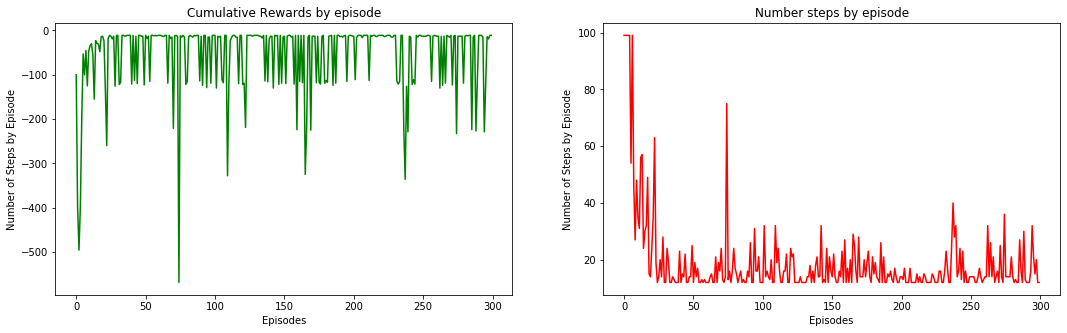

In [21]:
#Gráficas
fig, axs = plt.subplots(1, 2, figsize=(18, 5), sharey=False)
axs[0].plot(sum_reward, color='g')
axs[0].set_xlabel('Episodes')
axs[0].set_ylabel('Number of Steps by Episode')
axs[0].set_title('Cumulative Rewards by episode')
axs[1].plot(episode_steps, color='r')
axs[1].set_xlabel('Episodes')
axs[1].set_ylabel('Number of Steps by Episode')
axs[1].set_title('Number steps by episode')
plt.show()

In [22]:
max_steps = 20
play_game(Q, max_steps, time_visual=0.01)

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -9.06954631 -108.70676208   -9.70676366   -9.70676446]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-9.70583632 -8.40577741 -9.7067644  -9.06954628]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -9.06953756   -7.71435146 -108.70671872   -9.0695463 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.40576959   -6.99411611 -108.70652994   -8.40572092]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -7.7142981    -6.24387095 -1

## SARSA

In [23]:
env = gym.make("CliffWalking-v0")#Las acciones están codificados con: 0(up), 1(right), 2(down), 3(left)
print('Número de estados', env.observation_space.n)
print('Número de acciones', env.action_space.n)    

#Parámetros

control_reward=-50 #Para manejar el bug de Cliff Walking
epsilon = 0.10 #Epsilon Greedy Search

alpha = 0.81 #0.81 #Learning Rate
gamma = 0.96 #0.96 # Discounting rate

total_episodes = 500 #Número de iteraciones
max_steps = 500 #Máximo número de pasos permitidos en cada episodio
control_policies = 'SARSA' # Opciones: 'Q-Learning', 'SARSA'

# Start    
Q, sum_reward, episode_steps = fit_learn(total_episodes,max_steps,control_policies)

Número de estados 48
Número de acciones 4
episode 1 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [0. 1. 0. 0.]
ACCION Right  estado 36  reward -100  done False
Exploto [0. 1. 0. 0.]
Q_después [  0.     -80.0324   0.       0.    ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  0.     -80.0324   0.       0.    ]
ACCION Up  estado 36  reward -1  done False
Exploto [0. 1. 0. 0.]
Q_después [-3.24000e-02 -8.00324e+01  0.00000e+00  0.00000e+00]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [0. 1. 0. 0.]
ACCION Right  estado 24  reward -1  done False
Exploto [0. 1. 0. 0.]
Q_después [0.     0.1576 0.     0.    ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o 

ACCION Down  estado 22  reward -1  done False
Exploto [0.     0.1576 0.     0.    ]
Q_después [-0.0324     -0.62       -0.68745024  0.        ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [0.     0.1576 0.     0.    ]
ACCION Right  estado 34  reward -1  done False
Exploto [-0.0324     -0.65750624  0.81        0.        ]
Q_después [ 0.     -0.1502  0.      0.    ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.0324     -0.65750624  0.81        0.        ]
ACCION Down  estado 35  reward 1  done True
Exploto [0. 1. 0. 0.]
Q_después [-0.0324     -0.65750624  0.9639      0.        ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 3 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o

Exploto [0.     0.1576 0.     0.    ]
Q_después [ 0.         -0.65750624  0.          0.        ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [0.     0.1576 0.     0.    ]
ACCION Up  estado 16  reward -1  done False
Exploto [0. 1. 0. 0.]
Q_después [-0.0324  0.1576  0.      0.    ]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [0. 1. 0. 0.]
ACCION Right  estado 4  reward -1  done False
Exploto [0. 1. 0. 0.]
Q_después [0.     0.1576 0.     0.    ]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [0. 1. 0. 0.]
ACCION Right  estado 5  reward -1  done False
Exploto [0. 1. 0. 0.]
Q_después [0.     0.1576 0.     0.    ]
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o

o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.81       -1.262168   -0.81       -0.94061555]
ACCION Up  estado 7  reward -1  done False
Exploto [-0.81       -1.262168   -0.81       -0.94061555]
Q_después [-1.593756   -1.262168   -0.81       -0.94061555]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.593756   -1.262168   -0.81       -0.94061555]
ACCION Down  estado 7  reward -1  done False
Exploto [-1.593756   -0.90451555 -0.81       -0.81      ]
Q_después [-1.593756   -1.262168   -1.593756   -0.94061555]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.593756   -0.90451555 -0.81       -0.81      ]
ACCION Down  estado 19  reward -1  done False
Exploto [-0.81       -0.65750624 

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.81     -0.780056 -0.81      0.      ]
ACCION Left  estado 2  reward -1  done False
Exploto [ 0.       -0.780056  0.        0.      ]
Q_después [-0.81     -0.780056 -0.81     -0.81    ]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ 0.       -0.780056  0.        0.      ]
ACCION Up  estado 1  reward -1  done False
Exploto [ 0.       -0.780056  0.        0.      ]
Q_después [-0.81     -0.780056  0.        0.      ]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.81     -0.780056  0.        0.      ]
ACCION Down  estado 1  reward -1  done False
Exploto [-0.0324   -0.780056 -0.81      0.      ]
Q_después [-0.81     -0.780056 -0.81      0.      ]
o  o  o  o  o  o  o  o 

ACCION Up  estado 24  reward -1  done False
Exploto [-0.99026388 -0.96012043 -1.439856   -0.94061555]
Q_después [ -1.734108   -64.94693414  -1.57899911  -1.593756  ]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.99026388 -0.96012043 -1.439856   -0.94061555]
ACCION Left  estado 12  reward -1  done False
Exploto [-0.99026388 -0.96012043 -1.439856   -0.94061555]
Q_después [-0.99026388 -0.96012043 -1.439856   -1.7201396 ]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.99026388 -0.96012043 -1.439856   -1.7201396 ]
ACCION Right  estado 12  reward -1  done False
Exploto [-0.816156   -1.58806664 -0.81       -0.81      ]
Q_después [-0.99026388 -1.62227888 -1.439856   -1.7201396 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o 

Q_después [-1.593756   -1.7689066  -1.72456365 -1.593756  ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.57047155 -1.44620304 -0.9639     -0.81      ]
ACCION Left  estado 14  reward -1  done False
Exploro [-2.46469565 -1.58806664 -1.593756   -1.73392919]
Q_después [-1.57047155 -1.44620304 -0.9639     -2.19878062]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.46469565 -1.58806664 -1.593756   -1.73392919]
ACCION Right  estado 13  reward -1  done False
Exploto [-1.57047155 -1.44620304 -0.9639     -2.19878062]
Q_después [-2.46469565 -1.8612613  -1.593756   -1.73392919]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.57047155 -1.44620304 -0.9639     -2.19878062]
ACCION Down  e

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -1.439856    -0.65750624 -83.39960336  -0.81      ]
ACCION Right  estado 28  reward -1  done False
Exploto [ -0.81        -0.780056   -82.82900719   0.        ]
Q_después [ -1.439856    -0.93492619 -83.39960336  -0.81      ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -0.81        -0.780056   -82.82900719   0.        ]
ACCION Left  estado 29  reward -1  done False
Exploto [ -1.439856    -0.93492619 -83.39960336  -0.81      ]
Q_después [ -0.81        -0.780056   -82.82900719  -1.439856  ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -1.439856    -0.93492619 -83.39960336  -0.81      ]
ACCION Left  estado 28  reward -1  done False
Exploto [ -1.593756    -0.93492619 -82.23930467  -1.95709752]
Q_después [ -1.439856    -0.93492619 -83.39

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [ -0.81        -0.65750624 -81.79555687   0.        ]
ACCION Left  estado 31  reward -1  done False
Exploto [ -0.81        -0.95821064 -83.95171221  -1.439856  ]
Q_después [ -0.81        -0.65750624 -81.79555687  -1.439856  ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -0.81        -0.95821064 -83.95171221  -1.439856  ]
ACCION Up  estado 30  reward -1  done False
Exploto [-0.81       -1.46470059 -0.81       -1.593756  ]
Q_después [ -1.593756    -0.95821064 -83.95171221  -1.439856  ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.81       -1.46470059 -0.81       -1.593756  ]
ACCION Up  estado 18  reward -1  done False
Exploto [-0.81       -1.31461731 -0.94061555 -2.

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.10972103 -3.56192162 -3.29257277 -3.7740344 ]
ACCION Up  estado 12  reward -1  done False
Exploto [-3.08590967 -3.08026468 -3.0351908  -2.62059936]
Q_después [-3.43862506 -3.56192162 -3.29257277 -3.7740344 ]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.08590967 -3.08026468 -3.0351908  -2.62059936]
ACCION Left  estado 0  reward -1  done False
Exploto [-3.08590967 -3.08026468 -3.0351908  -2.62059936]
Q_después [-3.08590967 -3.08026468 -3.0351908  -3.34569194]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.08590967 -3.08026468 -3.0351908  -3.34569194]
ACCION Down  estado 0  reward -1  done False
Exploto [-3.43862506 -3.56192162 -3.29257277 -3.7740344 ]
Q_después [-3.08590967 -3.08026468 -3.94699084 -3.34569194]
o  o  o  o  o  o  o 

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -4.50461213 -80.0324     -63.62951708  -5.14769099]
ACCION Up  estado 36  reward -1  done False
Exploto [ -4.22364736 -64.94693414  -3.95839182  -4.48293819]
Q_después [ -4.74392178 -80.0324     -63.62951708  -5.14769099]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -4.22364736 -64.94693414  -3.95839182  -4.48293819]
ACCION Down  estado 24  reward -1  done False
Exploto [ -4.74392178 -80.0324     -63.62951708  -5.14769099]
Q_después [ -4.22364736 -64.94693414  -5.25096802  -4.48293819]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -4.74392178 -80.0324     -63.62951708  -5.14769099]
ACCION Up  estado 36  reward -1  done False
Explo

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-3.26092507 -2.34661328 -2.33549516 -2.52400915]
ACCION Down  estado 16  reward -1  done False
Exploto [  -3.04468992   -2.38922048 -100.33185738   -2.96027793]
Q_después [-3.26092507 -2.34661328 -3.11160193 -2.52400915]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [  -3.04468992   -2.38922048 -100.33185738   -2.96027793]
ACCION Down  estado 28  reward -100  done False
Exploto [ -5.24510687 -80.0324     -63.62951708  -5.14769099]
Q_después [  -3.04468992   -2.38922048 -104.06589742   -2.96027793]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploro [ -5.24510687 -80.0324     -63.62951708  -5.14769099]
ACCION Right  estado 36  reward -100  done False
Exploto [ -5.24510687 -80.0324     -63.62951708  -5.14769099]


o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.53337172 -4.07464771 -4.09780186 -4.33080677]
ACCION Right  estado 13  reward -1  done False
Exploto [-4.23675838 -3.68261246 -3.83326566 -3.27596264]
Q_después [-4.53337172 -4.13157161 -4.09780186 -4.33080677]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.23675838 -3.68261246 -3.83326566 -3.27596264]
ACCION Left  estado 14  reward -1  done False
Exploto [-4.53337172 -4.13157161 -4.09780186 -4.33080677]
Q_después [-4.23675838 -3.68261246 -3.83326566 -4.61888363]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.53337172 -4.13157161 -4.09780186 -4.33080677]
ACCION Down  estado 13  reward -1  done False
Exploto [ -3.37144436  -3.73593868 -82.23930467 -51.6057791 ]
Q_después [-4.53337172 -4.13157161 -4.21021749 -4.33080677]
o  o  o  o 

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.446012   -0.98340488 -0.94061555 -0.81      ]
ACCION Left  estado 21  reward -1  done False
Exploto [-1.78692393 -1.46948749 -1.5952885  -1.439856  ]
Q_después [-1.446012   -0.98340488 -0.94061555 -2.08353203]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.78692393 -1.46948749 -1.5952885  -1.439856  ]
ACCION Left  estado 20  reward -1  done False
Exploto [-2.41892341 -2.10286595 -1.78444007 -2.20320467]
Q_después [-1.78692393 -1.46948749 -1.5952885  -2.47115324]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.41892341 -2.10286595 -1.78444007 -2.20320467]
ACCION Down  estado 19  reward -1  done False
Exploto [ -2.20320467  -1.6099188  -81.79555687  -1.439856  ]
Q_después [-2.41892341 -2.10286595 -2

ACCION Down  estado 2  reward -1  done False
Exploto [-4.23675838 -4.23810525 -4.43538004 -4.61888363]
Q_después [-4.39157583 -3.67928389 -4.80340567 -4.33940779]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.23675838 -4.23810525 -4.43538004 -4.61888363]
ACCION Up  estado 14  reward -1  done False
Exploto [-4.39157583 -3.67928389 -4.80340567 -4.33940779]
Q_después [-4.47599525 -4.23810525 -4.43538004 -4.61888363]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.39157583 -3.67928389 -4.80340567 -4.33940779]
ACCION Right  estado 2  reward -1  done False
Exploto [-3.7959262  -3.59988891 -3.26942435 -3.58980608]
Q_después [-4.39157583 -4.05136832 -4.80340567 -4.33940779]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C 

x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -6.02615591 -64.94693414  -6.74699904  -6.36877588]
ACCION Up  estado 24  reward -1  done False
Exploto [-5.31468723 -5.31862549 -6.2369745  -5.77107369]
Q_después [ -6.08767041 -64.94693414  -6.74699904  -6.36877588]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.31468723 -5.31862549 -6.2369745  -5.77107369]
ACCION Up  estado 12  reward -1  done False
Exploro [-5.30782902 -5.13636345 -5.48775658 -5.18979329]
Q_después [-6.08707009 -5.31862549 -6.2369745  -5.77107369]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.30782902 -5.13636345 -5.48775658 -5.18979329]
ACCION Right  estado 0  reward -1  done False
Exploto [-5.51603433 -4.50790395 -4.9920154  -4.80678232]
Q_después [-5.30782902 -5.29125516 -5

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.41892341 -2.59905658 -3.28143095 -3.05402741]
ACCION Up  estado 19  reward -1  done False
Exploto [-2.59448303 -2.39804556 -3.13785733 -3.61710602]
Q_después [-3.13431568 -2.59905658 -3.28143095 -3.05402741]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.59448303 -2.39804556 -3.13785733 -3.61710602]
ACCION Right  estado 7  reward -1  done False
Exploto [-1.593756   -1.82741192 -2.23738112 -2.22802162]
Q_después [-2.59448303 -2.50493332 -3.13785733 -3.61710602]
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.593756   -1.82741192 -2.23738112 -2.22802162]
ACCION Up  estado 8  reward -1  done False
Exploto [-1.593756   -1.82741192 -2.23738112 -2.22802162]
Q_después [-2.35211831 -1.82741192 -2.23738112 -2.22802162]
o  o  o  o  o  o  o  

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -4.56627723  -5.19709874 -82.46894657  -4.9524441 ]
ACCION Up  estado 26  reward -1  done False
Exploto [-4.47599525 -4.85470597 -5.20345938 -4.61888363]
Q_después [ -5.15812658  -5.19709874 -82.46894657  -4.9524441 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.47599525 -4.85470597 -5.20345938 -4.61888363]
ACCION Up  estado 14  reward -1  done False
Exploto [-5.05928877 -5.46662766 -5.17159859 -5.37224142]
Q_después [-5.59454205 -4.85470597 -5.20345938 -4.61888363]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.05928877 -5.46662766 -5.17159859 -5.37224142]
ACCION Up  estado 2  reward -1  done False
Exploro [-5.05928877 -5.4666

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-5.30782902 -5.92935378 -5.48775658 -5.83164399]
ACCION Down  estado 0  reward -1  done False
Exploto [-6.12179419 -5.90686236 -6.2369745  -5.77107369]
Q_después [-5.30782902 -5.92935378 -6.34026065 -5.83164399]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.12179419 -5.90686236 -6.2369745  -5.77107369]
ACCION Left  estado 12  reward -1  done False
Exploto [-6.12179419 -5.90686236 -6.2369745  -5.77107369]
Q_después [-6.12179419 -5.90686236 -6.2369745  -6.3940909 ]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.12179419 -5.90686236 -6.2369745  -6.3940909 ]
ACCION Right  estado 12  reward -1  done False
Exploto [-5.62263036 -5.53594432 -5.72017719 -5.56068161]
Q_desp

ACCION Right  estado 14  reward -1  done False
Exploro [-5.4969324  -4.98510698 -6.17337561 -5.63008925]
Q_después [-5.59454205 -6.16281077 -5.59854806 -5.57937341]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.4969324  -4.98510698 -6.17337561 -5.63008925]
ACCION Right  estado 15  reward -1  done False
Exploto [-4.95517111 -4.88397856 -5.11111402 -4.74521061]
Q_después [-5.4969324  -5.4470461  -6.17337561 -5.63008925]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.95517111 -4.88397856 -5.11111402 -4.74521061]
ACCION Left  estado 16  reward -1  done False
Exploto [-5.4969324  -5.4470461  -6.17337561 -5.63008925]
Q_después [-4.95517111 -4.88397856 -5.11111402 -5.94721306]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  

o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.62263036 -5.63684878 -6.48490291 -7.06046207]
ACCION Up  estado 13  reward -1  done False
Exploto [-6.14731481 -6.13241783 -6.13787624 -6.54512186]
Q_después [-6.64686787 -5.63684878 -6.48490291 -7.06046207]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.14731481 -6.13241783 -6.13787624 -6.54512186]
ACCION Right  estado 1  reward -1  done False
Exploto [-5.79269993 -5.46662766 -6.17152781 -5.93927871]
Q_después [-6.14731481 -6.22600905 -6.13787624 -6.54512186]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.79269993 -5.46662766 -6.17152781 -5.93927871]
ACCION Right  estado 2  reward -1  done False
Exploto [-5.24103581 -5.3018371

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -2.34453628   -2.00348536 -106.13336955   -3.56518371]
ACCION Right  estado 32  reward -1  done False
Exploto [ -1.70010955 -64.48332862 -84.37032874  -1.55510459]
Q_después [  -2.34453628   -2.39991155 -106.13336955   -3.56518371]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -1.70010955 -64.48332862 -84.37032874  -1.55510459]
ACCION Left  estado 33  reward -1  done False
Exploto [  -2.34453628   -2.39991155 -106.13336955   -3.56518371]
Q_después [ -1.70010955 -64.48332862 -84.37032874  -2.92858128]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -2.34453628   -2.39991155 -106.13336955   -3.56518371]
ACCION Up  estado 32  reward -1  done False
Exploto [-3.08504492 

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -5.77975973   -6.41821386 -102.81127772   -6.11242336]
ACCION Up  estado 26  reward -1  done False
Exploto [-6.36650845 -6.16281077 -6.22220816 -6.19406696]
Q_después [  -6.700356     -6.41821386 -102.81127772   -6.11242336]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-6.36650845 -6.16281077 -6.22220816 -6.19406696]
ACCION Up  estado 14  reward -1  done False
Exploto [-6.41501646 -6.07099161 -6.17152781 -6.88354025]
Q_después [-6.74043968 -6.16281077 -6.22220816 -6.19406696]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.41501646 -6.07099161 -6.17152781 -6.88354025]
ACCION Right  estado 2  reward -1  done False
Exploto [-5.88122

ACCION Right  estado 34  reward -1  done False
Exploro [-0.0324     -0.65750624  1.         -0.8427792 ]
Q_después [ -1.81499529  -1.32887688 -81.629856    -1.45944704]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.0324     -0.65750624  1.         -0.8427792 ]
ACCION Down  estado 35  reward 1  done True
Exploro [0. 1. 0. 0.]
Q_después [-0.0324     -0.65750624  1.         -0.8427792 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 16 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -8.69773442 -100.20900052  -22.68279676  -14.72626829]
ACCION Up  estado 36  reward -1  done False
Exploto [ -7.93166947 -64.94693414  -8.62701838  -8.60222008]
Q_después [  -8.63023572 

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -4.68654271   -4.6138001  -104.70046819   -5.57197348]
ACCION Right  estado 29  reward -1  done False
Exploto [ -4.2688078  -64.92934375 -83.95171221  -5.04696394]
Q_después [  -4.68654271   -5.00604697 -104.70046819   -5.57197348]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -4.2688078  -64.92934375 -83.95171221  -5.04696394]
ACCION Up  estado 30  reward -1  done False
Exploro [-4.94335171 -4.48668649 -4.61010389 -4.82766236]
Q_después [ -5.46502377 -64.92934375 -83.95171221  -5.04696394]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.94335171 -4.48668649 -4.61010389 -4.82766236]
ACCION Right  estado 18  reward -1  done False
Exploto [-3.88668227 -3.81788985 -3.

Exploto [-6.75080238 -6.87864782 -6.86376015 -7.6216259 ]
ACCION Up  estado 1  reward -1  done False
Exploto [-6.75080238 -6.87864782 -6.86376015 -7.6216259 ]
Q_después [-7.34207638 -6.87864782 -6.86376015 -7.6216259 ]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-7.34207638 -6.87864782 -6.86376015 -7.6216259 ]
ACCION Down  estado 1  reward -1  done False
Exploto [-7.12524052 -7.28844059 -7.2632426  -7.06046207]
Q_después [-7.34207638 -6.87864782 -7.60432973 -7.6216259 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-7.12524052 -7.28844059 -7.2632426  -7.06046207]
ACCION Left  estado 13  reward -1  done False
Exploto [-7.67316416 -7.62623717 -8.31432753 -8.08750473]
Q_después [-7.12524052 -7.28844059 -7.2632426  -8.08164982]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.61021211 -6.30227774 -7.129943   -6.65611822]
ACCION Right  estado 15  reward -1  done False
Exploto [-6.18514854 -6.01927626 -6.01526768 -5.94721306]
Q_después [-6.61021211 -6.63198565 -7.129943   -6.65611822]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.18514854 -6.01927626 -6.01526768 -5.94721306]
ACCION Left  estado 16  reward -1  done False
Exploto [-6.61021211 -6.63198565 -7.129943   -6.65611822]
Q_después [-6.18514854 -6.01927626 -6.01526768 -7.08007142]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-6.61021211 -6.63198565 -7.129943   -6.65611822]
ACCION Right  estado 15  reward -1  done False
Exploto [-6.18514854 -6.019

Exploto [ -9.26765283 -64.94693414  -8.62701838  -8.60222008]
Q_después [ -9.26765283 -64.94693414  -8.62701838  -9.13350815]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -9.26765283 -64.94693414  -8.62701838  -9.13350815]
ACCION Down  estado 24  reward -1  done False
Exploto [ -17.57471445 -100.20900052  -83.13290486  -81.93244335]
Q_después [ -9.26765283 -64.94693414 -16.11523145  -9.13350815]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -17.57471445 -100.20900052  -83.13290486  -81.93244335]
ACCION Up  estado 36  reward -1  done False
Exploto [ -9.26765283 -64.94693414 -16.11523145  -9.13350815]
Q_después [ -11.25141168 -100.20900052  -83.13290486  -81.93244335]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  

o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-8.11908693 -7.8740614  -7.60432973 -8.00023085]
ACCION Down  estado 1  reward -1  done False
Exploro [-8.11125916 -7.9558872  -7.6878696  -8.5681783 ]
Q_después [-8.11908693 -7.8740614  -8.44132054 -8.00023085]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-8.11125916 -7.9558872  -7.6878696  -8.5681783 ]
ACCION Down  estado 13  reward -1  done False
Exploto [ -7.83744438  -7.50601716 -82.23930467 -15.49424293]
Q_después [-8.11125916 -7.9558872  -8.10737417 -8.5681783 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -7.83744438  -7.50601716 -82.23930467 -15.49424293]
ACCION Right  estado 25  reward -1  done False
Exploto [  -7.7734311

Exploto [-1.81499529e+00 -4.16796772e-02 -8.16298560e+01 -1.45944704e+00]
ACCION Right  estado 34  reward -1  done False
Exploto [-0.88346976 -0.65750624  1.         -0.8427792 ]
Q_después [-1.81499529e+00 -4.03191387e-02 -8.16298560e+01 -1.45944704e+00]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-0.88346976 -0.65750624  1.         -0.8427792 ]
ACCION Down  estado 35  reward 1  done True
Exploto [0. 1. 0. 0.]
Q_después [-0.88346976 -0.65750624  1.         -0.8427792 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 24 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -9.4570134  -100.20900052  -83.13290486  -81.93244335]
ACCION Up  estado 36  reward -1  done False
E

ACCION Down  estado 17  reward -1  done False
Exploto [  -5.82929175   -6.01075141 -107.9196696    -6.91279442]
Q_después [-6.07062838 -5.73878971 -6.42805204 -5.98746133]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -5.82929175   -6.01075141 -107.9196696    -6.91279442]
ACCION Up  estado 29  reward -1  done False
Exploto [-6.07062838 -5.73878971 -6.42805204 -5.98746133]
Q_después [  -6.38004831   -6.01075141 -107.9196696    -6.91279442]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.07062838 -5.73878971 -6.42805204 -5.98746133]
ACCION Right  estado 17  reward -1  done False
Exploto [-5.51405993 -5.20447285 -5.6104389  -6.07488555]
Q_después [-6.07062838 -5.94736814 -6.42805204 -5.98746133]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o 

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.63623533 -2.00144241 -3.78508347 -3.77817249]
ACCION Right  estado 21  reward -1  done False
Exploto [-2.7058063  -2.22001318 -1.03873006 -2.8036756 ]
Q_después [-3.63623533 -1.99799055 -3.78508347 -3.77817249]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.7058063  -2.22001318 -1.03873006 -2.8036756 ]
ACCION Down  estado 22  reward -1  done False
Exploto [-1.81499529e+00 -4.00115209e-02 -8.16298560e+01 -1.45944704e+00]
Q_después [-2.7058063  -2.22001318 -1.03847167 -2.8036756 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-1.81499529e+00 -4.00115209e-02 -8.16298560e+01 -1.45944704e+00]
ACCION Right  estado 34  reward -1  done False
Exploto [-0.88346976 -0.65750624  1.         -0.8427792 ]
Q_después [-1.81499529e+00 -4.00021890e-02

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.41328046 -6.05042513 -6.71142787 -6.29350666]
ACCION Right  estado 5  reward -1  done False
Exploto [-5.71561776 -5.43590631 -5.75333897 -6.10090956]
Q_después [-6.41328046 -6.18654152 -6.71142787 -6.29350666]
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.71561776 -5.43590631 -5.75333897 -6.10090956]
ACCION Right  estado 6  reward -1  done False
Exploto [-4.7025001  -4.76175546 -5.2915961  -5.2848987 ]
Q_después [-5.71561776 -5.49948627 -5.75333897 -6.10090956]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.7025001  -4.76175546 -5.2915961  -5.2848987 ]
ACCION Up  estado 7  reward -1  done False
Exploto [-4.7025001  -4.76175546 -5.2915961  -5.2848987 ]
Q_después [-5.36013909 -4.76175546 -5.291596

ACCION Right  estado 7  reward -1  done False
Exploto [-4.59297021 -3.80945782 -4.00295849 -4.49339355]
Q_después [-5.36013909 -4.67403925 -5.2915961  -5.2848987 ]
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.59297021 -3.80945782 -4.00295849 -4.49339355]
ACCION Right  estado 8  reward -1  done False
Exploto [-3.7959262  -3.15040427 -2.91774229 -3.17617847]
Q_después [-4.59297021 -3.80263339 -4.00295849 -4.49339355]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.7959262  -3.15040427 -2.91774229 -3.17617847]
ACCION Down  estado 9  reward -1  done False
Exploto [-3.63623533 -1.99687852 -3.78508347 -3.77817249]
Q_después [-3.7959262  -3.15040427 -2.91714377 -3.17617847]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  

ACCION Up  estado 13  reward -1  done False
Exploto [-9.10582119 -8.65928039 -8.72116602 -8.78243657]
Q_después [-9.25170983 -8.99294132 -9.03073003 -9.58795262]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-9.10582119 -8.65928039 -8.72116602 -8.78243657]
ACCION Right  estado 1  reward -1  done False
Exploto [-8.54250052 -7.90386776 -8.08507617 -9.09769359]
Q_después [-9.10582119 -8.60131085 -8.72116602 -8.78243657]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-8.54250052 -7.90386776 -8.08507617 -9.09769359]
ACCION Right  estado 2  reward -1  done False
Exploto [-7.68001096 -7.51440778 -7.47074371 -7.42580478]
Q_después [-8.54250052 -8.08604067 -8.08507617 -9.09769359]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.63623533 -2.91568655 -3.78508347 -3.77817249]
ACCION Right  estado 21  reward -1  done False
Exploto [-2.7058063  -2.22001318 -1.03840001 -2.8036756 ]
Q_después [-3.63623533 -2.17144029 -3.78508347 -3.77817249]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.7058063  -2.22001318 -1.03840001 -2.8036756 ]
ACCION Down  estado 22  reward -1  done False
Exploto [-1.81499529e+00 -4.00000001e-02 -8.16298560e+01 -1.45944704e+00]
Q_después [-2.7058063  -2.22001318 -1.0384     -2.8036756 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.81499529e+00 -4.00000001e-02 -8.16298560e+01 -1.45944704e+00]
ACCION Right  estado 34  reward -1  done F

Q_después [ -10.71704358 -100.20900052  -83.13290486  -45.44948041]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-10.2842379  -64.94693414 -11.52119896 -10.14500081]
ACCION Left  estado 24  reward -1  done False
Exploto [-10.2842379  -64.94693414 -11.52119896 -10.14500081]
Q_después [-10.2842379  -64.94693414 -11.52119896 -10.62630278]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-10.2842379  -64.94693414 -11.52119896 -10.62630278]
ACCION Up  estado 24  reward -1  done False
Exploto [-9.86156811 -9.80569976 -9.8217285  -9.80149006]
Q_después [-10.38564388 -64.94693414 -11.52119896 -10.62630278]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-9.86156811 -9.80569976 -9.8217285  -9

ACCION Right  estado 4  reward -1  done False
Exploto [-6.41328046 -6.24485248 -6.71142787 -7.4727669 ]
Q_después [-7.63811312 -7.00052786 -7.19962856 -7.20277068]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.41328046 -6.24485248 -6.71142787 -7.4727669 ]
ACCION Right  estado 5  reward -1  done False
Exploto [-5.71561776 -5.57218484 -5.75333897 -6.10090956]
Q_después [-6.41328046 -6.3294529  -6.71142787 -7.4727669 ]
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.71561776 -5.57218484 -5.75333897 -6.10090956]
ACCION Right  estado 6  reward -1  done False
Exploto [-5.46295935 -4.8586567  -5.2915961  -5.2848987 ]
Q_después [-5.71561776 -5.64680657 -5.75333897 -6.10090956]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C 

ACCION Right  estado 31  reward -1  done False
Exploto [  -4.58742152   -4.03164702 -106.13336955   -4.91242815]
Q_después [ -5.02463801  -4.81495448 -81.79555687 -51.94106785]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [  -4.58742152   -4.03164702 -106.13336955   -4.91242815]
ACCION Right  estado 32  reward -1  done False
Exploro [ -4.31162418 -64.48332862 -84.37032874  -4.32412604]
Q_después [  -4.58742152  -67.18238056 -106.13336955   -4.91242815]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -4.31162418 -64.48332862 -84.37032874  -4.32412604]
ACCION Up  estado 33  reward -1  done False
Exploro [-3.63623533 -2.88831884 -3.78508347 -3.77817249]
Q_después [ -3.87516532 -64.48332862 -84.37032874  -4.32412604]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o


o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.81499529e+00 -4.00000000e-02 -8.16298560e+01 -1.45944704e+00]
ACCION Right  estado 34  reward -1  done False
Exploto [-0.88346976 -0.15732619  1.         -0.8427792 ]
Q_después [-1.81499529e+00 -4.00000000e-02 -8.16298560e+01 -1.45944704e+00]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-0.88346976 -0.15732619  1.         -0.8427792 ]
ACCION Up  estado 35  reward -1  done False
Exploro [-1.88193977 -1.44620304 -0.04884755 -1.49846131]
Q_después [-2.10242674 -0.15732619  1.         -0.8427792 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.88193977 -1.44620304 -0.04884755 -1.49846131]
ACCION Down  estado 23  reward -1  done False
Exploto [-2.10242674 -0.15732619  1.         -0.8427792 ]
Q_después [-1.88193977 -1.44620304 -0.0416810

ACCION Up  estado 34  reward -1  done False
Exploto [-2.7058063  -2.22001318 -1.03840036 -2.8036756 ]
Q_después [-1.96230922e+00 -4.00000000e-02 -8.16298560e+01 -1.45944704e+00]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.7058063  -2.22001318 -1.03840036 -2.8036756 ]
ACCION Down  estado 22  reward -1  done False
Exploto [-1.96230922e+00 -4.00000000e-02 -8.16298560e+01 -1.45944704e+00]
Q_después [-2.7058063  -2.22001318 -1.03840007 -2.8036756 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.96230922e+00 -4.00000000e-02 -8.16298560e+01 -1.45944704e+00]
ACCION Right  estado 34  reward -1  done False
Exploto [-2.10242674 -0.15732619  1.         -0.8427792 ]
Q_después [-1.96230922e+00 -4.00000000e-02 -8.16298560e+01 -1.45944704e+00]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 46 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -11.41772379 -100.20900052  -83.13290486  -18.02809215]
ACCION Up  estado 36  reward -1  done False
Exploto [-10.89018718 -64.94693414 -11.52119896 -11.09201057]
Q_después [ -11.44757707 -100.20900052  -83.13290486  -18.02809215]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-10.89018718 -64.94693414 -11.52119896 -11.09201057]
ACCION Up  estado 24  reward -1  done False
Exploto [-10.35051544 -10.38193378 -10.93914146 -10.77039872]
Q_después [-10.92769637 -64.94693414 -11.52119896 -11.09201057]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C 

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-8.78416442 -7.82769    -9.23841407 -8.50785814]
ACCION Right  estado 3  reward -1  done False
Exploro [-7.63811312 -7.04364179 -7.62611891 -8.34227945]
Q_después [-8.78416442 -7.77439696 -9.23841407 -8.50785814]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-7.63811312 -7.04364179 -7.62611891 -8.34227945]
ACCION Right  estado 4  reward -1  done False
Exploto [-7.01549017 -6.26040923 -6.71142787 -7.4727669 ]
Q_después [-7.63811312 -7.01638615 -7.62611891 -8.34227945]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-7.01549017 -6.26040923 -6.71142787 -7.4727669 ]
ACCION Down  estado 5  reward -1  done False
Exploto [ -6.77493502  -6.67943189 -85.94966497  -7.53926074]
Q_después [-7.01549017 -6.26040923 -7.27909753 -7.4727669 ]
o  o  o  o  o

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.46295935 -4.6483573  -5.2915961  -5.2848987 ]
ACCION Right  estado 7  reward -1  done False
Exploto [-4.59297021 -3.80033637 -4.95110817 -5.27830741]
Q_después [-5.46295935 -4.64832945 -5.2915961  -5.2848987 ]
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.59297021 -3.80033637 -4.95110817 -5.27830741]
ACCION Right  estado 8  reward -1  done False
Exploto [-3.80024154 -2.91699229 -4.19176584 -4.52617443]
Q_después [-4.59297021 -3.80031712 -4.95110817 -5.27830741]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.80024154 -2.91699229 -4.19176584 -4.52617443]
ACCION Right  estado 9  reward -1  done False
Exploto [-2.82715733 -2.1267274  -1.99686489 -2.94182083]
Q_después [-3.80024154 -2.91699067 -4.191

o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.35211831 -2.6528001  -2.47340499 -3.42700643]
ACCION Up  estado 11  reward -1  done False
Exploto [-2.35211831 -2.6528001  -2.47340499 -3.42700643]
Q_después [-3.08590967 -2.6528001  -2.47340499 -3.42700643]
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.08590967 -2.6528001  -2.47340499 -3.42700643]
ACCION Down  estado 11  reward -1  done False
Exploto [-1.88193977 -1.44620304 -1.47295664 -1.49846131]
Q_después [-3.08590967 -2.6528001  -2.40451443 -3.42700643]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.88193977 -1.44620304 -1.47295664 -1.49846131]
ACCION Right  estado 23  reward -1  done False
Exploto [-1.88193977 -1.446203

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-8.74493757 -8.65797623 -8.60663638 -8.99431573]
ACCION Down  estado 4  reward -1  done False
Exploro [-8.85879993 -8.00374829 -8.04543911 -8.83138888]
Q_después [-8.74493757 -8.65797623 -8.66897558 -8.99431573]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-8.85879993 -8.00374829 -8.04543911 -8.83138888]
ACCION Right  estado 16  reward -1  done False
Exploto [ -6.77493502  -6.80244312 -85.94966497  -7.53926074]
Q_después [-8.85879993 -7.59890164 -8.04543911 -8.83138888]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [ -6.77493502  -6.80244312 -85.94966497  -7.53926074]
ACCION Right  estado 17  reward -1  done False
Exploto [-6.10801594 -6.11413334 -6.2784632  -6.07488555]
Q_después [ -6.77493502  -6.8262

Q_después [-6.34043175 -5.64575754 -6.26581169 -6.9561397 ]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.46295935 -4.84845521 -5.2915961  -5.2848987 ]
ACCION Right  estado 7  reward -1  done False
Exploto [-4.81658011 -4.42395935 -4.95110817 -5.27830741]
Q_después [-5.46295935 -5.17127728 -5.2915961  -5.2848987 ]
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.81658011 -4.42395935 -4.95110817 -5.27830741]
ACCION Right  estado 8  reward -1  done False
Exploro [-3.80024154 -3.45416937 -4.19176584 -4.52617443]
Q_después [-4.81658011 -4.6056201  -4.95110817 -5.27830741]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.80024154 -3.45416937 -4.19176584 -4.52617443]
ACCION Right  e

Exploto [-6.34043175 -5.64575754 -6.26581169 -6.9561397 ]
Q_después [-6.99834936 -6.41927139 -7.27909753 -8.1996008 ]
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.34043175 -5.64575754 -6.26581169 -6.9561397 ]
ACCION Right  estado 6  reward -1  done False
Exploto [-5.46295935 -5.17127728 -5.2915961  -5.2848987 ]
Q_después [-6.34043175 -5.90387914 -6.26581169 -6.9561397 ]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.46295935 -5.17127728 -5.2915961  -5.2848987 ]
ACCION Right  estado 7  reward -1  done False
Exploro [-4.81658011 -4.6056201  -4.95110817 -5.27830741]
Q_después [-5.46295935 -5.89695453 -5.2915961  -5.2848987 ]
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.816

o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.46295935 -5.89695453 -5.12687779 -6.51182562]
ACCION Down  estado 7  reward -1  done False
Exploto [-5.68489865 -3.93869661 -5.52773916 -5.69749072]
Q_después [-5.46295935 -5.89695453 -4.84683727 -6.51182562]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.68489865 -3.93869661 -5.52773916 -5.69749072]
ACCION Right  estado 19  reward -1  done False
Exploto [-4.59307458 -2.93434519 -4.72682907 -5.54605946]
Q_después [-5.68489865 -3.84009918 -5.52773916 -5.69749072]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-4.59307458 -2.93434519 -4.72682907 -5.54605946]
ACCION Down  estado 20  reward -1  done False
Exploto [  -4.28258631  -67.1

o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-3.08590967 -2.6528001  -2.40451443 -3.42700643]
ACCION Up  estado 11  reward -1  done False
Exploto [-3.08590967 -2.6528001  -2.40451443 -3.42700643]
Q_después [-3.26607326 -2.6528001  -2.40451443 -3.42700643]
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.26607326 -2.6528001  -2.40451443 -3.42700643]
ACCION Down  estado 11  reward -1  done False
Exploto [-3.03731898 -2.23487856 -2.45244749 -1.92629872]
Q_después [-3.26607326 -2.6528001  -2.76474762 -3.42700643]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.03731898 -2.23487856 -2.45244749 -1.92629872]
ACCION Left  estado 23  reward -1  done False
Exploto [-2.7058063  -2.1527476

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -3.10386028 -64.48332862 -84.37032874  -4.32412604]
ACCION Up  estado 33  reward -1  done False
Exploto [-4.3474598  -3.29792308 -3.94272761 -3.77817249]
Q_después [ -3.96419844 -64.48332862 -84.37032874  -4.32412604]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.3474598  -3.29792308 -3.94272761 -3.77817249]
ACCION Right  estado 21  reward -1  done False
Exploto [-3.80604358 -2.95686362 -2.74290243 -2.8036756 ]
Q_después [-4.3474598  -3.56948632 -3.94272761 -3.77817249]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.80604358 -2.95686362 -2.74290243 -2.8036756 ]
ACCION Down  estado 22  reward -1  done False
Exploto [ -2.909121    -2.45244703 -81.629856    -4.10062349]
Q_después [-3.80604358 -2.95686362 -3.23817427 -2.8036756 ]
o  o 

o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.3662202  -64.94693414 -12.04775035 -11.97864824]
ACCION Up  estado 24  reward -1  done False
Exploro [-11.49012593 -10.75641179 -11.81689109 -11.2314378 ]
Q_después [-12.15839635 -64.94693414 -12.04775035 -11.97864824]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.49012593 -10.75641179 -11.81689109 -11.2314378 ]
ACCION Right  estado 12  reward -1  done False
Exploto [-10.57257752 -10.29266114 -11.36825518 -10.99724967]
Q_después [-11.49012593 -10.85729154 -11.81689109 -11.2314378 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-10.57257752 -10.29266114 -11.36825518 -10.99724967]
ACCION Right  estado 13  reward -1  done False
Exploto [-10.12158476  -9.48192555 -

ACCION Right  estado 13  reward -1  done False
Exploto [-10.12158476  -9.2269494  -10.37728736 -10.445025  ]
Q_después [-10.57257752  -9.88138136 -11.36825518 -10.99724967]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-10.12158476  -9.2269494  -10.37728736 -10.445025  ]
ACCION Right  estado 14  reward -1  done False
Exploto [ -9.67401275  -8.8566426  -66.48435029  -9.73215736]
Q_después [-10.12158476  -9.45004567 -10.37728736 -10.445025  ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -9.67401275  -8.8566426  -66.48435029  -9.73215736]
ACCION Right  estado 15  reward -1  done False
Exploto [ -9.12030194 -69.0882508   -9.12576217  -9.98203111]
Q_después [ -9.67401275  -9.58470888 -66.48435029  -9.73215736]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  o 

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 71 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -11.81301847 -111.01660299  -26.03042353  -13.29136543]
ACCION Up  estado 36  reward -1  done False
Exploto [-11.11590534 -64.94693414 -12.73508439 -12.40054003]
Q_después [ -11.6982015  -111.01660299  -26.03042353  -13.29136543]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.11590534 -64.94693414 -12.73508439 -12.40054003]
ACCION Up  estado 24  reward -1  done False
Exploto [-11.49012593 -10.61088591 -11.81689109 -11.2314378 ]
Q_después [-11.1730469  -64.94693414 -12.73508439 -12.40054003]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C 

Exploto [-10.12158476 -10.2525926  -10.37728736 -10.445025  ]
Q_después [-10.76161772 -10.70793339 -11.53122281 -10.99724967]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-10.12158476 -10.2525926  -10.37728736 -10.445025  ]
ACCION Up  estado 14  reward -1  done False
Exploto [-10.5739548   -9.55073873 -10.47483354 -10.40272245]
Q_después [-10.15975554 -10.2525926  -10.37728736 -10.445025  ]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-10.5739548   -9.55073873 -10.47483354 -10.40272245]
ACCION Right  estado 2  reward -1  done False
Exploto [ -9.73081311  -8.75587649  -9.96661521 -10.0897506 ]
Q_después [-10.5739548   -9.43320992 -10.47483354 -10.40272245]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  

ACCION Down  estado 35  reward 1  done True
Exploto [0. 1. 0. 0.]
Q_después [-1.24056508 -0.0401529   1.         -0.8427792 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 76 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -13.01991706 -111.01660299  -26.03042353  -12.44946872]
ACCION Left  estado 36  reward -1  done False
Exploto [ -13.01991706 -111.01660299  -26.03042353  -12.44946872]
Q_después [ -13.01991706 -111.01660299  -26.03042353  -12.85610593]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploro [ -13.01991706 -111.01660299  -26.03042353  -12.85610593]
ACCION Up  estado 36  reward -1  done False
Exploto [-11.77575765 -64.94693414 -12.73508439 -12.40054003]
Q_desp

o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.47052291 -5.25905009 -5.56790446 -5.27830741]
ACCION Right  estado 8  reward -1  done False
Exploro [-4.48711371 -2.91699973 -4.38206807 -4.52617443]
Q_después [-5.47052291 -4.07747851 -5.56790446 -5.27830741]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.48711371 -2.91699973 -4.38206807 -4.52617443]
ACCION Right  estado 9  reward -1  done False
Exploto [-3.11627246 -1.99686458 -3.5410734  -3.91542564]
Q_después [-4.48711371 -2.91699185 -4.38206807 -4.52617443]
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.11627246 -1.99686458 -3.5410734  -3.91542564]
ACCION Right  estado 10  reward -1  done False
Exploto [-3.26607326 -3.3768

o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -12.22745653 -111.01660299  -15.42960144  -12.85610593]
ACCION Up  estado 36  reward -1  done False
Exploto [-11.65211808 -64.94693414 -12.73508439 -12.32293176]
Q_después [ -12.19390376 -111.01660299  -15.42960144  -12.85610593]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.65211808 -64.94693414 -12.73508439 -12.32293176]
ACCION Up  estado 24  reward -1  done False
Exploto [-11.49012593 -11.08752196 -11.81689109 -11.67753922]
Q_después [-11.64555951 -64.94693414 -12.73508439 -12.32293176]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.49012593 -11.08752196 -11.81689109 -11.67753922]
ACCION Right  estado 12  reward -1  done False
Exploto [-10.76161772 -10.43334287 -11.53122281 -10.99724967]
Q_de

ACCION Right  estado 9  reward -1  done False
Exploto [-3.11627246 -1.996864   -3.5410734  -3.91542564]
Q_después [-4.48711371 -2.91698945 -4.38206807 -4.52617443]
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.11627246 -1.996864   -3.5410734  -3.91542564]
ACCION Right  estado 10  reward -1  done False
Exploto [-3.26607326 -3.37684938 -1.0384     -3.42700643]
Q_después [-3.11627246 -1.996864   -3.5410734  -3.91542564]
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.26607326 -3.37684938 -1.0384     -3.42700643]
ACCION Down  estado 11  reward -1  done False
Exploto [-2.03442442 -2.9724685  -0.04       -1.99858895]
Q_después [-3.26607326 -3.37684938 -1.0384     -3.42700643]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  C

ACCION Right  estado 7  reward -1  done False
Exploto [-5.47052291 -3.80032291 -5.56790446 -5.27830741]
Q_después [-6.09595946 -4.64842418 -6.17097451 -6.51182562]
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.47052291 -3.80032291 -5.56790446 -5.27830741]
ACCION Right  estado 8  reward -1  done False
Exploto [-4.48711371 -2.91698944 -4.38206807 -4.52617443]
Q_después [-5.47052291 -3.80031234 -5.56790446 -5.27830741]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.48711371 -2.91698944 -4.38206807 -4.52617443]
ACCION Right  estado 9  reward -1  done False
Exploto [-3.11627246 -1.996864   -3.5410734  -3.91542564]
Q_después [-4.48711371 -2.91698944 -4.38206807 -4.52617443]
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C 

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -8.18945445 -18.84720666  -9.12576217 -10.10208093]
ACCION Up  estado 16  reward -1  done False
Exploto [-8.74493757 -7.32948082 -8.66897558 -8.99431573]
Q_después [ -8.06540063 -18.84720666  -9.12576217 -10.10208093]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-8.74493757 -7.32948082 -8.66897558 -8.99431573]
ACCION Right  estado 4  reward -1  done False
Exploto [-7.58160284 -6.28352044 -7.57060236 -8.49872426]
Q_después [-8.74493757 -7.08866685 -8.66897558 -8.99431573]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-7.58160284 -6.28352044 -7.57060236 -8.49872426]
ACCION Right  estado 5  reward -1  done False
Exploto [-6.94500176 -5.46252608 -6.80187569 -6.9561397 ]
Q_después [-7.58160284 -6.25152917 

ACCION Right  estado 5  reward -1  done False
Exploto [-6.94500176 -5.46240019 -6.96940274 -6.99411786]
Q_después [-7.58160284 -6.2439062  -7.57060236 -8.49872426]
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.94500176 -5.46240019 -6.96940274 -6.99411786]
ACCION Right  estado 6  reward -1  done False
Exploto [-6.09595946 -5.67436932 -6.17097451 -6.51182562]
Q_después [-6.94500176 -6.26024562 -6.96940274 -6.99411786]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.09595946 -5.67436932 -6.17097451 -6.51182562]
ACCION Right  estado 7  reward -1  done False
Exploto [-5.47052291 -4.40584582 -5.56790446 -5.27830741]
Q_después [-6.09595946 -5.31411588 -6.17097451 -6.51182562]
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C 

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-5.47052291 -3.86876765 -5.56790446 -5.27830741]
ACCION Down  estado 8  reward -1  done False
Exploto [-5.61273055 -3.94047475 -5.58716909 -5.54605946]
Q_después [-5.47052291 -3.86876765 -4.93201501 -5.27830741]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.61273055 -3.94047475 -5.58716909 -5.54605946]
ACCION Right  estado 20  reward -1  done False
Exploto [-4.95874621 -2.15279832 -4.64167895 -5.03310546]
Q_después [-5.61273055 -3.23270618 -5.58716909 -5.54605946]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.95874621 -2.15279832 -4.64167895 -5.03310546]
ACCION Right  estado 21  reward -1  done False
Exploto [-3.80604358 -1.0384     -3.23817427 -4.19519997]
Q_después [-4.95874621 -2.02649152 -4.64

ACCION Up  estado 36  reward -1  done False
Exploto [-12.35665337 -16.99352899 -12.99785873 -12.48150831]
Q_después [ -12.80530914 -111.01660299  -13.38606113  -12.85610593]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.35665337 -16.99352899 -12.99785873 -12.48150831]
ACCION Up  estado 24  reward -1  done False
Exploto [-11.49012593 -10.43154893 -12.04903917 -11.67753922]
Q_después [-11.26933659 -16.99352899 -12.99785873 -12.48150831]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.49012593 -10.43154893 -12.04903917 -11.67753922]
ACCION Right  estado 12  reward -1  done False
Exploro [-11.00203244  -9.74781753 -11.61373983 -11.20116513]
Q_después [-11.49012593 -11.5020203  -12.04903917 -11.67753922]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o

Q_después [-2.03442442 -2.9724685  -0.19367635 -1.99858895]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.24056508 -0.0401529   1.         -2.47191474]
ACCION Down  estado 35  reward 1  done True
Exploto [0. 1. 0. 0.]
Q_después [-1.24056508 -0.0401529   1.         -2.47191474]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 96 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -12.00604487 -111.01660299  -13.38606113  -12.85610593]
ACCION Up  estado 36  reward -1  done False
Exploto [-11.88589587 -16.99352899 -12.99785873 -12.48150831]
Q_después [ -12.33362116 -111.01660299  -13.38606113  -12.85610593]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o

Exploto [ -8.36766029 -18.84720666  -9.5152293   -9.40727918]
ACCION Up  estado 16  reward -1  done False
Exploto [ -9.27160159  -7.47121286  -9.71922364 -10.08560026]
Q_después [ -8.20947058 -18.84720666  -9.5152293   -9.40727918]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -9.27160159  -7.47121286  -9.71922364 -10.08560026]
ACCION Right  estado 4  reward -1  done False
Exploto [-7.58160284 -6.58202209 -7.15899457 -8.49872426]
Q_después [ -9.27160159  -7.34771082  -9.71922364 -10.08560026]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-7.58160284 -6.58202209 -7.15899457 -8.49872426]
ACCION Right  estado 5  reward -1  done False
Exploto [-6.94500176 -6.24539608 -6.96940274 -6.99411786]
Q_después [-7.58160284 -6.91700419 -7.15899457 -8.49872426]
o  o  o  o  o  o  x  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.28154863 -3.37684938 -1.09438621 -3.42700643]
ACCION Down  estado 11  reward -1  done False
Exploto [-3.86138084 -2.9724685  -0.04020027 -1.99858895]
Q_después [-2.28154863 -3.37684938 -1.04919311 -3.42700643]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.86138084 -2.9724685  -0.04020027 -1.99858895]
ACCION Down  estado 23  reward -1  done False
Exploto [-1.24056508 -0.0401529   1.         -2.47191474]
Q_después [-3.86138084 -2.9724685  -0.04003805 -1.99858895]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.24056508 -0.0401529   1.         -2.47191474]
ACCION Down  estado 35  reward 1  done True
Exploto [0. 1. 0. 0.]
Q_después

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.24056508 -0.0401529   1.         -2.47191474]
ACCION Down  estado 35  reward 1  done True
Exploto [0. 1. 0. 0.]
Q_después [-1.24056508 -0.0401529   1.         -2.47191474]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 103 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -12.85779103 -111.01660299  -13.38606113  -12.85610593]
ACCION Left  estado 36  reward -1  done False
Exploto [ -12.85779103 -111.01660299  -13.38606113  -12.85610593]
Q_después [ -12.85779103 -111.01660299  -13.38606113  -13.2495681 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -12.85779103 -111.01660299  -13.38606113  -13.2495681 ]
ACCION Up  estado

Exploto [ -9.59656322 -18.75873163 -10.37728736 -11.29296184]
Q_después [-11.13671306 -10.24886832 -11.61373983 -11.20116513]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -9.59656322 -18.75873163 -10.37728736 -11.29296184]
ACCION Up  estado 14  reward -1  done False
Exploto [-10.5739548   -9.06588743 -10.92226981 -10.40272245]
Q_después [ -9.68298108 -18.75873163 -10.37728736 -11.29296184]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-10.5739548   -9.06588743 -10.92226981 -10.40272245]
ACCION Down  estado 2  reward -1  done False
Exploto [ -9.68298108 -18.75873163 -10.37728736 -11.29296184]
Q_después [-10.5739548   -9.06588743 -10.41471735 -10.40272245]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C

Q_después [-11.69455211 -11.32311491 -12.04903917 -11.67753922]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-11.13671306 -10.82666363 -11.61373983 -11.20116513]
ACCION Left  estado 13  reward -1  done False
Exploto [-11.69455211 -11.32311491 -12.04903917 -11.67753922]
Q_después [-11.13671306 -10.82666363 -11.61373983 -11.74307553]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-11.69455211 -11.32311491 -12.04903917 -11.67753922]
ACCION Up  estado 12  reward -1  done False
Exploto [-11.72871901 -11.42253273 -11.71306698 -11.65743511]
Q_después [-11.91412635 -11.32311491 -12.04903917 -11.67753922]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.72871901 -11.42253273 -11.71306698

ACCION Right  estado 8  reward -1  done False
Exploro [-4.48711371 -4.44862593 -3.04989336 -4.52617443]
Q_después [-5.47052291 -3.94240152 -5.08293349 -5.27830741]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.48711371 -4.44862593 -3.04989336 -4.52617443]
ACCION Down  estado 9  reward -1  done False
Exploro [-4.95874621 -2.02764381 -5.61461351 -4.20347246]
Q_después [-4.48711371 -4.44862593 -2.96617556 -4.52617443]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.95874621 -2.02764381 -5.61461351 -4.20347246]
ACCION Right  estado 21  reward -1  done False
Exploro [-3.80604358 -1.0414636  -3.23817427 -3.16422673]
Q_después [-4.95874621 -3.65575503 -5.61461351 -4.20347246]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C 

o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -9.72154965  -8.67844659 -10.41471735 -10.40272245]
ACCION Right  estado 2  reward -1  done False
Exploto [-9.08742599 -7.83136485 -9.96661521 -9.86919009]
Q_después [ -9.72154965  -8.54857416 -10.41471735 -10.40272245]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-9.08742599 -7.83136485 -9.96661521 -9.86919009]
ACCION Right  estado 3  reward -1  done False
Exploro [ -9.27160159  -7.74743733  -8.9377675  -10.08560026]
Q_después [-9.08742599 -9.24796733 -9.96661521 -9.86919009]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -9.27160159  -7.74743733  -8.9377675  -10.08560026]
ACCION Right  estado 4  reward -1  done False
Exploto [-7.7

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.6682179  -5.73641893 -6.78072179 -7.23241772]
ACCION Right  estado 18  reward -1  done False
Exploto [ -5.96082973  -4.44702054 -65.51003653  -6.77465622]
Q_después [-6.6682179  -5.35792277 -6.78072179 -7.23241772]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -5.96082973  -4.44702054 -65.51003653  -6.77465622]
ACCION Right  estado 19  reward -1  done False
Exploto [-5.61273055 -3.02509962 -5.58716909 -6.34850405]
Q_después [ -5.96082973  -4.00725137 -65.51003653  -6.77465622]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.61273055 -3.02509962 -5.58716909 -6.34850405]
ACCION Right  estado 20  reward -1  done False
Exploto [-4.0586599  -1.99903802 -4.44459694 -4.20347246]
Q_después [-5.61273055 -2.

ACCION Right  estado 4  reward -1  done False
Exploto [-7.74704549 -7.41073008 -6.96002489 -8.32264172]
Q_después [ -9.27160159  -7.60685025  -8.9377675  -10.08560026]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-7.74704549 -7.41073008 -6.96002489 -8.32264172]
ACCION Down  estado 5  reward -1  done False
Exploto [ -7.95814745  -6.15253286 -85.94966497  -8.49859299]
Q_después [-7.74704549 -7.41073008 -6.91661428 -8.32264172]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -7.95814745  -6.15253286 -85.94966497  -8.49859299]
ACCION Right  estado 17  reward -1  done False
Exploto [-6.54943225 -4.94404399 -6.78072179 -7.23241772]
Q_después [ -7.95814745  -5.82346985 -85.94966497  -8.49859299]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  

o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.1483824  -12.02797669 -12.04903917 -12.10918695]
ACCION Right  estado 12  reward -1  done False
Exploto [-11.13671306 -11.36686595 -11.61373983 -11.74307553]
Q_después [-12.1483824  -11.75522364 -12.04903917 -12.10918695]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-11.13671306 -11.36686595 -11.61373983 -11.74307553]
ACCION Down  estado 13  reward -1  done False
Exploto [-11.09649582 -11.38068959 -82.23930467 -15.49424293]
Q_después [-11.13671306 -11.36686595 -11.64524572 -11.74307553]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.09649582 -11.38068959 -82.23930467 -15.49424293]
ACCION Up  estado 25  reward -1  done False
Ex

ACCION Right  estado 6  reward -1  done False
Exploto [-6.09595946 -5.48405214 -6.54282961 -6.51182562]
Q_después [-7.5299837  -6.14638842 -7.22530978 -7.80443313]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.09595946 -5.48405214 -6.54282961 -6.51182562]
ACCION Right  estado 7  reward -1  done False
Exploto [-5.50794421 -4.42126034 -5.08293349 -5.49054282]
Q_después [-6.09595946 -5.28994195 -6.54282961 -6.51182562]
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.50794421 -4.42126034 -5.08293349 -5.49054282]
ACCION Right  estado 8  reward -1  done False
Exploto [-4.48711371 -4.44862593 -3.09081905 -4.73558456]
Q_después [-5.50794421 -4.05346035 -5.08293349 -5.49054282]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C 

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.15173123 -4.62979627 -4.90512256 -4.73558456]
ACCION Right  estado 9  reward -1  done False
Exploto [-4.51136534 -3.95823364 -4.54072686 -5.0431105 ]
Q_después [-5.15173123 -4.76758377 -4.90512256 -4.73558456]
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.51136534 -3.95823364 -4.54072686 -5.0431105 ]
ACCION Right  estado 10  reward -1  done False
Exploto [-3.58732843 -3.2257336  -3.42914378 -4.44569395]
Q_después [-4.51136534 -4.07039484 -4.54072686 -5.0431105 ]
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.58732843 -3.2257336  -3.42914378 -4.44569395]
ACCION Right  estado 11  reward -1  done False
Exploto [-3.58732843 -3.2257336  -3.42914378 -4.44569395]
Q_después [-3.58732843 -3.93121983 -3.4

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.15173123 -4.88097994 -4.90512256 -5.97311076]
ACCION Right  estado 9  reward -1  done False
Exploto [-4.51136534 -4.37288161 -4.54072686 -5.0431105 ]
Q_después [-5.15173123 -5.13773893 -4.90512256 -5.97311076]
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-4.51136534 -4.37288161 -4.54072686 -5.0431105 ]
ACCION Down  estado 10  reward -1  done False
Exploto [-4.37206491 -1.05787189 -4.20455742 -4.12732084]
Q_después [-4.51136534 -4.37288161 -2.49533928 -5.0431105 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.37206491 -1.05787189 -4.20455742 -4.12732084]
ACCION Right  estado 22  reward -1  done False
Exploto [-3.69082491 -2.9724685  -0.04       -2.04118445]
Q_después [-4.37206491 -1.04209966 -4.20

o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.15173123 -5.13773893 -3.46921044 -5.97311076]
ACCION Down  estado 9  reward -1  done False
Exploto [-5.26353593 -2.04237252 -5.3745185  -4.20347246]
Q_después [-5.15173123 -5.13773893 -3.05729886 -5.97311076]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.26353593 -2.04237252 -5.3745185  -4.20347246]
ACCION Right  estado 21  reward -1  done False
Exploto [-4.37206491 -1.03910294 -4.20455742 -4.12732084]
Q_después [-5.26353593 -2.00605722 -5.3745185  -4.20347246]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.37206491 -1.03910294 -4.20455742 -4.12732084]
ACCION Right  estado 22  reward -1  done False
Exploto [-3.69082491 -2.9724

o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.1483824  -12.16335005 -12.04903917 -12.20904442]
ACCION Down  estado 12  reward -1  done False
Exploto [-12.47704131 -16.99352899 -12.99785873 -12.65373408]
Q_después [-12.1483824  -12.16335005 -12.80146477 -12.20904442]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.47704131 -16.99352899 -12.99785873 -12.65373408]
ACCION Up  estado 24  reward -1  done False
Exploto [-12.1483824  -12.16335005 -12.80146477 -12.20904442]
Q_después [-12.62722    -16.99352899 -12.99785873 -12.65373408]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.1483824  -12.16335005 -12.80146477 -12.20904442]
ACCION Up  estado 12  reward -1  done False
Explo

o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.70845038 -6.08080141 -6.89867627 -6.51182562]
ACCION Right  estado 7  reward -1  done False
Exploto [-6.13948682 -4.58930954 -6.17064733 -6.71706362]
Q_después [-6.70845038 -5.53399936 -6.89867627 -6.51182562]
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.13948682 -4.58930954 -6.17064733 -6.71706362]
ACCION Right  estado 8  reward -1  done False
Exploto [-5.15173123 -5.13773893 -4.74356252 -5.1016192 ]
Q_después [-6.13948682 -5.37056302 -6.17064733 -6.71706362]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-5.15173123 -5.13773893 -4.74356252 -5.1016192 ]
ACCION Down  estado 9  reward -1  done False
Exploto [-5.26353593 -4.499068

o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.70845038 -6.13329565 -6.89867627 -6.51182562]
ACCION Right  estado 7  reward -1  done False
Exploto [-6.13948682 -5.37056302 -6.04500719 -6.78108738]
Q_después [-6.70845038 -6.15147598 -6.89867627 -6.51182562]
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.13948682 -5.37056302 -6.04500719 -6.78108738]
ACCION Right  estado 8  reward -1  done False
Exploto [-5.15173123 -5.13773893 -4.97989707 -5.1016192 ]
Q_después [-6.13948682 -5.70277493 -6.04500719 -6.78108738]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.15173123 -5.13773893 -4.97989707 -5.1016192 ]
ACCION Down  estado 9  reward -1  done False
Exploto [-5.26353593 -2.165492

o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.9621358  -11.7434542  -11.87222091 -11.74307553]
ACCION Left  estado 13  reward -1  done False
Exploto [-12.32911167 -12.15140654 -12.80146477 -12.20904442]
Q_después [-11.9621358  -11.7434542  -11.87222091 -12.49011807]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-12.32911167 -12.15140654 -12.80146477 -12.20904442]
ACCION Right  estado 12  reward -1  done False
Exploto [-11.9621358  -11.7434542  -11.87222091 -12.49011807]
Q_después [-12.32911167 -12.25047723 -12.80146477 -12.20904442]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.9621358  -11.7434542  -11.87222091 -12.49011807]
ACCION Right  estado 13  reward -1  done False

ACCION Up  estado 26  reward -1  done False
Exploto [-10.35238187 -12.29012564 -11.65176394 -12.01100582]
Q_después [ -11.05648931  -66.23463426 -102.81127772  -11.975217  ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-10.35238187 -12.29012564 -11.65176394 -12.01100582]
ACCION Up  estado 14  reward -1  done False
Exploto [-10.90032461  -9.33098934 -11.16708231 -11.17873409]
Q_después [-10.03272987 -12.29012564 -11.65176394 -12.01100582]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-10.90032461  -9.33098934 -11.16708231 -11.17873409]
ACCION Up  estado 2  reward -1  done False
Exploto [-10.90032461  -9.33098934 -11.16708231 -11.17873409]
Q_después [-10.13683899  -9.33098934 -11.16708231 -11.17873409]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o 

ACCION Down  estado 35  reward 1  done True
Exploto [0. 1. 0. 0.]
Q_después [-1.04579726 -0.0401529   1.         -2.47191474]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 140 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploro [ -13.1145796  -111.01660299  -13.52035716  -13.4851862 ]
ACCION Down  estado 36  reward -1  done False
Exploro [ -13.1145796  -111.01660299  -13.52035716  -13.4851862 ]
Q_después [ -13.1145796  -111.01660299  -13.86494865  -13.4851862 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -13.1145796  -111.01660299  -13.86494865  -13.4851862 ]
ACCION Up  estado 36  reward -1  done False
Exploto [-12.79531668 -13.34971618 -12.99785873 -13.05375309]
Q_des

Exploto [ -8.30604122  -6.81309502 -18.77607511  -8.17581763]
ACCION Right  estado 5  reward -1  done False
Exploto [-7.5299837  -5.7082257  -7.22530978 -8.08593748]
Q_después [ -8.30604122  -6.54320436 -18.77607511  -8.17581763]
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-7.5299837  -5.7082257  -7.22530978 -8.08593748]
ACCION Right  estado 6  reward -1  done False
Exploto [-6.70845038 -4.71711611 -6.89867627 -6.51182562]
Q_después [-7.5299837  -5.56259237 -7.22530978 -8.08593748]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.70845038 -4.71711611 -6.89867627 -6.51182562]
ACCION Right  estado 7  reward -1  done False
Exploto [-6.13948682 -3.80635201 -6.61006418 -6.39951777]
Q_después [-6.70845038 -4.66607139 -6.89867627 -6.51182562]
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  

o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.51136534 -4.37288161 -1.99686966 -5.0431105 ]
ACCION Down  estado 10  reward -1  done False
Exploro [-4.37206491 -1.03840018 -4.20455742 -3.61437983]
Q_después [-4.51136534 -4.37288161 -3.99994699 -5.0431105 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.37206491 -1.03840018 -4.20455742 -3.61437983]
ACCION Right  estado 22  reward -1  done False
Exploto [-3.69082491 -3.02341713 -0.04       -3.65146661]
Q_después [-4.37206491 -1.03840003 -4.20455742 -3.61437983]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.69082491 -3.02341713 -0.04       -3.65146661]
ACCION Down  estado 23  reward -1  done False
Exploto [-1.04579726 -0.0401

o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-10.54178194 -12.34125705 -12.11830411 -11.96187119]
ACCION Up  estado 13  reward -1  done False
Exploto [-11.40333823  -9.52455316 -11.64261855 -11.72007854]
Q_después [-10.2192311  -12.34125705 -12.11830411 -11.96187119]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.40333823  -9.52455316 -11.64261855 -11.72007854]
ACCION Right  estado 1  reward -1  done False
Exploto [-11.08436907  -9.32103241 -11.16708231 -11.17873409]
Q_después [-11.40333823  -9.8676999  -11.64261855 -11.72007854]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.08436907  -9.32103241 -11.16708231 -11.17873409]
ACCION Right  estado 2  reward -1  done False
Exploto [-10.58455625  -8.18097034 -10

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -8.82177469  -6.99924099  -9.14326031 -10.08560026]
ACCION Right  estado 4  reward -1  done False
Exploro [ -8.30604122  -7.85200452 -18.77607511  -8.17581763]
Q_después [ -8.82177469  -8.24557451  -9.14326031 -10.08560026]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [ -8.30604122  -7.85200452 -18.77607511  -8.17581763]
ACCION Up  estado 5  reward -1  done False
Exploto [ -8.30604122  -7.85200452 -18.77607511  -8.17581763]
Q_después [ -8.49386655  -7.85200452 -18.77607511  -8.17581763]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -8.49386655  -7.85200452 -18.77607511  -8.17581763]
ACCION Right  estado 5  reward -1  done False
Exploto [-7.5299837  -6.19480763 -7.22530978 -8.08593748]
Q_después [ -8.49386655  -7.11896327 -18.77607511  

o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.26353593 -1.99695298 -4.82377036 -5.37787472]
ACCION Right  estado 21  reward -1  done False
Exploto [-4.37206491 -1.0384     -4.20455742 -3.61437983]
Q_después [-5.26353593 -1.99688091 -4.82377036 -5.37787472]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-4.37206491 -1.0384     -4.20455742 -3.61437983]
ACCION Up  estado 22  reward -1  done False
Exploto [-4.51136534 -4.37288161 -2.37744979 -5.0431105 ]
Q_después [-3.48939729 -1.0384     -4.20455742 -3.61437983]
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.51136534 -4.37288161 -2.37744979 -5.0431105 ]
ACCION Down  estado 10  reward -1  done False
Exploto [-3.48939729 -1.0384     -4.20455742 -3.61437983]
Q_despu

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.52775454 -12.25004046 -12.80146477 -12.62347138]
ACCION Right  estado 12  reward -1  done False
Exploto [-10.91969691 -10.95628959 -12.11830411 -12.60838699]
Q_después [-12.52775454 -11.628664   -12.80146477 -12.62347138]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-10.91969691 -10.95628959 -12.11830411 -12.60838699]
ACCION Up  estado 13  reward -1  done False
Exploto [-11.40333823 -10.48603108 -11.64261855 -11.72007854]
Q_después [-11.03868018 -10.95628959 -12.11830411 -12.60838699]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.40333823 -10.48603108 -11.64261855 -11.72007854]
ACCION Right  estado 1  reward -1  done False
Exploto [-11.08436907  -9.45221261 -11.16708231 -12.04749255]
Q_después [-11.40333823 -10.15238643 -11.6426

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.52775454 -11.628664   -12.80146477 -12.62347138]
ACCION Right  estado 12  reward -1  done False
Exploto [-12.20876529 -12.23145315 -12.11830411 -12.60838699]
Q_después [-12.52775454 -12.44263943 -12.80146477 -12.62347138]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-12.20876529 -12.23145315 -12.11830411 -12.60838699]
ACCION Left  estado 13  reward -1  done False
Exploto [-12.52775454 -12.44263943 -12.80146477 -12.62347138]
Q_después [-12.20876529 -12.23145315 -12.11830411 -12.88098995]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.52775454 -12.44263943 -12.80146477 -12.62347138]
ACCION Right  estado 12  reward -1  done False
Exploto [-12.20876529 -12.23145315 -12.11830411 -12.88098995]
Q_después [-12.52775454 -12.59729477 -12.8

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.70845038 -4.65765166 -6.89867627 -6.51182562]
ACCION Right  estado 7  reward -1  done False
Exploto [-7.1164884  -3.80176579 -5.36272427 -6.39951777]
Q_después [-6.70845038 -4.6512069  -6.89867627 -6.51182562]
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-7.1164884  -3.80176579 -5.36272427 -6.39951777]
ACCION Right  estado 8  reward -1  done False
Exploro [-5.16459108 -3.26916301 -2.91741556 -4.67207562]
Q_después [-7.1164884  -5.54832152 -5.36272427 -6.39951777]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.16459108 -3.26916301 -2.91741556 -4.67207562]
ACCION Down  estado 9  reward -1  done False
Exploto [-5.26353593 -3.90276271 -4.82377036 -5.37787472]
Q_después [-5.16459108 -3.26916301 -4.3990

ACCION Down  estado 11  reward -1  done False
Exploto [-2.385828   -3.02341713 -0.04       -3.65146661]
Q_después [-3.58732843 -2.71760966 -1.05479811 -4.44569395]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.385828   -3.02341713 -0.04       -3.65146661]
ACCION Down  estado 23  reward -1  done False
Exploto [-1.04579726 -0.0401529   1.         -2.47191474]
Q_después [-2.385828   -3.02341713 -0.04       -3.65146661]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.04579726 -0.0401529   1.         -2.47191474]
ACCION Down  estado 35  reward 1  done True
Exploto [0. 1. 0. 0.]
Q_después [-1.04579726 -0.0401529   1.         -2.47191474]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode

o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.25380738 -11.32551037 -82.23930467 -12.83893733]
ACCION Right  estado 25  reward -1  done False
Exploto [ -10.14277825  -66.23463426 -102.81127772  -12.71727299]
Q_después [-13.25380738 -10.84887133 -82.23930467 -12.83893733]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -10.14277825  -66.23463426 -102.81127772  -12.71727299]
ACCION Up  estado 26  reward -1  done False
Exploro [-12.4520558   -9.64442595 -12.30843733 -12.33167553]
Q_después [ -10.23663348  -66.23463426 -102.81127772  -12.71727299]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.4520558   -9.64442595 -12.30843733 -12.33167553]
ACCION Right  estado 14  reward -1  done False
Exploto [-11.12098327  -9.51356235 -66.48435029 -11.2680390

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-7.1164884  -5.54832152 -3.80212375 -6.39951777]
ACCION Down  estado 8  reward -1  done False
Exploto [-4.97916973 -2.91725018 -8.65400385 -7.0740419 ]
Q_después [-7.1164884  -5.54832152 -3.80085725 -6.39951777]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.97916973 -2.91725018 -8.65400385 -7.0740419 ]
ACCION Right  estado 20  reward -1  done False
Exploto [ -5.26353593  -1.99686724 -51.86875271  -5.37787472]
Q_después [-4.97916973 -2.9170415  -8.65400385 -7.0740419 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -5.26353593  -1.99686724 -51.86875271  -5.37787472]
ACCION Right  estado 21  reward -1  done False
Exploto [-3.48939729 -1.0384     -4.20455742 -3.05142501]
Q_después [ -5.26353593  -1.99686462 -51.86875271  -5.37787472]
o  

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.27601376 -4.37288161 -3.55314295 -5.0431105 ]
ACCION Down  estado 10  reward -1  done False
Exploto [-4.78727453 -3.84667644 -4.20455742 -4.15973146]
Q_después [-4.27601376 -4.37288161 -4.47627276 -5.0431105 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.78727453 -3.84667644 -4.20455742 -4.15973146]
ACCION Right  estado 22  reward -1  done False
Exploto [-2.385828   -3.02341713 -0.04       -3.65146661]
Q_después [-4.78727453 -1.57197252 -4.20455742 -4.15973146]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-2.385828   -3.02341713 -0.04       -3.65146661]
ACCION Right  estado 23  reward -1  done False
Exploto [-2.385828   -3.02341713 -0.04       -3.65146661]
Q_después [-2.385828   -1.41555325 -0.0

o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -11.26958374  -66.23463426 -102.81127772  -12.71727299]
ACCION Up  estado 26  reward -1  done False
Exploto [-12.4520558  -10.22995155 -12.30843733 -12.33167553]
Q_después [ -10.90603123  -66.23463426 -102.81127772  -12.71727299]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.4520558  -10.22995155 -12.30843733 -12.33167553]
ACCION Right  estado 14  reward -1  done False
Exploto [-11.12098327  -8.86654353 -66.48435029 -11.26803901]
Q_después [-12.4520558   -9.64831504 -12.30843733 -12.33167553]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.12098327  -8.86654353 -66.48435029 -11.26803901]
ACCION Right  estado 15  reward -1  done False
Exploto [ -7.822036   -18.84720666 -84.79761899 -10.2420201 ]
Q

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.57476635 -12.42193686 -12.92526152 -12.69970639]
ACCION Right  estado 0  reward -1  done False
Exploto [-12.47323044 -13.0618523  -12.66803807 -12.57335904]
Q_después [-12.57476635 -12.86935199 -12.92526152 -12.69970639]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.47323044 -13.0618523  -12.66803807 -12.57335904]
ACCION Up  estado 1  reward -1  done False
Exploto [-12.47323044 -13.0618523  -12.66803807 -12.57335904]
Q_después [-12.87909777 -13.0618523  -12.66803807 -12.57335904]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-12.87909777 -13.0618523  -12.66803807 -12.57335904]
ACCION Down  estado 1  reward -1  done False
Exploto [-12.86102256 -12.81669469 -13.19645287 -13.07339944]
Q_después [-1

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.4520558  -12.78578563 -13.15222842 -12.33167553]
ACCION Left  estado 14  reward -1  done False
Exploto [-12.86102256 -12.38527023 -13.19645287 -13.07339944]
Q_después [-12.4520558  -12.78578563 -13.15222842 -12.78380448]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.86102256 -12.38527023 -13.19645287 -13.07339944]
ACCION Right  estado 13  reward -1  done False
Exploto [-12.4520558  -12.78578563 -13.15222842 -12.78380448]
Q_después [-12.86102256 -12.84591993 -13.19645287 -13.07339944]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.4520558  -12.78578563 -13.15222842 -12.78380448]
ACCION Up  estado 14  reward -1  done False
Exploro [-12.77904263 -15.09386367 -11.9596024  -12.72286441]
Q_después [-13.11287415 -12.78578563 -13.1522

x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-13.41230247 -13.44905966 -13.65667562 -13.58368753]
ACCION Up  estado 24  reward -1  done False
Exploto [-13.40739613 -13.53417187 -13.78561066 -13.02447091]
Q_después [-13.48616605 -13.44905966 -13.65667562 -13.58368753]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.40739613 -13.53417187 -13.78561066 -13.02447091]
ACCION Left  estado 12  reward -1  done False
Exploto [-13.40739613 -13.53417187 -13.78561066 -13.02447091]
Q_después [-13.40739613 -13.53417187 -13.78561066 -13.41247805]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.40739613 -13.53417187 -13.78561066 -13.41247805]
ACCION Up  estado 12  reward -1  done False
Exploro [-13.15098704 -13.2699633  -13.3670484  -13.0982359 ]
Q_después [-1

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-14.37525815 -14.24930802 -14.36325999 -14.13465142]
ACCION Left  estado 1  reward -1  done False
Exploto [-14.15681477 -14.28672998 -14.13027715 -13.98730456]
Q_después [-14.37525815 -14.24930802 -14.36325999 -14.37211179]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-14.15681477 -14.28672998 -14.13027715 -13.98730456]
ACCION Left  estado 0  reward -1  done False
Exploto [-14.15681477 -14.28672998 -14.13027715 -13.98730456]
Q_después [-14.15681477 -14.28672998 -14.13027715 -14.34411589]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-14.15681477 -14.28672998 -14.13027715 -14.34411589]
ACCION Down  estado 0  reward -1  done False
Exploro [-14.1784977  -13.98238906 -14.01125384 -14.15118536]
Q_después [-

ACCION Up  estado 24  reward -1  done False
Exploto [-14.1784977  -14.43501064 -14.60477149 -14.15118536]
Q_después [-14.55426349 -14.64253834 -14.60110635 -14.77229826]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-14.1784977  -14.43501064 -14.60477149 -14.15118536]
ACCION Left  estado 12  reward -1  done False
Exploto [-14.1784977  -14.43501064 -14.60477149 -14.15118536]
Q_después [-14.1784977  -14.43501064 -14.60477149 -14.50268695]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-14.1784977  -14.43501064 -14.60477149 -14.50268695]
ACCION Up  estado 12  reward -1  done False
Exploto [-14.15681477 -14.28672998 -14.51995247 -14.34411589]
Q_después [-14.51225373 -14.43501064 -14.60477149 -14.50268695]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-14.51599964 -14.54328499 -15.09156697 -14.63871089]
ACCION Up  estado 14  reward -1  done False
Exploto [-14.59634476 -15.09386367 -14.78241553 -14.70504008]
Q_después [-14.91815761 -14.54328499 -15.09156697 -14.63871089]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-14.59634476 -15.09386367 -14.78241553 -14.70504008]
ACCION Up  estado 2  reward -1  done False
Exploto [-14.59634476 -15.09386367 -14.78241553 -14.70504008]
Q_después [-14.93342319 -15.09386367 -14.78241553 -14.70504008]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-14.93342319 -15.09386367 -14.78241553 -14.70504008]
ACCION Left  estado 2  reward -1  done False
Exploto [-14.71949978 -14.8678779  -15.0691333  -15.29226008]
Q_después [-14.93342319 -15.09386367 -14.78241553 

x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-15.62406891 -15.0475392  -15.34264436 -15.03378317]
ACCION Left  estado 0  reward -1  done False
Exploto [-15.62406891 -15.0475392  -15.34264436 -15.03378317]
Q_después [-15.62406891 -15.0475392  -15.34264436 -15.35668859]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-15.62406891 -15.0475392  -15.34264436 -15.35668859]
ACCION Right  estado 0  reward -1  done False
Exploto [-15.37488414 -15.42163198 -15.6547699  -15.25984149]
Q_después [-15.62406891 -15.53508519 -15.34264436 -15.35668859]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-15.37488414 -15.42163198 -15.6547699  -15.25984149]
ACCION Left  estado 1  reward -1  done False
Exp

ACCION Right  estado 5  reward -1  done False
Exploto [-7.5299837  -6.52161997 -7.80673688 -8.26551991]
Q_después [-9.09515178 -7.07606983 -9.6486972  -9.52582329]
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-7.5299837  -6.52161997 -7.80673688 -8.26551991]
ACCION Right  estado 6  reward -1  done False
Exploto [-6.70845038 -5.37776086 -6.89867627 -6.51182562]
Q_después [-7.5299837  -6.23085464 -7.80673688 -8.26551991]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.70845038 -5.37776086 -6.89867627 -6.51182562]
ACCION Right  estado 7  reward -1  done False
Exploto [-7.1164884  -5.06793164 -7.03283544 -6.39951777]
Q_después [-6.70845038 -5.7725982  -6.89867627 -6.51182562]
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C 

o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-16.28593089 -21.38133185 -23.17492359 -15.9123564 ]
ACCION Left  estado 15  reward -1  done False
Exploto [-15.90624742 -16.19528318 -89.51550601 -16.21603895]
Q_después [-16.28593089 -21.38133185 -23.17492359 -16.20204571]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-15.90624742 -16.19528318 -89.51550601 -16.21603895]
ACCION Up  estado 14  reward -1  done False
Exploto [-15.88053437 -16.01810982 -15.96254164 -16.23247441]
Q_después [-16.18089054 -16.19528318 -89.51550601 -16.21603895]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-15.88053437 -16.01810982 -15.96254164 -16.23247441]
ACCION Up  estado 2  reward -1  done False
Exploro [-15.88053437 -16.01810982 -15.96

ACCION Left  estado 24  reward -1  done False
Exploto [-16.1209973  -16.08388206 -16.05987046 -16.03476881]
Q_después [-16.1209973  -16.08388206 -16.05987046 -16.3252423 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-16.1209973  -16.08388206 -16.05987046 -16.3252423 ]
ACCION Down  estado 24  reward -1  done False
Exploto [ -16.37859259 -112.98643552  -16.31808682  -16.35726602]
Q_después [-16.1209973  -16.08388206 -16.5503197  -16.3252423 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -16.37859259 -112.98643552  -16.31808682  -16.35726602]
ACCION Down  estado 36  reward -1  done False
Exploto [ -16.37859259 -112.98643552  -16.31808682  -16.35726602]
Q_después [ -16.37859259 -112.98643552  -16.5993808   -16.35726602]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-16.43096966 -16.46212269 -16.5503197  -16.3252423 ]
ACCION Left  estado 24  reward -1  done False
Exploto [-16.43096966 -16.46212269 -16.5503197  -16.3252423 ]
Q_después [-16.43096966 -16.46212269 -16.5503197  -16.60630445]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-16.43096966 -16.46212269 -16.5503197  -16.60630445]
ACCION Up  estado 24  reward -1  done False
Exploto [-16.52908648 -16.36010343 -16.55030368 -16.38503917]
Q_después [-16.65350066 -16.46212269 -16.5503197  -16.60630445]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-16.52908648 -16.36010343 -16.55030368 -16.38503917]
ACCION Down  estado 12  reward -1  done False
Exploto [-16.65350066 -16.46212269 -16.5503197  -16.60630445]
Q_después [-16.52908648 -16.36010343 -16.75550

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -8.28807373  -7.73495886 -10.30126463  -9.97573543]
ACCION Right  estado 4  reward -1  done False
Exploto [-9.09515178 -6.6736118  -9.6486972  -9.52582329]
Q_después [ -8.28807373  -7.46904272 -10.30126463  -9.97573543]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-9.09515178 -6.6736118  -9.6486972  -9.52582329]
ACCION Right  estado 5  reward -1  done False
Exploto [-7.5299837  -5.6867202  -7.80673688 -8.26551991]
Q_después [-9.09515178 -6.49997987 -9.6486972  -9.52582329]
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-7.5299837  -5.6867202  -7.80673688 -8.26551991]
ACCION Right  estado 6  reward -1  done False
Exploto [-6.70845038 -4.78365535 -6.89867627 -6.51182562


Exploto [ -17.0229678  -112.98643552  -17.22901085  -17.17041533]
ACCION Up  estado 36  reward -1  done False
Exploto [-16.90505493 -16.99735364 -16.89171791 -16.96663155]
Q_después [ -17.17936373 -112.98643552  -17.22901085  -17.17041533]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-16.90505493 -16.99735364 -16.89171791 -16.96663155]
ACCION Down  estado 24  reward -1  done False
Exploto [ -17.17936373 -112.98643552  -17.22901085  -17.17041533]
Q_después [-16.90505493 -16.99735364 -17.37114136 -16.96663155]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -17.17936373 -112.98643552  -17.22901085  -17.17041533]
ACCION Left  estado 36  reward -1  done False
Exploto [ -17.17936373 -112.98643552  -17.22901085  -17.17041533]
Q_después [ -17.17936373 -112.98643552  -17.22901085  -17.424

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -17.30251599 -112.98643552  -17.4807909   -17.42409387]
ACCION Up  estado 36  reward -1  done False
Exploto [-17.09118093 -16.99735364 -17.5077957  -17.25080218]
Q_después [ -17.31462023 -112.98643552  -17.4807909   -17.42409387]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-17.09118093 -16.99735364 -17.5077957  -17.25080218]
ACCION Right  estado 24  reward -1  done False
Exploro [ -16.29934391  -19.39194921 -108.14176651  -16.90485686]
Q_después [-17.09118093 -16.71386702 -17.5077957  -17.25080218]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -16.29934391  -19.39194921 -108.14176651  -16.90485686]
ACCION Up  estado 25  reward -1 

o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-7.21535517 -6.73080755 -7.80673688 -8.275055  ]
ACCION Right  estado 6  reward -1  done False
Exploto [-6.70845038 -5.31768975 -6.89867627 -6.51182562]
Q_después [-7.21535517 -6.22388898 -7.80673688 -8.275055  ]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.70845038 -5.31768975 -6.89867627 -6.51182562]
ACCION Right  estado 7  reward -1  done False
Exploto [-7.1164884  -5.65539851 -8.87559213 -6.39951777]
Q_después [-6.70845038 -6.21799893 -6.89867627 -6.51182562]
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-7.1164884  -5.65539851 -8.87559213 -6.39951777]
ACCION Right  estado 8  reward -1  done False
Exploro [-5.80725833 -5.37247

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.80725833 -5.37247261 -4.16620902 -5.7834759 ]
ACCION Down  estado 9  reward -1  done False
Exploro [ -5.26353593  -2.53430395 -51.86875271  -5.37787472]
Q_después [-5.80725833 -5.37247261 -3.57225446 -5.7834759 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -5.26353593  -2.53430395 -51.86875271  -5.37787472]
ACCION Right  estado 21  reward -1  done False
Exploto [-3.29622176 -1.42881846 -4.20455742 -4.15973146]
Q_después [ -5.26353593  -2.40256699 -51.86875271  -5.37787472]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.29622176 -1.42881846 -4.20455742 -4.15973146]
ACCION Right  estado 22  reward -1  done False
Exploto [-2.90493433 -2.9190674  -0.04762091 -3.651

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -13.50149445 -116.24992651  -18.72226674  -18.71312996]
ACCION Up  estado 36  reward -1  done False
Exploto [-15.30160265 -18.49223095 -17.5077957  -17.25080218]
Q_después [ -15.27381017 -116.24992651  -18.72226674  -18.71312996]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-15.30160265 -18.49223095 -17.5077957  -17.25080218]
ACCION Up  estado 24  reward -1  done False
Exploro [-16.81888667 -14.51034652 -17.18679851 -16.93424499]
Q_después [-17.08175903 -18.49223095 -17.5077957  -17.25080218]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-16.81888667 -14.51034652 -17.18679851 -16.93424499]
ACCION Right  estado 12  reward -1  done Fa

Exploto [-10.39499738  -8.18138624 -10.30126463  -9.60537141]
Q_después [-15.77162705  -8.86863947 -10.10608459 -15.79049249]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-10.39499738  -8.18138624 -10.30126463  -9.60537141]
ACCION Right  estado 4  reward -1  done False
Exploto [-9.09515178 -7.83780194 -9.6486972  -9.52582329]
Q_después [-10.39499738  -8.45913817 -10.30126463  -9.60537141]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-9.09515178 -7.83780194 -9.6486972  -9.52582329]
ACCION Right  estado 5  reward -1  done False
Exploto [-7.79157766 -6.63637333 -7.80673688 -8.275055  ]
Q_después [-9.09515178 -7.45962627 -9.6486972  -9.52582329]
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-1.04579726 -0.0401529   1.         -1.31113196]
ACCION Right  estado 35  reward -1  done False
Exploto [-1.04579726 -0.0401529   1.         -1.31113196]
Q_después [-1.04579726 -0.04002905  1.         -1.31113196]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.04579726 -0.04002905  1.         -1.31113196]
ACCION Down  estado 35  reward 1  done True
Exploto [0. 1. 0. 0.]
Q_después [-1.04579726 -0.04002905  1.         -1.31113196]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 188 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -14.89031711 -114.96440082  -17.93886678  -18.71312996]
ACCIO

x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-16.81888667 -11.34113872 -16.20577558 -16.93424499]
ACCION Right  estado 12  reward -1  done False
Exploto [-10.83169882 -16.55094406 -17.2153811  -17.05355617]
Q_después [-16.81888667 -11.38754536 -16.20577558 -16.93424499]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-10.83169882 -16.55094406 -17.2153811  -17.05355617]
ACCION Up  estado 13  reward -1  done False
Exploto [-11.8683918  -10.21475938 -16.56615625 -16.4928977 ]
Q_después [-10.81101967 -16.55094406 -17.2153811  -17.05355617]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.8683918  -10.21475938 -16.56615625 -16.4928977 ]
ACCION Right  estado 1  reward -1  done False
Exploto [-16.28298373  -9.2630357  -1

o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.29385591 -11.8918991  -16.56615625 -16.4928977 ]
ACCION Right  estado 1  reward -1  done False
Exploro [-16.28298373 -14.87516697 -16.42514339 -12.2295384 ]
Q_después [-12.29385591 -15.84165233 -16.56615625 -16.4928977 ]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-16.28298373 -14.87516697 -16.42514339 -12.2295384 ]
ACCION Left  estado 2  reward -1  done False
Exploto [-12.29385591 -15.84165233 -16.56615625 -16.4928977 ]
Q_después [-16.28298373 -14.87516697 -16.42514339 -12.69331465]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.29385591 -15.84165233 -16.56615625 -16.4928977 ]
ACCION Up  estado 1  reward -1  done False
Explo

Q_después [-11.79901127 -18.49223095 -17.5077957  -17.50187619]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-16.81888667 -11.21801942 -16.20577558 -16.93424499]
ACCION Right  estado 12  reward -1  done False
Exploro [-14.54621009 -16.55094406 -17.2153811  -17.05355617]
Q_después [-16.81888667 -16.32810404 -16.20577558 -16.93424499]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-14.54621009 -16.55094406 -17.2153811  -17.05355617]
ACCION Up  estado 13  reward -1  done False
Exploto [-16.25481202 -12.63264359 -16.56615625 -16.4928977 ]
Q_después [-13.39692358 -16.55094406 -17.2153811  -17.05355617]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-16.25481202 -12.63264359 -16.5661562

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-10.15242327  -8.66048331 -10.06129225 -10.09053778]
ACCION Right  estado 4  reward -1  done False
Exploto [-9.09515178 -7.91688879 -9.6486972  -9.48875166]
Q_después [-10.15242327  -8.61166455 -10.06129225 -10.09053778]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-9.09515178 -7.91688879 -9.6486972  -9.48875166]
ACCION Right  estado 5  reward -1  done False
Exploto [-7.79157766 -7.83747157 -7.43129575 -8.275055  ]
Q_después [-9.09515178 -8.09278445 -9.6486972  -9.48875166]
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-7.79157766 -7.83747157 -7.43129575 -8.275055  ]
ACCION Down  estado 6  reward -1  done False
Exploto [-7.19668535 -6.80802147 -6.78072179 -7.23241772]
Q_después [-7.79157766 -7.83747157

Exploto [-5.80725833 -3.94916452 -4.84995461 -6.00422057]
Q_después [-5.68920655 -4.91147512 -5.44852325 -6.39951777]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-5.80725833 -3.94916452 -4.84995461 -6.00422057]
ACCION Down  estado 9  reward -1  done False
Exploto [ -5.26353593  -3.75090858 -51.86875271  -5.34570352]
Q_después [-5.80725833 -3.94916452 -4.64819789 -6.00422057]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -5.26353593  -3.75090858 -51.86875271  -5.34570352]
ACCION Right  estado 21  reward -1  done False
Exploto [-3.29622176 -1.64340115 -4.20455742 -4.15973146]
Q_después [ -5.26353593  -2.80058137 -51.86875271  -5.34570352]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exp

Q_después [-14.14136099 -16.55094406 -17.2153811  -17.05355617]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.77941422 -15.61045462 -16.24419725 -17.09586262]
ACCION Up  estado 1  reward -1  done False
Exploto [-13.77941422 -15.61045462 -16.24419725 -17.09586262]
Q_después [-14.1429612  -15.61045462 -16.24419725 -17.09586262]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-14.1429612  -15.61045462 -16.24419725 -17.09586262]
ACCION Up  estado 1  reward -1  done False
Exploto [-14.1429612  -15.61045462 -16.24419725 -17.09586262]
Q_después [-14.49472926 -15.61045462 -16.24419725 -17.09586262]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-14.49472926 -15.61045462 -16.24419725 -17

o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -16.43673599 -112.35835298  -17.93886678  -18.71312996]
ACCION Up  estado 36  reward -1  done False
Exploto [-16.87892473 -87.29352904 -17.5077957  -17.50187619]
Q_después [ -17.05803171 -112.35835298  -17.93886678  -18.71312996]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-16.87892473 -87.29352904 -17.5077957  -17.50187619]
ACCION Up  estado 24  reward -1  done False
Exploto [-16.81888667 -16.78235387 -17.07304935 -16.93424499]
Q_después [-17.06695406 -87.29352904 -17.5077957  -17.50187619]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-16.81888667 -16.78235387 -17.07304935 -16.93424499]
ACCION Right  estado 12  reward -1  done False
Exploto [-12.58157868 -16.55094406 -17.2153811  -17.05355617]
Q_de

o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.64645425 -4.67896104 -4.47627276 -5.0431105 ]
ACCION Down  estado 10  reward -1  done False
Exploto [-3.29622176 -1.3028049  -4.20455742 -4.15973146]
Q_después [-4.64645425 -4.67896104 -2.67355292 -5.0431105 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-3.29622176 -1.3028049  -4.20455742 -4.15973146]
ACCION Down  estado 22  reward -1  done False
Exploro [-4.14851057e+00 -4.00889783e-02 -8.16298560e+01 -4.10062349e+00]
Q_después [-3.29622176 -1.3028049  -4.83474773 -4.15973146]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.14851057e+00 -4.00889783e-02 -8.16298560e+01 -4.10062349e+00]
ACCION Right  estado 34  reward -1  done Fa

Q_después [-12.92052543 -87.29352904 -17.5077957  -17.50187619]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-16.81888667 -12.15528206 -17.07304935 -16.93424499]
ACCION Right  estado 12  reward -1  done False
Exploto [-15.61481257 -16.55094406 -17.2153811  -17.05355617]
Q_después [-16.81888667 -15.26158185 -17.07304935 -16.93424499]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-15.61481257 -16.55094406 -17.2153811  -17.05355617]
ACCION Up  estado 13  reward -1  done False
Exploto [-17.04553459 -11.58786653 -16.24419725 -14.91936565]
Q_después [-12.7875394  -16.55094406 -17.2153811  -17.05355617]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-17.04553459 -11.58786653 -16.2441972

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-17.04553459 -11.09031498 -16.24419725 -14.91936565]
ACCION Right  estado 1  reward -1  done False
Exploto [-12.13877335 -10.43946333 -16.42514339 -16.3266219 ]
Q_después [-17.04553459 -11.03488653 -16.24419725 -14.91936565]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.13877335 -10.43946333 -16.42514339 -16.3266219 ]
ACCION Right  estado 2  reward -1  done False
Exploto [-10.59477761  -9.88586148 -11.39277624 -12.04520001]
Q_después [-12.13877335 -10.48074392 -16.42514339 -16.3266219 ]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-10.59477761  -9.88586148 -11.39277624 -12.04520001]
ACCION Right  estado 3  reward -1  done False
Exploto [-10.15242327  -9.28516439 -

x  C  C  C  C  C  C  C  C  C  C  T

Exploro [ -71.28868083 -118.71534158  -20.54737172  -20.48496694]
ACCION Up  estado 36  reward -1  done False
Exploto [-14.30193735 -87.29352904 -17.5077957  -15.90223753]
Q_después [ -25.47603584 -118.71534158  -20.54737172  -20.48496694]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-14.30193735 -87.29352904 -17.5077957  -15.90223753]
ACCION Up  estado 24  reward -1  done False
Exploto [-16.81888667 -12.73550207 -17.07304935 -16.93424499]
Q_después [-13.43049451 -87.29352904 -17.5077957  -15.90223753]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-16.81888667 -12.73550207 -17.07304935 -16.93424499]
ACCION Right  estado 12  reward -1  done False
Exploto [-15.72153097 -16.55094406 -17.2153811  -17.05355617]
Q_después [-16.81888667 -15.45480788 -1

Exploto [-5.80725833 -4.81626646 -3.82014155 -6.00422057]
Q_después [-5.68920655 -4.7611727  -5.44852325 -6.39951777]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.80725833 -4.81626646 -3.82014155 -6.00422057]
ACCION Down  estado 9  reward -1  done False
Exploto [ -5.26353593  -2.18388896 -51.86875271  -5.34570352]
Q_después [-5.80725833 -4.81626646 -3.23401895 -6.00422057]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -5.26353593  -2.18388896 -51.86875271  -5.34570352]
ACCION Right  estado 21  reward -1  done False
Exploto [-3.29622176 -1.04981529 -4.83474773 -4.15973146]
Q_después [ -5.26353593  -2.04127527 -51.86875271  -5.34570352]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exp

ACCION Up  estado 24  reward -1  done False
Exploto [-16.81888667 -12.32799144 -17.07304935 -16.93424499]
Q_después [-12.90622859 -87.29352904 -17.5077957  -15.90223753]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-16.81888667 -12.32799144 -17.07304935 -16.93424499]
ACCION Down  estado 12  reward -1  done False
Exploto [-12.90622859 -87.29352904 -17.5077957  -15.90223753]
Q_después [-16.81888667 -12.32799144 -14.08976273 -16.93424499]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.90622859 -87.29352904 -17.5077957  -15.90223753]
ACCION Up  estado 24  reward -1  done False
Exploto [-16.81888667 -12.32799144 -14.08976273 -16.93424499]
Q_después [-12.84842958 -87.29352904 -17.5077957  -15.90223753]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  

ACCION Right  estado 6  reward -1  done False
Exploto [-7.87454106 -8.94825745 -6.82545127 -7.60415566]
Q_después [-8.34913054 -7.56350393 -7.83951067 -8.75309429]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-7.87454106 -8.94825745 -6.82545127 -7.60415566]
ACCION Down  estado 7  reward -1  done False
Exploro [ -7.86858429  -5.74096116 -65.51003653  -7.70255839]
Q_después [-7.87454106 -8.94825745 -6.57100714 -7.60415566]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -7.86858429  -5.74096116 -65.51003653  -7.70255839]
ACCION Right  estado 19  reward -1  done False
Exploto [-4.72838787 -6.0615077  -6.42192273 -7.11689487]
Q_después [ -7.86858429  -5.57757703 -65.51003653  -7.70255839]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o

Q_después [-8.34913054 -7.3566809  -7.83951067 -8.75309429]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-7.87454106 -8.94825745 -6.57100714 -7.60415566]
ACCION Down  estado 7  reward -1  done False
Exploto [ -7.86858429  -5.57757703 -65.51003653  -7.70255839]
Q_después [-7.87454106 -8.94825745 -6.39561525 -7.60415566]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -7.86858429  -5.57757703 -65.51003653  -7.70255839]
ACCION Right  estado 19  reward -1  done False
Exploto [-4.67487333 -6.0615077  -6.42192273 -7.11689487]
Q_después [ -7.86858429  -5.50492113 -65.51003653  -7.70255839]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-4.67487333 -6.0615077  -6.42192273 -7.11689487]
ACC

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.17982438 -2.16050529 -0.04       -4.0669207 ]
ACCION Down  estado 23  reward -1  done False
Exploto [-1.04579726 -0.04000552  1.         -1.04832796]
Q_después [-2.17982438 -2.16050529 -0.04       -4.0669207 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.04579726 -0.04000552  1.         -1.04832796]
ACCION Down  estado 35  reward 1  done True
Exploto [0. 1. 0. 0.]
Q_después [-1.04579726 -0.04000552  1.         -1.04832796]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 218 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -14.6963746  -120.38567801  -97.17093275  -80.52298717]
ACCION

o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -7.86858429  -5.21182153 -65.51003653  -7.70255839]
ACCION Right  estado 19  reward -1  done False
Exploro [-5.80392522 -4.82590944 -6.42192273 -5.71633453]
Q_después [ -7.86858429  -5.55287327 -65.51003653  -7.70255839]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.80392522 -4.82590944 -6.42192273 -5.71633453]
ACCION Right  estado 20  reward -1  done False
Exploto [ -5.26353593  -2.24214833 -51.86875271  -5.34570352]
Q_después [-5.80392522 -3.47041733 -6.42192273 -5.71633453]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -5.26353593  -2.24214833 -51.86875271  -5.34570352]
ACCION Right  estado 21  reward -1  done False
Exploto [-3.29622176 -2.70656689 -4.83474773 

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 221 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -13.47166595 -120.38567801  -97.17093275  -80.52298717]
ACCION Up  estado 36  reward -1  done False
Exploto [-12.51408851 -87.29352904 -17.5077957  -15.04183829]
Q_después [ -13.10057176 -120.38567801  -97.17093275  -80.52298717]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.51408851 -87.29352904 -17.5077957  -15.04183829]
ACCION Up  estado 24  reward -1  done False
Exploto [-16.81888667 -11.8975368  -13.66234224 -14.69517335]
Q_después [-12.43920144 -87.29352904 -17.5077957  -15.04183829]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Explot

ACCION Down  estado 7  reward -1  done False
Exploto [ -8.21802246 -34.1827327  -65.51003653  -8.04517197]
Q_después [-8.42940593 -8.94825745 -8.58249411 -8.28466772]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -8.21802246 -34.1827327  -65.51003653  -8.04517197]
ACCION Left  estado 19  reward -1  done False
Exploto [-8.73093868 -7.89154919 -7.72983031 -7.77574275]
Q_después [ -8.21802246 -34.1827327  -65.51003653  -8.34929872]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-8.73093868 -7.89154919 -7.72983031 -7.77574275]
ACCION Down  estado 18  reward -1  done False
Exploto [ -7.42956042 -16.7069428  -83.95171221  -7.53160529]
Q_después [-8.73093868 -7.89154919 -8.05589394 -7.77574275]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-8.42940593 -8.94825745 -8.58249411 -8.87387783]
ACCION Up  estado 7  reward -1  done False
Exploto [-8.42940593 -8.94825745 -8.58249411 -8.87387783]
Q_después [-8.96629317 -8.94825745 -8.58249411 -8.87387783]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-8.96629317 -8.94825745 -8.58249411 -8.87387783]
ACCION Left  estado 7  reward -1  done False
Exploto [-8.88861871 -8.97642777 -8.6599888  -8.75309429]
Q_después [-8.96629317 -8.94825745 -8.58249411 -9.23004408]
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-8.88861871 -8.97642777 -8.6599888  -8.75309429]
ACCION Down  estado 6  reward -1  done False
Exploto [-8.96116226 -8.69972861 -8.11784604 -8.47564658]
Q_después [-8.88861871 -8.97642777 -8.76783495

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-8.96629317 -5.68413767 -9.56218972 -9.23004408]
ACCION Right  estado 7  reward -1  done False
Exploto [-5.68920655 -4.38356411 -5.44852325 -6.39951777]
Q_después [-8.96629317 -5.29864561 -9.56218972 -9.23004408]
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.68920655 -4.38356411 -5.44852325 -6.39951777]
ACCION Right  estado 8  reward -1  done False
Exploto [-5.80725833 -4.81626646 -3.43661949 -6.00422057]
Q_después [-5.68920655 -4.31519249 -5.44852325 -6.39951777]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.80725833 -4.81626646 -3.43661949 -6.00422057]
ACCION Down  estado 9  reward -1  done False
Exploto [ -5.26353593  -2.13902954 -51.86875271  -5.34570352]
Q_después [-5.80725833 -4.81626646 -3.

o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-9.33263963 -6.2479731  -9.50063801 -9.45376139]
ACCION Right  estado 6  reward -1  done False
Exploto [-8.96629317 -5.17223635 -9.56218972 -9.23004408]
Q_después [-9.33263963 -6.01904587 -9.50063801 -9.45376139]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-8.96629317 -5.17223635 -9.56218972 -9.23004408]
ACCION Right  estado 7  reward -1  done False
Exploto [-5.68920655 -4.06087185 -5.44852325 -6.39951777]
Q_después [-8.96629317 -4.95045886 -9.56218972 -9.23004408]
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.68920655 -4.06087185 -5.44852325 -6.39951777]
ACCION Right  estado 8  reward -1  done False
Exploro [-5.80725833 -4.81626

Exploto [-17.04553459 -15.65746211 -16.24419725 -15.41800968]
Q_después [-15.47952376 -15.68368887 -16.98819181 -16.82090053]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-17.04553459 -15.65746211 -16.24419725 -15.41800968]
ACCION Left  estado 1  reward -1  done False
Exploto [-15.47952376 -15.68368887 -16.98819181 -16.82090053]
Q_después [-17.04553459 -15.65746211 -16.24419725 -15.77629952]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-15.47952376 -15.68368887 -16.98819181 -16.82090053]
ACCION Up  estado 0  reward -1  done False
Exploto [-15.47952376 -15.68368887 -16.98819181 -16.82090053]
Q_después [-15.78798719 -15.68368887 -16.98819181 -16.82090053]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C 

ACCION Right  estado 8  reward -1  done False
Exploto [-5.80725833 -4.81626646 -2.91831298 -6.00422057]
Q_después [-6.92027427 -3.89899737 -6.94548359 -7.35872492]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.80725833 -4.81626646 -2.91831298 -6.00422057]
ACCION Down  estado 9  reward -1  done False
Exploto [ -5.26353593  -4.76539567 -12.97521237  -5.34570352]
Q_después [-5.80725833 -4.81626646 -5.07005114 -6.00422057]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -5.26353593  -4.76539567 -12.97521237  -5.34570352]
ACCION Right  estado 21  reward -1  done False
Exploto [-4.65210304 -1.6333562  -4.83474773 -4.51839234]
Q_después [ -5.26353593  -2.98552296 -12.97521237  -5.34570352]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.65210304 -1.15144168 -4.83474773 -4.51839234]
ACCION Right  estado 22  reward -1  done False
Exploro [-2.17982438 -2.16050529 -0.04       -4.0669207 ]
Q_después [-4.65210304 -2.70878284 -4.83474773 -4.51839234]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.17982438 -2.16050529 -0.04       -4.0669207 ]
ACCION Down  estado 23  reward -1  done False
Exploto [-1.04579726 -0.04000552  1.         -1.04832796]
Q_después [-2.17982438 -2.16050529 -0.04       -4.0669207 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.04579726 -0.04000552  1.         -1.04832796]
ACCION Down  estado 35  reward 1  done True
Exploto [0. 1. 0. 0.]
Q_despué

Q_después [ -14.07536759 -120.38567801  -97.17093275  -80.52298717]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.45863078 -87.29352904 -17.5077957  -16.27103779]
ACCION Up  estado 24  reward -1  done False
Exploto [-16.81888667 -11.81212485 -15.30600658 -16.74388573]
Q_después [-12.55224813 -87.29352904 -17.5077957  -16.27103779]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-16.81888667 -11.81212485 -15.30600658 -16.74388573]
ACCION Right  estado 12  reward -1  done False
Exploto [-14.90851906 -23.54707767 -14.83059209 -15.48479842]
Q_después [-16.81888667 -14.58657213 -15.30600658 -16.74388573]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-14.90851906 -23.54707767 -14.830

Exploto [-10.85128879  -7.79828178 -10.66699134 -10.88577838]
Q_después [-11.23548362  -8.5027983  -11.39277624 -11.01074768]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-10.85128879  -7.79828178 -10.66699134 -10.88577838]
ACCION Right  estado 4  reward -1  done False
Exploto [ -9.49634214  -7.67478613  -9.4520969  -10.29677466]
Q_después [-10.85128879  -8.25958723 -10.66699134 -10.88577838]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -9.49634214  -7.67478613  -9.4520969  -10.29677466]
ACCION Right  estado 5  reward -1  done False
Exploto [-9.33263963 -7.93252207 -9.50063801 -9.45376139]
Q_después [ -9.49634214  -8.43653852  -9.4520969  -10.29677466]
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C 

ACCION Right  estado 8  reward -1  done False
Exploto [-5.65850789 -5.33817345 -2.9879553  -5.03995807]
Q_después [-6.92027427 -3.88824329 -7.59903758 -7.18211504]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.65850789 -5.33817345 -2.9879553  -5.03995807]
ACCION Down  estado 9  reward -1  done False
Exploto [ -5.26353593  -2.96848896 -12.97521237  -5.34570352]
Q_después [-5.65850789 -5.33817345 -3.68600852 -5.03995807]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -5.26353593  -2.96848896 -12.97521237  -5.34570352]
ACCION Right  estado 21  reward -1  done False
Exploro [-4.65210304 -1.50946093 -4.83474773 -4.51839234]
Q_después [ -5.26353593  -2.54776972 -12.97521237  -5.34570352]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o

ACCION Down  estado 9  reward -1  done False
Exploto [ -5.26353593  -2.20590017 -12.97521237  -5.34570352]
Q_después [-5.65850789 -5.33817345 -3.18869057 -5.03995807]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -5.26353593  -2.20590017 -12.97521237  -5.34570352]
ACCION Right  estado 21  reward -1  done False
Exploto [-4.65210304 -1.06551457 -4.83474773 -4.51839234]
Q_después [ -5.26353593  -2.05766516 -12.97521237  -5.34570352]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.65210304 -1.06551457 -4.83474773 -4.51839234]
ACCION Right  estado 22  reward -1  done False
Exploro [-2.17982438 -2.16050529 -0.04039439 -4.0669207 ]
Q_después [-4.65210304 -1.04385844 -4.83474773 -4.51839234]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  

Q_después [-17.04553459 -12.06628632 -16.24419725 -16.08423575]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.73735086 -11.72073763 -12.14114316 -16.3266219 ]
ACCION Right  estado 2  reward -1  done False
Exploto [-11.68145395 -11.07527412 -11.39277624 -11.683675  ]
Q_después [-11.73735086 -11.64907331 -12.14114316 -16.3266219 ]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.68145395 -11.07527412 -11.39277624 -11.683675  ]
ACCION Right  estado 3  reward -1  done False
Exploto [-10.85128879  -8.84294464 -11.02752501 -10.88577838]
Q_después [-11.68145395  -9.79057583 -11.39277624 -11.683675  ]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-10.85128879  -8.84294464 -11.027525

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.73735086 -10.6364757  -12.14114316 -16.3266219 ]
ACCION Right  estado 2  reward -1  done False
Exploto [-11.68145395  -8.67787387 -11.39277624 -11.683675  ]
Q_después [-11.73735086  -9.5788451  -12.14114316 -16.3266219 ]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.68145395  -8.67787387 -11.39277624 -11.683675  ]
ACCION Right  estado 3  reward -1  done False
Exploto [-10.85128879  -9.61889796 -11.02752501 -10.88577838]
Q_después [-11.68145395  -9.93845109 -11.39277624 -11.683675  ]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-10.85128879  -9.61889796 -11.02752501 -10.88577838]
ACCION Right  estado 4  reward -1  done False
Exploto [ -9.96425556  -7.52540504 -

o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-17.18671202 -17.09798495 -16.98819181 -17.08590335]
ACCION Down  estado 0  reward -1  done False
Exploto [-16.51441697 -13.74503203 -15.30600658 -13.81056438]
Q_después [-17.18671202 -17.09798495 -14.72589335 -17.08590335]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-16.51441697 -13.74503203 -15.30600658 -13.81056438]
ACCION Right  estado 12  reward -1  done False
Exploto [-15.79940061 -12.64071231 -16.45478277 -15.48479842]
Q_después [-16.51441697 -13.25097398 -15.30600658 -13.81056438]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-15.79940061 -12.64071231 -16.45478277 -15.48479842]
ACCION Right  estado 13  reward -1  done False
Exploto [-10.52167284 -16.48581455 -89.51550601 -16.74192167]
Q_después [-15.79940061 -11.39338814 -16.45

x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-16.2900422  -28.75738649 -15.64833621 -16.27103779]
ACCION Down  estado 24  reward -1  done False
Exploto [ -15.7776387  -120.38567801  -97.17093275  -28.07463316]
Q_después [-16.2900422  -28.75738649 -16.05187574 -16.27103779]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -15.7776387  -120.38567801  -97.17093275  -28.07463316]
ACCION Up  estado 36  reward -1  done False
Exploto [-16.2900422  -28.75738649 -16.05187574 -16.27103779]
Q_después [ -16.28968993 -120.38567801  -97.17093275  -28.07463316]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-16.2900422  -28.75738649 -16.05187574 -16.27103779]
ACCION Down  estado 24  reward -1  done False
Exploto [ -16.28968993 -120.38567801  -97.17093275  -28.07463

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-2.17982438 -1.25165827 -0.04       -4.0669207 ]
ACCION Right  estado 23  reward -1  done False
Exploto [-2.17982438 -1.25165827 -0.04       -4.0669207 ]
Q_después [-2.17982438 -1.07891907 -0.04       -4.0669207 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.17982438 -1.07891907 -0.04       -4.0669207 ]
ACCION Down  estado 23  reward -1  done False
Exploto [-1.04006693 -0.04000552  1.         -1.04832796]
Q_después [-2.17982438 -1.07891907 -0.04       -4.0669207 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.04006693 -0.04000552  1.         -1.04832796]
ACCION Down  estado 35  reward 1  done True
Exploto [0. 1. 0. 0.]
Q_después [-1.04006693 -0.04000552  1.         -1.04832796]
o  o  o  o  o  o  

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.28517223 -5.86917238 -6.0789223  -6.00886308]
ACCION Right  estado 9  reward -1  done False
Exploto [-5.30590913 -1.99699427 -5.20194315 -5.0431105 ]
Q_después [-6.28517223 -3.4780055  -6.0789223  -6.00886308]
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.30590913 -1.99699427 -5.20194315 -5.0431105 ]
ACCION Right  estado 10  reward -1  done False
Exploto [-3.58732843 -3.06185589 -1.03840017 -4.44569395]
Q_después [-5.30590913 -1.99688888 -5.20194315 -5.0431105 ]
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.58732843 -3.06185589 -1.03840017 -4.44569395]
ACCION Down  estado 11  reward -1  done False
Exploto [-2.17982438 -1.07891907 -0.04       -4.0669207 ]
Q_después [-3.58732843 -3.06185589 -1.03840003 -4.44569395]
o  o  o  o  o  

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.16706069 -11.75086191 -12.14114316 -16.3266219 ]
ACCION Right  estado 2  reward -1  done False
Exploto [-11.68145395 -11.52085027 -11.46877347 -11.683675  ]
Q_después [-12.16706069 -11.96078201 -12.14114316 -16.3266219 ]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.68145395 -11.52085027 -11.46877347 -11.683675  ]
ACCION Down  estado 3  reward -1  done False
Exploto [-11.52101717 -21.38133185 -23.17492359 -16.59441265]
Q_después [-11.68145395 -11.52085027 -11.94780991 -11.683675  ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.52101717 -21.38133185 -23.17492359 -16.59441265]
ACCION Up  estado 15  reward -1  done False
Exploto [-11.68145395 -11.52085027 -11.

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -13.23523602  -19.39194921 -108.14176651  -15.28436399]
ACCION Up  estado 25  reward -1  done False
Exploto [-12.62729229 -15.80635465 -16.45478277 -16.1336324 ]
Q_después [ -13.14367733  -19.39194921 -108.14176651  -15.28436399]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-12.62729229 -15.80635465 -16.45478277 -16.1336324 ]
ACCION Left  estado 13  reward -1  done False
Exploto [-16.51441697 -16.11406826 -16.48134695 -16.41115042]
Q_después [-12.62729229 -15.80635465 -16.45478277 -16.40568964]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-16.51441697 -16.11406826 -16.48134695 -16.41115042]
ACCION Right  estado 12  reward -1  done False
Exploto [-12.62729229 -15.80635465 -16.45478277 -16.40568964]
Q_después [-16.51441697 -13.69065546 

o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-15.84067332 -13.42323925 -14.98734239 -16.40568964]
ACCION Right  estado 13  reward -1  done False
Exploto [-12.61208397 -12.65794162 -29.43294263 -16.74192167]
Q_después [-15.84067332 -13.16757195 -14.98734239 -16.40568964]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.61208397 -12.65794162 -29.43294263 -16.74192167]
ACCION Up  estado 14  reward -1  done False
Exploto [-12.58284793 -12.32137653 -12.70874211 -16.3266219 ]
Q_después [-12.78739835 -12.65794162 -29.43294263 -16.74192167]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.58284793 -12.32137653 -12.70874211 -16.3266219 ]
ACCION Right  estado 2  reward -1  done False
Ex

Exploto [-10.51450789  -8.93211916 -15.61296592 -10.50512312]
Q_después [-10.51589367 -24.81414532  -9.63426837 -10.45278584]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-10.51450789  -8.93211916 -15.61296592 -10.50512312]
ACCION Right  estado 18  reward -1  done False
Exploro [ -6.5905633   -9.10205156 -65.51003653  -9.88146545]
Q_después [-10.51450789 -53.44770704 -15.61296592 -10.50512312]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -6.5905633   -9.10205156 -65.51003653  -9.88146545]
ACCION Up  estado 19  reward -1  done False
Exploto [ -8.96629317  -5.1518985  -12.6300609   -9.95140449]
Q_después [ -6.0683233   -9.10205156 -65.51003653  -9.88146545]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C 

ACCION Right  estado 13  reward -1  done False
Exploto [-12.78739835 -12.18075743 -29.43294263 -14.22002413]
Q_después [-15.84067332 -12.72164723 -14.98734239 -16.40568964]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-12.78739835 -12.18075743 -29.43294263 -14.22002413]
ACCION Right  estado 14  reward -1  done False
Exploro [-12.731801   -21.38133185 -23.17492359 -16.59441265]
Q_después [-12.78739835 -19.75046756 -29.43294263 -14.22002413]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.731801   -21.38133185 -23.17492359 -16.59441265]
ACCION Up  estado 15  reward -1  done False
Exploto [-12.11297484 -11.79126138 -11.94780991 -12.49100465]
Q_después [-12.39792704 -21.38133185 -23.17492359 -16.59441265]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o 

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.4447651  -11.03443778 -22.93420423 -11.71813053]
ACCION Right  estado 17  reward -1  done False
Exploto [-11.33981645 -15.68379253 -15.61296592 -11.45488745]
Q_después [-11.4447651  -11.72438445 -22.93420423 -11.71813053]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.33981645 -15.68379253 -15.61296592 -11.45488745]
ACCION Up  estado 18  reward -1  done False
Exploto [-10.98517871 -12.49687718 -11.52344096 -11.28958916]
Q_después [-11.50664009 -15.68379253 -15.61296592 -11.45488745]
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-10.98517871 -12.49687718 -11.52344096 -11.28958916]
ACCION Up  estado 6  reward -1  done False
Exploto [-10.98517871 -12.49687718 -11.52344096 -11.28958916]
Q_después [-1

o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-12.53051445 -12.65317584 -12.76604298 -12.49100465]
ACCION Left  estado 3  reward -1  done False
Exploto [-12.58284793 -12.19524328 -12.70874211 -16.3266219 ]
Q_después [-12.53051445 -12.65317584 -12.76604298 -12.66631206]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.58284793 -12.19524328 -12.70874211 -16.3266219 ]
ACCION Right  estado 2  reward -1  done False
Exploto [-12.53051445 -12.65317584 -12.76604298 -12.66631206]
Q_después [-12.58284793 -12.87082426 -12.70874211 -16.3266219 ]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.53051445 -12.65317584 -12.76604298 -12.66631206]
ACCION Up  estado 3  reward -1  done False
Exploto [-12.53051445 -12.65317584 -12.76604298 -12.66631206]
Q_después [-12.93452579 -12.65317584 -12.7660429

o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -13.2471558   -19.39194921 -108.14176651  -16.00876338]
ACCION Up  estado 25  reward -1  done False
Exploto [-15.84067332 -13.17059393 -14.98734239 -16.40568964]
Q_después [ -13.56841344  -19.39194921 -108.14176651  -16.00876338]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-15.84067332 -13.17059393 -14.98734239 -16.40568964]
ACCION Right  estado 13  reward -1  done False
Exploto [-13.178893   -19.75046756 -29.43294263 -14.22002413]
Q_después [-15.84067332 -13.56032004 -14.98734239 -16.40568964]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.178893   -19.75046756 -29.43294263 -14.22002413]
ACCION Up  estado 14  reward -1  done False
Exploto [-12.98516366 -13.31334

Exploto [-12.86528599  -8.48479123 -12.76498929 -12.440411  ]
Q_después [-13.00423056  -9.36921905 -12.94162804 -13.12453178]
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.86528599  -8.48479123 -12.76498929 -12.440411  ]
ACCION Right  estado 6  reward -1  done False
Exploto [-8.96629317 -5.54104275 -8.41573168 -9.95140449]
Q_después [-12.86528599  -6.73082517 -12.76498929 -12.440411  ]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-8.96629317 -5.54104275 -8.41573168 -9.95140449]
ACCION Right  estado 7  reward -1  done False
Exploto [-6.92027427 -5.83430735 -7.59903758 -7.18211504]
Q_después [-8.96629317 -6.39955552 -8.41573168 -9.95140449]
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.30590913 -1.99707088 -5.20194315 -5.0431105 ]
ACCION Right  estado 10  reward -1  done False
Exploto [-3.58732843 -3.06185589 -1.84627069 -4.44569395]
Q_después [-5.30590913 -2.62510356 -5.20194315 -5.0431105 ]
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.58732843 -3.06185589 -1.84627069 -4.44569395]
ACCION Down  estado 11  reward -1  done False
Exploto [-2.03162647 -1.85396209 -0.34140765 -2.39017596]
Q_después [-3.58732843 -3.06185589 -1.42627002 -4.44569395]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.03162647 -1.85396209 -0.34140765 -2.39017596]
ACCION Down  estado 23  reward -1  done False
Exploto [-1.04006693 -1.63278087  1.         -1.04832796]
Q_después [-2.03162647 -1.85396209 -0.09

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-14.57911434 -28.89199751 -17.19632945 -16.55385617]
ACCION Up  estado 24  reward -1  done False
Exploto [-16.51441697 -14.67170366 -16.48134695 -16.41115042]
Q_después [-14.98874849 -28.89199751 -17.19632945 -16.55385617]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-16.51441697 -14.67170366 -16.48134695 -16.41115042]
ACCION Right  estado 12  reward -1  done False
Exploto [-15.84067332 -14.55721462 -14.98734239 -16.40568964]
Q_después [-16.51441697 -14.91731378 -16.48134695 -16.41115042]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-15.84067332 -14.55721462 -14.98734239 -16.40568964]
ACCION Right  estado 13  reward -1  done False
E

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-16.67645271 -13.8621614  -16.48134695 -16.41115042]
ACCION Right  estado 12  reward -1  done False
Exploto [-15.84067332 -12.43366614 -15.04338625 -16.40568964]
Q_después [-16.67645271 -13.11222946 -16.48134695 -16.41115042]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-15.84067332 -12.43366614 -15.04338625 -16.40568964]
ACCION Right  estado 13  reward -1  done False
Exploto [-12.50529375 -16.39486768 -29.43294263 -14.89070652]
Q_después [-15.84067332 -12.89651299 -15.04338625 -16.40568964]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.50529375 -16.39486768 -29.43294263 -14.89070652]
ACCION Up  estado 14  reward -1  done False
Exploto [-12.58475286 -11.27109082 -14.29886228 -13.71669633]
Q_después [-11.95040604 -16.39486768 -29.432

o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.30590913 -1.99801854 -5.20194315 -5.0431105 ]
ACCION Right  estado 10  reward -1  done False
Exploto [-3.58732843 -3.06185589 -1.03848441 -4.44569395]
Q_después [-5.30590913 -1.997149   -5.20194315 -5.0431105 ]
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.58732843 -3.06185589 -1.03848441 -4.44569395]
ACCION Down  estado 11  reward -1  done False
Exploto [-2.03162647 -1.04881667 -0.04000269 -2.39017596]
Q_después [-3.58732843 -3.06185589 -1.03841813 -4.44569395]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.03162647 -1.04881667 -0.04000269 -2.39017596]
ACCION Down  estado 23  reward -1  done False
Exploto [-1.04006693 -1.6327

x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-16.67645271 -15.58568401 -16.48134695 -16.41115042]
ACCION Right  estado 12  reward -1  done False
Exploto [-15.84067332 -12.48614863 -15.04338625 -16.41408343]
Q_después [-16.67645271 -13.48050913 -16.48134695 -16.41115042]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-15.84067332 -12.48614863 -15.04338625 -16.41408343]
ACCION Right  estado 13  reward -1  done False
Exploto [-12.77109626 -16.39486768 -29.43294263 -14.89070652]
Q_después [-15.84067332 -13.11317269 -15.04338625 -16.41408343]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-12.77109626 -16.39486768 -29.43294263 -14.89070652]
ACCION Down  estado 14  reward -1  done False
Exploto [ -15.49060387  -20.752491

ACCION Right  estado 9  reward -1  done False
Exploto [-5.30590913 -2.60686046 -2.60582926 -5.0431105 ]
Q_después [-6.28517223 -3.39052506 -6.0789223  -6.00886308]
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-5.30590913 -2.60686046 -2.60582926 -5.0431105 ]
ACCION Right  estado 10  reward -1  done False
Exploto [-3.58732843 -3.06185589 -2.73613549 -4.44569395]
Q_después [-5.30590913 -3.43292245 -2.60582926 -5.0431105 ]
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.58732843 -3.06185589 -2.73613549 -4.44569395]
ACCION Down  estado 11  reward -1  done False
Exploto [-2.03162647 -1.82483501 -0.05088082 -2.39017596]
Q_después [-3.58732843 -3.06185589 -1.36943067 -4.44569395]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  C

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.04006693 -0.34262837  1.         -1.04832796]
ACCION Down  estado 35  reward 1  done True
Exploto [0. 1. 0. 0.]
Q_después [-1.04006693 -0.34262837  1.         -1.04832796]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 277 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -16.95151139 -120.38567801  -39.60179634  -18.29698221]
ACCION Up  estado 36  reward -1  done False
Exploto [-13.41803662 -28.89199751 -17.19632945 -16.55385617]
Q_después [ -14.46465244 -120.38567801  -39.60179634  -18.29698221]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.41803662 -28.89199751 -17.19632945 -16.55385617]
ACCION Up  estado 24  rewar

ACCION Right  estado 4  reward -1  done False
Exploto [-10.55002377 -12.00079082 -13.06638303 -12.50107499]
Q_después [-13.27576256 -11.38294669 -13.118854   -13.61181288]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-10.55002377 -12.00079082 -13.06638303 -12.50107499]
ACCION Up  estado 5  reward -1  done False
Exploto [-10.55002377 -12.00079082 -13.06638303 -12.50107499]
Q_después [-11.018203   -12.00079082 -13.06638303 -12.50107499]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-11.018203   -12.00079082 -13.06638303 -12.50107499]
ACCION Left  estado 5  reward -1  done False
Exploto [-13.27576256 -11.38294669 -13.118854   -13.61181288]
Q_después [-11.018203   -12.00079082 -13.06638303 -12.0365836 ]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  

ACCION Right  estado 5  reward -1  done False
Exploto [-12.86528599  -6.35452407 -12.76498929 -12.440411  ]
Q_después [-12.40462866  -7.27947413 -12.71144065 -12.0365836 ]
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.86528599  -6.35452407 -12.76498929 -12.440411  ]
ACCION Right  estado 6  reward -1  done False
Exploro [-8.96629317 -5.16276126 -8.41573168 -9.95140449]
Q_después [-12.86528599  -6.03192273 -12.76498929 -12.440411  ]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-8.96629317 -5.16276126 -8.41573168 -9.95140449]
ACCION Right  estado 7  reward -1  done False
Exploto [-6.55644397 -3.98901462 -7.59903758 -9.14085986]
Q_después [-8.96629317 -4.89278241 -8.41573168 -9.95140449]
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.75283806 -13.79561893 -14.29886228 -13.85594621]
ACCION Up  estado 2  reward -1  done False
Exploto [-13.75283806 -13.79561893 -14.29886228 -13.85594621]
Q_después [-14.11724611 -13.79561893 -14.29886228 -13.85594621]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-14.11724611 -13.79561893 -14.29886228 -13.85594621]
ACCION Right  estado 2  reward -1  done False
Exploto [-13.4453563  -13.67448951 -13.71498692 -14.01781997]
Q_después [-14.11724611 -13.88627666 -14.29886228 -13.85594621]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.4453563  -13.67448951 -13.71498692 -14.01781997]
ACCION Up  estado 3  reward -1  done False
Exploto [-13.4453563  -13.67448951 -13.714

o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.81972676  -9.10461634 -13.71498692 -14.01781997]
ACCION Right  estado 3  reward -1  done False
Exploto [-13.27576256  -7.71157514 -13.118854   -13.61181288]
Q_después [-13.81972676  -8.53639793 -13.71498692 -14.01781997]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.27576256  -7.71157514 -13.118854   -13.61181288]
ACCION Right  estado 4  reward -1  done False
Exploto [-12.40462866  -6.59738422 -12.71144065 -12.0365836 ]
Q_después [-13.27576256  -7.40532525 -13.118854   -13.61181288]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.40462866  -6.59738422 -12.71144065 -12.0365836 ]
ACCION Right  estado 5  reward -1  done False
E

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -13.85127864  -19.39194921 -108.14176651  -15.83442538]
ACCION Up  estado 25  reward -1  done False
Exploto [-13.27230696 -16.1700699  -15.04338625 -15.03348941]
Q_después [ -13.76228883  -19.39194921 -108.14176651  -15.83442538]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-13.27230696 -16.1700699  -15.04338625 -15.03348941]
ACCION Up  estado 13  reward -1  done False
Exploto [-14.5864842  -10.99963215 -16.24419725 -15.15043377]
Q_después [-11.88505228 -16.1700699  -15.04338625 -15.03348941]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-14.5864842  -10.99963215 -16.24419725 -15.15043377]
ACCION Right  estado 1  reward -1  done False
Exploto [-14.11724611  -9.36033291 -14.29886228 -14.5541765 ]
Q_después [-14.5864842  -10.17852498 -16

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.40462866  -8.28440487 -12.71144065 -12.0365836 ]
ACCION Right  estado 5  reward -1  done False
Exploto [ -9.03209879  -6.64201755 -11.61780451  -8.68177248]
Q_después [-12.40462866  -7.54886977 -12.71144065 -12.0365836 ]
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -9.03209879  -6.64201755 -11.61780451  -8.68177248]
ACCION Right  estado 6  reward -1  done False
Exploto [-8.96629317 -5.10711499 -9.15091451 -9.95140449]
Q_después [ -9.03209879  -6.04327595 -11.61780451  -8.68177248]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-8.96629317 -5.10711499 -9.15091451 -9.95140449]
ACCION Right  estado 7  reward -1  done False
Exploto [-5.27931164 -4.30837346 -8.05306533 -9.14085986]
Q_después [-8.9662931

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.03162647 -1.34207359 -0.04004918 -2.39017596]
ACCION Down  estado 23  reward -1  done False
Exploto [-1.04006693 -0.34262837  1.         -1.04832796]
Q_después [-2.03162647 -1.34207359 -0.04000934 -2.39017596]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.04006693 -0.34262837  1.         -1.04832796]
ACCION Down  estado 35  reward 1  done True
Exploto [0. 1. 0. 0.]
Q_después [-1.04006693 -0.34262837  1.         -1.04832796]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 289 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Ex

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-10.99531877 -21.38133185 -23.17492359 -16.59441265]
ACCION Up  estado 15  reward -1  done False
Exploto [-10.55144633 -13.0315232  -13.71498692 -14.01781997]
Q_después [-11.10391524 -21.38133185 -23.17492359 -16.59441265]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-10.55144633 -13.0315232  -13.71498692 -14.01781997]
ACCION Up  estado 3  reward -1  done False
Exploto [-10.55144633 -13.0315232  -13.71498692 -14.01781997]
Q_después [-11.01957947 -13.0315232  -13.71498692 -14.01781997]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.01957947 -13.0315232  -13.71498692 -14.01781997]
ACCION Up  estado 3  reward -1  done False
Exploto [

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-8.92100184 -4.2801288  -8.05306533 -9.6625145 ]
ACCION Right  estado 8  reward -1  done False
Exploto [-5.11607173 -3.17222679 -6.0789223  -4.84234284]
Q_después [-8.92100184 -4.08994802 -8.05306533 -9.6625145 ]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.11607173 -3.17222679 -6.0789223  -4.84234284]
ACCION Right  estado 9  reward -1  done False
Exploto [-5.30590913 -2.03611904 -3.44133439 -4.97783333]
Q_después [-5.11607173 -2.99600926 -6.0789223  -4.84234284]
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.30590913 -2.03611904 -3.44133439 -4.97783333]
ACCION Right  estado 10  reward -1  done False
Exploto [-3.58732843 -3.06185589 -1.86094738 -4.44569395]
Q_des

ACCION Right  estado 13  reward -1  done False
Exploto [-12.40490916 -11.84377684 -17.1864435  -14.89070652]
Q_después [-14.61561293 -12.39065154 -15.04338625 -15.03348941]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.40490916 -11.84377684 -17.1864435  -14.89070652]
ACCION Right  estado 14  reward -1  done False
Exploto [-11.10391524 -21.38133185 -23.17492359 -16.59441265]
Q_después [-12.40490916 -11.69472209 -17.1864435  -14.89070652]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.10391524 -21.38133185 -23.17492359 -16.59441265]
ACCION Up  estado 15  reward -1  done False
Exploto [-13.6545574   -9.82085214 -13.71498692 -14.01781997]
Q_después [-10.55643852 -21.38133185 -23.17492359 -16.59441265]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o 

o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -9.28667612 -18.84720666 -24.37260951 -21.25624519]
ACCION Up  estado 16  reward -1  done False
Exploto [-13.27576256 -11.69116426 -10.18088149 -14.29650126]
Q_después [-10.49112191 -18.84720666 -24.37260951 -21.25624519]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-13.27576256 -11.69116426 -10.18088149 -14.29650126]
ACCION Down  estado 4  reward -1  done False
Exploto [-10.49112191 -18.84720666 -24.37260951 -21.25624519]
Q_después [-13.27576256 -11.69116426 -10.90226388 -14.29650126]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-10.49112191 -18.84720666 -24.37260951 -21.25624519]
ACCION Up  estado 16  reward -1  done False
Exploto [-13.27576256 -11.69116426 -10.90

Exploto [-14.11724611 -11.55802709 -15.10579722 -14.5541765 ]
ACCION Right  estado 2  reward -1  done False
Exploto [-13.6545574  -12.17815942 -13.71498692 -14.01781997]
Q_después [-14.11724611 -12.47576191 -15.10579722 -14.5541765 ]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.6545574  -12.17815942 -13.71498692 -14.01781997]
ACCION Right  estado 3  reward -1  done False
Exploto [-13.27576256  -8.79160299 -12.3671091  -12.90008148]
Q_después [-13.6545574   -9.96020077 -13.71498692 -14.01781997]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.27576256  -8.79160299 -12.3671091  -12.90008148]
ACCION Right  estado 4  reward -1  done False
Exploto [-11.69658852  -6.74860609 -12.71144065 -11.89431678]
Q_después [-13.27576256  -7.72812066 -12.3671091  -12.90008148]
o  o  o  o  o  x

Q_después [-5.6879192  -3.83685555 -8.05306533 -9.6625145 ]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.11607173 -2.93701123 -6.0789223  -4.84234284]
ACCION Right  estado 9  reward -1  done False
Exploto [-5.30590913 -2.51484013 -3.44133439 -4.97783333]
Q_después [-5.11607173 -3.32357182 -6.0789223  -4.84234284]
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.30590913 -2.51484013 -3.44133439 -4.97783333]
ACCION Right  estado 10  reward -1  done False
Exploto [-2.54641597 -3.06185589 -1.29065333 -4.44569395]
Q_después [-5.30590913 -2.29143166 -3.44133439 -4.97783333]
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.54641597 -3.06185589 -1.29065333 -4.44569395]
ACCION Down  e

o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -15.34779481 -120.38567801  -39.60179634  -18.29698221]
ACCION Up  estado 36  reward -1  done False
Exploro [-13.98250682 -17.07023379 -17.19632945 -16.55385617]
Q_después [ -14.59887832 -120.38567801  -39.60179634  -18.29698221]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.98250682 -17.07023379 -17.19632945 -16.55385617]
ACCION Up  estado 24  reward -1  done False
Exploto [-16.67645271 -13.26729336 -15.58371086 -16.41115042]
Q_después [-13.78332361 -17.07023379 -17.19632945 -16.55385617]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-16.67645271 -13.26729336 -15.58371086 -16.41115042]
ACCION Right  estado 12  reward -1  done False
Exploro [-13.44719003 -11.54430922 -15.04338625 -15.03348941]
Q_de

ACCION Left  estado 4  reward -1  done False
Exploto [-13.6545574   -8.98947509 -13.71498692 -13.02552489]
Q_después [-13.27576256  -7.40034376 -12.6339672  -10.25123131]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.6545574   -8.98947509 -13.71498692 -13.02552489]
ACCION Right  estado 3  reward -1  done False
Exploto [-13.27576256  -7.40034376 -12.6339672  -10.25123131]
Q_después [-13.6545574   -8.27250758 -13.71498692 -13.02552489]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-13.27576256  -7.40034376 -12.6339672  -10.25123131]
ACCION Down  estado 4  reward -1  done False
Exploto [ -9.1343315  -18.84720666 -24.37260951 -21.25624519]
Q_después [-13.27576256  -7.40034376 -10.31330994 -10.25123131]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.19907193 -3.02445239 -6.0789223  -4.84234284]
ACCION Right  estado 9  reward -1  done False
Exploto [-3.4578707  -2.02290007 -3.44133439 -4.97783333]
Q_después [-4.19907193 -2.95765305 -6.0789223  -4.84234284]
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.4578707  -2.02290007 -3.44133439 -4.97783333]
ACCION Right  estado 10  reward -1  done False
Exploto [-3.27391209 -3.06185589 -1.04051718 -4.44569395]
Q_después [-3.4578707  -2.00345717 -3.44133439 -4.97783333]
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.27391209 -3.06185589 -1.04051718 -4.44569395]
ACCION Down  estado 11  reward -1  done False
Exploro [-3.19918171 -2.69250915 -0.04000028 -2.12373002]
Q_des

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.13593032 -19.70336118 -15.80662053 -14.89070652]
ACCION Up  estado 14  reward -1  done False
Exploto [-13.14065751 -13.1429398  -13.51118159 -13.31700583]
Q_después [-13.52400204 -19.70336118 -15.80662053 -14.89070652]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.14065751 -13.1429398  -13.51118159 -13.31700583]
ACCION Up  estado 2  reward -1  done False
Exploto [-13.14065751 -13.1429398  -13.51118159 -13.31700583]
Q_después [-13.52490021 -13.1429398  -13.51118159 -13.31700583]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.52490021 -13.1429398  -13.51118159 -13.31700583]
ACCION Right  estado 2  reward -1  done False
Exploto [-13.6545574  -19.53449825 -13.71498692 -13.39299251]
Q_después [-13

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 311 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploro [ -12.16775944 -120.38567801  -39.60179634  -18.29698221]
ACCION Right  estado 36  reward -100  done False
Exploto [ -12.16775944 -120.38567801  -39.60179634  -18.29698221]
Q_después [ -12.16775944 -113.33492856  -39.60179634  -18.29698221]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -12.16775944 -113.33492856  -39.60179634  -18.29698221]
ACCION Up  estado 36  reward -1  done False
Exploto [-11.91331141 -17.07023379 -15.9559995  -16.55385617]
Q_después [ -12.38566525 -113.33492856  -39.60179634  -18.29698221]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C

ACCION Up  estado 15  reward -1  done False
Exploro [-15.05499784 -20.06526805 -14.79943267 -14.93050404]
Q_después [-19.14611135 -21.38133185 -23.47504952 -14.84191316]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-15.05499784 -20.06526805 -14.79943267 -14.93050404]
ACCION Down  estado 3  reward -1  done False
Exploto [-19.14611135 -21.38133185 -23.47504952 -14.84191316]
Q_después [-15.05499784 -20.06526805 -15.16296388 -14.93050404]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-19.14611135 -21.38133185 -23.47504952 -14.84191316]
ACCION Left  estado 15  reward -1  done False
Exploto [-14.81444498 -19.70336118 -15.80662053 -14.89070652]
Q_después [-19.14611135 -21.38133185 -23.47504952 -15.14967592]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o 

ACCION Up  estado 25  reward -1  done False
Exploto [-15.70724579 -15.50810556 -15.75976427 -15.6454608 ]
Q_después [ -15.80750919  -19.39194921 -108.14176651  -15.83442538]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-15.70724579 -15.50810556 -15.75976427 -15.6454608 ]
ACCION Right  estado 13  reward -1  done False
Exploto [-15.23609228 -16.33402662 -15.80662053 -15.2748068 ]
Q_después [-15.70724579 -15.60412541 -15.75976427 -15.6454608 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-15.23609228 -16.33402662 -15.80662053 -15.2748068 ]
ACCION Up  estado 14  reward -1  done False
Exploto [-15.26669172 -15.4201051  -15.31415738 -16.07157086]
Q_después [-15.57623702 -16.33402662 -15.80662053 -15.2748068 ]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o

ACCION Up  estado 1  reward -1  done False
Exploto [-15.63950793 -16.25632991 -16.24419725 -15.909446  ]
Q_después [-15.94278787 -16.25632991 -16.24419725 -15.909446  ]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-15.94278787 -16.25632991 -16.24419725 -15.909446  ]
ACCION Left  estado 1  reward -1  done False
Exploto [-17.18671202 -17.09798495 -16.26781692 -17.08590335]
Q_después [-15.94278787 -16.25632991 -16.24419725 -16.48264917]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-17.18671202 -17.09798495 -16.26781692 -17.08590335]
ACCION Down  estado 0  reward -1  done False
Exploto [-16.52857364 -15.12950146 -16.16129686 -16.20703599]
Q_después [-17.18671202 -17.09798495 -15.66558555 -17.08590335]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o

o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-16.4375982  -16.47612293 -16.48451735 -16.1749732 ]
ACCION Down  estado 13  reward -1  done False
Exploto [ -16.44966118  -19.39194921 -108.14176651  -16.22592603]
Q_después [-16.4375982  -16.47612293 -16.55933838 -16.1749732 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -16.44966118  -19.39194921 -108.14176651  -16.22592603]
ACCION Left  estado 25  reward -1  done False
Exploto [-16.53063703 -16.51623594 -16.42500875 -16.6357618 ]
Q_después [ -16.44966118  -19.39194921 -108.14176651  -16.66501275]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-16.53063703 -16.51623594 -16.42500875 -16.6357618 ]
ACCION Down  estado 24  reward -1  done False
Exploto [ -16.41173633 -113.33492856  -20.45264393  -16.47011646]
Q_después [-16.53063703 -16.

o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-16.68813014 -16.7149558  -16.60113725 -16.49192802]
ACCION Left  estado 12  reward -1  done False
Exploto [-16.68813014 -16.7149558  -16.60113725 -16.49192802]
Q_después [-16.68813014 -16.7149558  -16.60113725 -16.76758955]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-16.68813014 -16.7149558  -16.60113725 -16.76758955]
ACCION Right  estado 12  reward -1  done False
Exploto [-16.5740658  -16.90182856 -16.91498821 -16.58078018]
Q_después [-16.68813014 -16.87383517 -16.60113725 -16.76758955]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-16.5740658  -16.90182856 -16.91498821 -16.58078018]
ACCION Left  estado 13  reward -1  done False


Exploto [-17.06077741 -16.93349215 -17.0799785  -16.937905  ]
ACCION Right  estado 1  reward -1  done False
Exploto [-17.0120445  -16.95329441 -17.09102875 -17.07265681]
Q_después [-17.06077741 -17.21024524 -17.0799785  -16.937905  ]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-17.0120445  -16.95329441 -17.09102875 -17.07265681]
ACCION Right  estado 2  reward -1  done False
Exploto [-16.83831104 -20.06526805 -16.77373854 -16.87483666]
Q_después [-17.0120445  -17.07438503 -17.09102875 -17.07265681]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-16.83831104 -20.06526805 -16.77373854 -16.87483666]
ACCION Down  estado 3  reward -1  done False
Exploto [-16.85082365 -21.38133185 -23.47504952 -16.9636998 ]
Q_después [-16.83831104 -20.06526805 -17.1002108  -16.87483666]
o  o  o  o  o  o 

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-17.43834818 -17.32433648 -89.87508032 -17.15653097]
ACCION Left  estado 14  reward -1  done False
Exploro [-17.33469347 -17.29453357 -19.10302747 -17.32539824]
Q_después [-17.43834818 -17.32433648 -89.87508032 -18.92425505]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-17.33469347 -17.29453357 -19.10302747 -17.32539824]
ACCION Right  estado 13  reward -1  done False
Exploto [-17.43834818 -17.32433648 -89.87508032 -18.92425505]
Q_después [-17.33469347 -17.56736542 -19.10302747 -17.32539824]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-17.43834818 -17.32433648 -89.87508032 -18.92425505]
ACCION Right  estado 14  reward -1  done False
Exploto [-17.15344483 -21.38133185 -23.47504952 -17.14194212]
Q_despu

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-17.67936521 -17.76140117 -17.79515284 -17.61315427]
ACCION Left  estado 1  reward -1  done False
Exploto [-17.43986255 -17.65862543 -17.63787884 -17.59042891]
Q_después [-17.67936521 -17.76140117 -17.79515284 -17.71773643]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-17.43986255 -17.65862543 -17.63787884 -17.59042891]
ACCION Up  estado 0  reward -1  done False
Exploto [-17.43986255 -17.65862543 -17.63787884 -17.59042891]
Q_después [-17.68481101 -17.65862543 -17.63787884 -17.59042891]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-17.68481101 -17.65862543 -17.63787884 -17.59042891]
ACCION Left  estado 0  reward -1  done False
Exploto [-17.68481101 -17.65862543 -17.63787884 -17.59042891]
Q_después [-17

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-17.92182313 -17.91261322 -18.04091564 -17.83049902]
ACCION Left  estado 0  reward -1  done False
Exploto [-17.92182313 -17.91261322 -18.04091564 -17.83049902]
Q_después [-17.92182313 -17.91261322 -18.04091564 -18.06279085]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-17.92182313 -17.91261322 -18.04091564 -18.06279085]
ACCION Up  estado 0  reward -1  done False
Exploto [-17.92182313 -17.91261322 -18.04091564 -18.06279085]
Q_después [-18.14399444 -17.91261322 -18.04091564 -18.06279085]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-18.14399444 -17.91261322 -18.04091564 -18.06279085]
ACCION Right  estado 0  reward -1  done False
Exploto [-17.91655378 -17.76140117 -17.79515284 -17.92807896]
Q_después [-18.14399444 -18.02466206 -18.0409156

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-18.40300917 -18.30030622 -18.19202027 -18.40337803]
ACCION Down  estado 24  reward -1  done False
Exploto [ -18.21291269 -116.17193638  -20.45264393  -20.04334866]
Q_después [-18.40300917 -18.30030622 -18.42884476 -18.40337803]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -18.21291269 -116.17193638  -20.45264393  -20.04334866]
ACCION Up  estado 36  reward -1  done False
Exploto [-18.40300917 -18.30030622 -18.42884476 -18.40337803]
Q_después [ -18.50077152 -116.17193638  -20.45264393  -20.04334866]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-18.40300917 -18.30030622 -18.42884476 -18.40337803]
ACCION Right  estado 24  reward -1  done False
Exploto [ -18.40538269  -19.39194921 -108.14176651  -18.37911404]
Q_después [-18.40300917 -18.5

o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -18.77758951  -19.39194921 -108.14176651  -18.6122116 ]
ACCION Left  estado 25  reward -1  done False
Exploto [-18.72391736 -18.82673012 -18.69768044 -18.82391427]
Q_después [ -18.77758951  -19.39194921 -108.14176651  -18.88563651]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-18.72391736 -18.82673012 -18.69768044 -18.82391427]
ACCION Down  estado 24  reward -1  done False
Exploro [ -18.75150264 -116.17193638  -20.45264393  -20.04334866]
Q_después [-18.72391736 -18.82673012 -19.94826721 -18.82391427]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -18.75150264 -116.17193638  -20.45264393  -20.04334866]
ACCION Up  estado 36  reward -1  done False
Exploto [-18.72391736 -18.82673012 -19.94826721 -18.82391

o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-17.89852007 -10.67595697 -23.47504952 -17.62146866]
ACCION Right  estado 15  reward -1  done False
Exploro [ -8.57871643 -18.84720666 -15.44016282 -21.25624519]
Q_después [-17.89852007 -19.36728809 -23.47504952 -17.62146866]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -8.57871643 -18.84720666 -15.44016282 -21.25624519]
ACCION Up  estado 16  reward -1  done False
Exploto [-13.27576256  -7.29294512 -21.51463132 -13.00969267]
Q_después [ -8.11095025 -18.84720666 -15.44016282 -21.25624519]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.27576256  -7.29294512 -21.51463132 -13.00969267]
ACCION Right  estado 4  reward -1  done False
Exploto [-11.69658852  -7.66063611 -1

ACCION Left  estado 12  reward -1  done False
Exploto [-19.29439556 -19.23015022 -19.90471265 -19.2282958 ]
Q_después [-19.29439556 -19.23015022 -19.90471265 -19.41529902]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-19.29439556 -19.23015022 -19.90471265 -19.41529902]
ACCION Right  estado 12  reward -1  done False
Exploto [-19.21754682 -19.21337593 -19.31986121 -19.37238654]
Q_después [-19.29439556 -19.40404966 -19.90471265 -19.41529902]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-19.21754682 -19.21337593 -19.31986121 -19.37238654]
ACCION Right  estado 13  reward -1  done False
Exploto [-19.3388836  -20.82381203 -89.87508032 -19.2080033 ]
Q_después [-19.21754682 -19.3966848  -19.31986121 -19.37238654]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  

ACCION Up  estado 3  reward -1  done False
Exploto [-18.68971235 -20.06526805 -26.87503859 -19.01617052]
Q_después [-18.89416567 -20.06526805 -26.87503859 -19.01617052]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-18.89416567 -20.06526805 -26.87503859 -19.01617052]
ACCION Up  estado 3  reward -1  done False
Exploto [-18.89416567 -20.06526805 -26.87503859 -19.01617052]
Q_después [-19.0919947  -20.06526805 -26.87503859 -19.01617052]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-19.0919947  -20.06526805 -26.87503859 -19.01617052]
ACCION Left  estado 3  reward -1  done False
Exploto [-18.88855791 -18.92609854 -28.99517096 -18.91124053]
Q_después [-19.0919947  -20.06526805 -26.87503859 -19.11081503]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  

o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-19.51300264 -19.60887411 -19.70729595 -19.56862193]
ACCION Up  estado 1  reward -1  done False
Exploto [-19.51300264 -19.60887411 -19.70729595 -19.56862193]
Q_después [-19.69078135 -19.60887411 -19.70729595 -19.56862193]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-19.69078135 -19.60887411 -19.70729595 -19.56862193]
ACCION Left  estado 1  reward -1  done False
Exploto [-19.49855425 -19.66482472 -19.58042168 -19.53216076]
Q_después [-19.69078135 -19.60887411 -19.70729595 -19.69011395]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-19.49855425 -19.66482472 -19.58042168 -19.53216076]
ACCION Up  estado 0  reward -1  done False
Exploto 

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -17.29278848  -17.28960783 -110.38851374  -17.24319072]
ACCION Left  estado 26  reward -1  done False
Exploto [ -19.47377648  -17.65839966 -116.64042808  -19.59407143]
Q_después [ -17.29278848  -17.28960783 -110.38851374  -17.81737781]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -19.47377648  -17.65839966 -116.64042808  -19.59407143]
ACCION Right  estado 25  reward -1  done False
Exploro [ -17.29278848  -17.28960783 -110.38851374  -17.81737781]
Q_después [ -19.47377648  -18.01988892 -116.64042808  -19.59407143]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -17.29278848  -17.28960783 -110.38851374  -17.81737781]
ACCION Right  esta

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.91906899 -5.29386247 -7.88450218 -7.79755459]
ACCION Right  estado 8  reward -1  done False
Exploto [-4.19312098 -4.13573868 -6.0789223  -6.06298162]
Q_después [-6.91906899 -5.03178427 -7.88450218 -7.79755459]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.19312098 -4.13573868 -6.0789223  -6.06298162]
ACCION Right  estado 9  reward -1  done False
Exploto [-3.4578707  -3.570304   -3.26779723 -5.02098667]
Q_después [-4.19312098 -4.13682948 -6.0789223  -6.06298162]
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.4578707  -3.570304   -3.26779723 -5.02098667]
ACCION Down  estado 10  reward -1  done False
Exploto [-4.65210304 -1.34634606 -4.83474773 -3.7153253 ]
Q_después [-3.4578707  -3.570304   -2.47780017 -5.02098667]
o  o  o  o  o  o

o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.91906899 -5.03178427 -6.36751394 -7.79755459]
ACCION Right  estado 8  reward -1  done False
Exploro [-4.19312098 -4.13682948 -6.0789223  -6.06298162]
Q_después [-6.91906899 -4.98283761 -6.36751394 -7.79755459]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.19312098 -4.13682948 -6.0789223  -6.06298162]
ACCION Right  estado 9  reward -1  done False
Exploto [-3.4578707  -3.570304   -2.47780017 -5.02098667]
Q_después [-4.19312098 -3.52273501 -6.0789223  -6.06298162]
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.4578707  -3.570304   -2.47780017 -5.02098667]
ACCION Down  estado 10  reward -1  done False
Exploto [-4.65210304 -1.09690

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-20.01089107 -19.82269102 -19.92199497 -19.94073411]
ACCION Right  estado 12  reward -1  done False
Exploto [ -20.01577559  -19.89698975 -109.59678154  -19.90214163]
Q_después [-20.01089107 -20.04821052 -19.92199497 -19.94073411]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -20.01577559  -19.89698975 -109.59678154  -19.90214163]
ACCION Right  estado 13  reward -1  done False
Exploto [-20.01039451 -20.82381203 -89.87508032 -19.97900957]
Q_después [ -20.01577559  -20.12610589 -109.59678154  -19.90214163]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-20.01039451 -20.82381203 -89.87508032 -19.97900957]
ACCION Left  estado 14  reward -1  done False
Exploto [ -20.01577559  -20.12610589 -109.59678154  -19.90214163]
Q_después [-20.01039451 -2

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-20.20465966 -20.1834271  -20.25944038 -20.31605003]
ACCION Right  estado 12  reward -1  done False
Exploto [ -20.13948823  -20.12610589 -109.59678154  -20.27221406]
Q_después [-20.20465966 -20.29491109 -20.25944038 -20.31605003]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -20.13948823  -20.12610589 -109.59678154  -20.27221406]
ACCION Right  estado 13  reward -1  done False
Exploto [-20.01039451 -20.82381203 -89.87508032 -20.08191715]
Q_después [ -20.13948823  -20.19404289 -109.59678154  -20.27221406]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-20.01039451 -20.82381203 -89.87508032 -20.08191715]
ACCION Up  estado 14  reward -1  done False
Exploto [-20.14695053 -20.15144786 -28.99517096 -20.1394820

x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-20.38917706 -20.32649915 -20.51183559 -20.46781001]
ACCION Right  estado 12  reward -1  done False
Exploto [ -20.35966311  -20.83946438 -109.59678154  -20.45948117]
Q_después [-20.38917706 -20.50370887 -20.51183559 -20.46781001]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -20.35966311  -20.83946438 -109.59678154  -20.45948117]
ACCION Up  estado 13  reward -1  done False
Exploto [-20.34613212 -20.30769852 -20.35470934 -20.45762681]
Q_después [ -20.46960236  -20.83946438 -109.59678154  -20.45948117]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-20.34613212 -20.30769852 -20.35470934 -20.45762681]
ACCION Right  estado 1  reward -1  done False
Exploto [-20.30418933 -16

ACCION Left  estado 12  reward -1  done False
Exploto [-20.59661164 -20.50370887 -20.51183559 -20.46781001]
Q_después [-20.59661164 -20.50370887 -20.51183559 -20.61465296]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-20.59661164 -20.50370887 -20.51183559 -20.61465296]
ACCION Right  estado 12  reward -1  done False
Exploto [ -20.46960236  -20.83946438 -109.59678154  -20.45948117]
Q_después [-20.59661164 -20.61499725 -20.51183559 -20.61465296]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -20.46960236  -20.83946438 -109.59678154  -20.45948117]
ACCION Left  estado 13  reward -1  done False
Exploto [-20.59661164 -20.61499725 -20.51183559 -20.61465296]
Q_después [ -20.46960236  -20.83946438 -109.59678154  -20.64730478]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  

Exploto [-18.8470584  -20.64401227 -20.76884575 -20.67678742]
Q_después [-19.41151261 -28.73043536 -20.80975479 -20.79611271]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-18.8470584  -20.64401227 -20.76884575 -20.67678742]
ACCION Up  estado 12  reward -1  done False
Exploto [-20.62042651 -13.2851938  -20.49229203 -20.61079418]
Q_después [-14.72150779 -20.64401227 -20.76884575 -20.67678742]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-20.62042651 -13.2851938  -20.49229203 -20.61079418]
ACCION Right  estado 0  reward -1  done False
Exploto [-20.34613212 -10.70524191 -20.35470934 -20.45762681]
Q_después [-20.62042651 -11.65858293 -20.49229203 -20.61079418]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  

Q_después [-20.34613212 -10.80347021 -20.35470934 -20.45762681]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-20.30418933 -10.29923335 -28.99517096 -20.31713215]
ACCION Right  estado 2  reward -1  done False
Exploto [-16.2604916   -9.81149103 -26.87503859 -27.14621394]
Q_después [-20.30418933 -10.39626976 -28.99517096 -20.31713215]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-16.2604916   -9.81149103 -26.87503859 -27.14621394]
ACCION Right  estado 3  reward -1  done False
Exploto [-13.27576256  -8.17714044 -11.43906059 -13.00969267]
Q_después [-16.2604916   -9.0327277  -26.87503859 -27.14621394]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.27576256  -8.17714044 -11.439060

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.22530438 -2.11885388 -0.34117164 -3.32281426]
ACCION Down  estado 23  reward -1  done False
Exploro [-1.03841394 -0.09749939  1.         -1.03846952]
Q_después [-2.22530438 -2.11885388 -1.68229329 -3.32281426]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.03841394 -0.09749939  1.         -1.03846952]
ACCION Down  estado 35  reward 1  done True
Exploto [0. 1. 0. 0.]
Q_después [-1.03841394 -0.09749939  1.         -1.03846952]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 333 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploro [ -14.40890692 -119.51677069  -21.95124585  -25.96121875]
ACCION Right  estado 36  reward -100  don

Exploto [0. 1. 0. 0.]
Q_después [-1.03841394 -0.09749939  1.         -1.03846952]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 335 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploro [ -12.86188602 -114.91255245  -21.95124585  -25.96121875]
ACCION Down  estado 36  reward -1  done False
Exploto [ -12.86188602 -114.91255245  -21.95124585  -25.96121875]
Q_después [ -12.86188602 -114.91255245  -14.98213928  -25.96121875]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -12.86188602 -114.91255245  -14.98213928  -25.96121875]
ACCION Up  estado 36  reward -1  done False
Exploto [-12.45840164 -28.73043536 -20.80975479 -20.79611271]
Q_después [ -12.94141146 -114.91255245  -14.98213

Exploto [ -17.23972576 -114.91255245  -17.30263879  -18.57553674]
ACCION Up  estado 36  reward -1  done False
Exploto [-16.75113079 -28.73043536 -20.80975479 -20.79611271]
Q_después [ -17.11122719 -114.91255245  -17.30263879  -18.57553674]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-16.75113079 -28.73043536 -20.80975479 -20.79611271]
ACCION Up  estado 24  reward -1  done False
Exploto [-13.56640144 -20.64401227 -20.76884575 -20.67678742]
Q_después [-14.54194861 -28.73043536 -20.80975479 -20.79611271]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.56640144 -20.64401227 -20.76884575 -20.67678742]
ACCION Up  estado 12  reward -1  done False
Exploto [-20.62042651 -10.78204058 -20.49229203 -20.61079418]
Q_después [-11.77173103 -20.64401227 -20.76884575 -20.67678742]
x  o  o  o  o 

o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.13593833 -5.33427186 -6.4635083  -7.79755459]
ACCION Right  estado 8  reward -1  done False
Exploto [-5.22167149 -3.93278079 -6.0789223  -5.50723962]
Q_después [-6.13593833 -4.88164199 -6.4635083  -7.79755459]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.22167149 -3.93278079 -6.0789223  -5.50723962]
ACCION Right  estado 9  reward -1  done False
Exploro [-5.12385961 -4.94532937 -4.22904529 -5.02098667]
Q_después [-5.22167149 -5.40271647 -6.0789223  -5.50723962]
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.12385961 -4.94532937 -4.22904529 -5.02098667]
ACCION Down  estado 10  reward -1  done False
Exploto [-4.65210304 -1.05387

ACCION Right  estado 1  reward -1  done False
Exploto [-20.30418933  -9.09412656 -28.99517096 -20.31713215]
Q_después [-20.34613212  -9.64623217 -20.63403976 -14.87860202]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-20.30418933  -9.09412656 -28.99517096 -20.31713215]
ACCION Right  estado 2  reward -1  done False
Exploto [ -9.89877739  -8.68460543 -23.00298734 -27.14621394]
Q_después [-20.30418933  -9.29103323 -28.99517096 -20.31713215]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -9.89877739  -8.68460543 -23.00298734 -27.14621394]
ACCION Right  estado 3  reward -1  done False
Exploto [-13.27576256 -12.22245134 -11.43906059 -13.00969267]
Q_después [ -9.89877739 -11.35508855 -23.00298734 -27.14621394]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o 

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -19.33201379 -114.91255245  -17.30263879  -14.14755034]
ACCION Left  estado 36  reward -1  done False
Exploto [ -19.33201379 -114.91255245  -17.30263879  -14.14755034]
Q_después [ -19.33201379 -114.91255245  -17.30263879  -14.49916971]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -19.33201379 -114.91255245  -17.30263879  -14.49916971]
ACCION Left  estado 36  reward -1  done False
Exploto [ -19.33201379 -114.91255245  -17.30263879  -14.49916971]
Q_después [ -19.33201379 -114.91255245  -17.30263879  -14.83939661]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -19.33201379 -114.91255245  -17.30263879  -14.83939661]
ACCION Left  estado

ACCION Right  estado 1  reward -1  done False
Exploro [-20.45633359 -20.46241927 -28.99517096 -19.39130063]
Q_después [-20.49691744 -19.54423306 -20.63403976 -19.25123051]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-20.45633359 -20.46241927 -28.99517096 -19.39130063]
ACCION Left  estado 2  reward -1  done False
Exploto [-20.49691744 -19.54423306 -20.63403976 -19.25123051]
Q_después [-20.45633359 -20.46241927 -28.99517096 -19.46410397]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-20.49691744 -19.54423306 -20.63403976 -19.25123051]
ACCION Left  estado 1  reward -1  done False
Exploto [-20.31930139 -19.45157383 -20.49229203 -20.61079418]
Q_después [-20.49691744 -19.54423306 -20.63403976 -19.59327761]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-20.47095603 -25.75263397 -20.17347932 -20.61079418]
ACCION Left  estado 0  reward -1  done False
Exploto [-20.47095603 -25.75263397 -20.17347932 -20.61079418]
Q_después [-20.47095603 -25.75263397 -20.17347932 -20.41294841]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-20.47095603 -25.75263397 -20.17347932 -20.41294841]
ACCION Down  estado 0  reward -1  done False
Exploto [-20.30431986 -20.64401227 -20.76884575 -20.07294051]
Q_después [-20.47095603 -25.75263397 -20.25167961 -20.41294841]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-20.30431986 -20.64401227 -20.76884575 -20.07294051]
ACCION Left  estado 12  reward -1  done False
Exploto [-20.30431986 -20.64401227 -20.76884575 -20.07294051]
Q_después [

o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-24.06961461  -9.94350216 -23.00298734 -27.14621394]
ACCION Right  estado 3  reward -1  done False
Exploto [-13.27576256  -8.23477184 -12.24241391 -13.00969267]
Q_después [-24.06961461  -9.102624   -23.00298734 -27.14621394]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.27576256  -8.23477184 -12.24241391 -13.00969267]
ACCION Right  estado 4  reward -1  done False
Exploto [ -8.56280394  -7.62569002 -12.71144065 -11.89431678]
Q_después [-13.27576256  -8.30434321 -12.24241391 -13.00969267]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -8.56280394  -7.62569002 -12.71144065 -11.89431678]
ACCION Right  estado 5  reward -1  done False
Exploto [ -7.55184072  -6.6353635  -11.67290282  -7.40045632]
Q_después [ -8.56280394  -7.41853976 -12.711

o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-20.91144111 -28.73043536 -20.37519861 -20.93231866]
ACCION Left  estado 24  reward -1  done False
Exploto [-20.91144111 -28.73043536 -20.37519861 -20.93231866]
Q_después [-20.91144111 -28.73043536 -20.37519861 -20.63089498]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-20.91144111 -28.73043536 -20.37519861 -20.63089498]
ACCION Down  estado 24  reward -1  done False
Exploto [ -20.52232182 -114.91255245  -20.37636566  -28.96358467]
Q_después [-20.91144111 -28.73043536 -20.52594968 -20.63089498]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -20.52232182 -114.91255245  -20.37636566  -28.96358467]
ACCION Down  estado 36  reward -1  done False
Exploro [ -20.52232182 -114.91255245  -20.37636566  -28.96358467]
Q_después [ -20.52232182 -114.91

x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-21.10531645 -28.73043536 -21.18381626 -22.2732651 ]
ACCION Up  estado 24  reward -1  done False
Exploto [-21.13488068 -89.95481966 -25.83733418 -21.0224548 ]
Q_después [-21.16707098 -28.73043536 -21.18381626 -22.2732651 ]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-21.13488068 -89.95481966 -25.83733418 -21.0224548 ]
ACCION Left  estado 12  reward -1  done False
Exploto [-21.13488068 -89.95481966 -25.83733418 -21.0224548 ]
Q_después [-21.13488068 -89.95481966 -25.83733418 -21.15132726]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-21.13488068 -89.95481966 -25.83733418 -21.15132726]
ACCION Up  estado 12  reward -1  done False
Exploto [-20.97139434 -20.74657315 -21.01367217 -21.07781502]
Q_después [-2

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 348 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -21.31636081 -114.91255245  -21.32779122  -28.96358467]
ACCION Up  estado 36  reward -1  done False
Exploto [-21.12881073 -28.73043536 -21.18381626 -22.2732651 ]
Q_después [ -21.28987178 -114.91255245  -21.32779122  -28.96358467]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-21.12881073 -28.73043536 -21.18381626 -22.2732651 ]
ACCION Up  estado 24  reward -1  done False
Exploto [-20.99701389 -89.95481966 -25.83733418 -21.27602426]
Q_después [-21.15175204 -28.73043536 -21.18381626 -22.2732651 ]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Explot

Q_después [ -9.36368944  -7.71973385 -12.24241391  -9.46383253]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -8.56280394  -7.13241811 -12.71144065 -11.89431678]
ACCION Right  estado 5  reward -1  done False
Exploto [ -6.96535149  -6.29132499 -11.67290282  -7.40045632]
Q_después [ -8.56280394  -7.05729375 -12.71144065 -11.89431678]
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -6.96535149  -6.29132499 -11.67290282  -7.40045632]
ACCION Right  estado 6  reward -1  done False
Exploto [-7.46530146 -6.33615792 -9.62642905 -9.95140449]
Q_después [ -6.96535149  -6.93234815 -11.67290282  -7.40045632]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-7.46530146 -6.33615792 -9.62642905 -9.9

o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-21.40981055 -89.95481966 -25.83733418 -21.51342861]
ACCION Up  estado 12  reward -1  done False
Exploto [-21.44349685 -25.86861145 -21.40823268 -21.44683275]
Q_después [-21.52490574 -89.95481966 -25.83733418 -21.51342861]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-21.44349685 -25.86861145 -21.40823268 -21.44683275]
ACCION Right  estado 0  reward -1  done False
Exploto [-25.80684874 -27.09179633 -18.26292195 -21.1716147 ]
Q_después [-21.44349685 -19.92628428 -21.40823268 -21.44683275]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-25.80684874 -27.09179633 -18.26292195 -21.1716147 ]
ACCION Down  estado 1  reward -1  done False
Expl

ACCION Down  estado 35  reward 1  done True
Exploto [0. 1. 0. 0.]
Q_después [-1.03841394 -0.09749939  1.         -1.03846952]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 352 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -23.11778345 -114.91255245  -94.21828112  -28.96358467]
ACCION Up  estado 36  reward -1  done False
Exploto [-23.50583669 -28.73043536 -27.61146941 -23.58889247]
Q_después [ -23.48051747 -114.91255245  -94.21828112  -28.96358467]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-23.50583669 -28.73043536 -27.61146941 -23.58889247]
ACCION Up  estado 24  reward -1  done False
Exploto [-20.39441075 -89.95481966 -25.83733418 -21.62639352]
Q_después [-21.


episode 354 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -21.70572095 -114.91255245  -94.21828112  -28.96358467]
ACCION Up  estado 36  reward -1  done False
Exploto [-16.51660769 -28.73043536 -27.61146941 -23.58889247]
Q_después [ -17.77740112 -114.91255245  -94.21828112  -28.96358467]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-16.51660769 -28.73043536 -27.61146941 -23.58889247]
ACCION Up  estado 24  reward -1  done False
Exploto [-13.3787706  -89.95481966 -25.83733418 -21.62639352]
Q_después [-14.35148748 -28.73043536 -27.61146941 -23.58889247]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-13.3787706  -89.95481966 -25.83733418 -21.62639352]
ACCION Left  e

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.13593833 -4.81749742 -6.4635083  -7.79755459]
ACCION Right  estado 8  reward -1  done False
Exploto [-5.86248933 -3.16541228 -6.0789223  -5.50723962]
Q_después [-6.13593833 -4.1867491  -6.4635083  -7.79755459]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.86248933 -3.16541228 -6.0789223  -5.50723962]
ACCION Right  estado 9  reward -1  done False
Exploto [-3.42233115 -2.01931027 -4.94892751 -5.02098667]
Q_después [-5.86248933 -2.98164399 -6.0789223  -5.50723962]
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.42233115 -2.01931027 -4.94892751 -5.02098667]
ACCION Right  estado 10  reward -1  done False
Exploto [-2.34331299 -3.06185589 -1.03880593 -4.44569395]
Q_después [-3.42233115 -2.00144444 -4.94

o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-16.54577206 -28.73043536 -27.61146941 -23.58889247]
ACCION Up  estado 24  reward -1  done False
Exploto [-13.66710929 -89.95481966 -25.83733418 -25.01012583]
Q_después [-14.58124088 -28.73043536 -27.61146941 -23.58889247]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.66710929 -89.95481966 -25.83733418 -25.01012583]
ACCION Up  estado 12  reward -1  done False
Exploto [-21.44349685 -13.52793533 -20.76533356 -15.55668209]
Q_después [-13.92607328 -89.95481966 -25.83733418 -25.01012583]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-21.44349685 -13.52793533 -20.76533356 -15.55668209]
ACCION Right  estado 0  reward -1  done False
Exploro [-25.80684874 -27.09179633 -12.9

ACCION Left  estado 0  reward -1  done False
Exploro [-17.71607414 -19.8433553  -20.76533356 -17.5011334 ]
Q_después [-17.71607414 -19.8433553  -20.76533356 -19.56540843]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-17.71607414 -19.8433553  -20.76533356 -19.56540843]
ACCION Down  estado 0  reward -1  done False
Exploro [-15.55282992 -89.95481966 -25.83733418 -25.01012583]
Q_después [-17.71607414 -19.8433553  -24.20328722 -19.56540843]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-15.55282992 -89.95481966 -25.83733418 -25.01012583]
ACCION Up  estado 12  reward -1  done False
Exploto [-17.71607414 -19.8433553  -24.20328722 -19.56540843]
Q_después [-17.54105694 -89.95481966 -25.83733418 -25.01012583]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  

ACCION Down  estado 1  reward -1  done False
Exploto [-15.80902574 -10.46264157 -30.66314258 -17.96124607]
Q_después [-25.80684874 -27.09179633 -11.13670741 -20.31607298]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-15.80902574 -10.46264157 -30.66314258 -17.96124607]
ACCION Right  estado 13  reward -1  done False
Exploto [ -9.5615424  -20.82381203 -89.87508032 -12.64460674]
Q_después [-15.80902574 -10.23295727 -30.66314258 -17.96124607]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -9.5615424  -20.82381203 -89.87508032 -12.64460674]
ACCION Up  estado 14  reward -1  done False
Exploto [-20.51532959 -11.27455954 -28.99517096 -20.54837979]
Q_después [-11.39379056 -20.82381203 -89.87508032 -12.64460674]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o

ACCION Down  estado 18  reward -1  done False
Exploto [-11.79564953 -16.7069428  -83.95171221 -11.85709353]
Q_después [-12.70168889 -15.68379253 -12.23533605 -12.36521038]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.79564953 -16.7069428  -83.95171221 -11.85709353]
ACCION Up  estado 30  reward -1  done False
Exploto [-12.70168889 -15.68379253 -12.23533605 -12.36521038]
Q_después [-12.56537072 -16.7069428  -83.95171221 -11.85709353]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-12.70168889 -15.68379253 -12.23533605 -12.36521038]
ACCION Left  estado 18  reward -1  done False
Exploto [-12.99587181 -12.18757164 -22.93420423 -12.6445712 ]
Q_después [-12.70168889 -15.68379253 -12.23533605 -12.63644568]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o

o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-1.03840265 -0.09749939  1.         -1.03846952]
ACCION Up  estado 35  reward -1  done False
Exploto [-2.22530438 -1.24529255 -0.04       -3.32281426]
Q_después [-1.0384005  -0.09749939  1.         -1.03846952]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.22530438 -1.24529255 -0.04       -3.32281426]
ACCION Down  estado 23  reward -1  done False
Exploto [-1.0384005  -0.09749939  1.         -1.03846952]
Q_después [-2.22530438 -1.24529255 -0.04       -3.32281426]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.0384005  -0.09749939  1.         -1.03846952]
ACCION Down  estado 35  reward 1  done True
Exploto [0. 1. 0. 0.]
Q_después [-1.0384005  -0.09749939  1.         -1.03846952]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  

o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -7.46530146  -5.247014   -10.01038528  -6.97366044]
ACCION Right  estado 7  reward -1  done False
Exploto [-6.13593833 -3.87326537 -6.4635083  -7.79755459]
Q_después [ -7.46530146  -4.81878381 -10.01038528  -6.97366044]
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.13593833 -3.87326537 -6.4635083  -7.79755459]
ACCION Right  estado 8  reward -1  done False
Exploto [-5.86248933 -2.91699937 -6.0789223  -5.50723962]
Q_después [-6.13593833 -3.81417913 -6.4635083  -7.79755459]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.86248933 -2.91699937 -6.0789223  -5.50723962]
ACCION Right  estado 9  reward -1  done False
Exploto [-3.42233115 

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-5.86248933 -2.9169898  -6.0789223  -5.50723962]
ACCION Down  estado 9  reward -1  done False
Exploto [ -5.9610355   -2.29420058 -12.97521237  -5.34570352]
Q_después [-5.86248933 -2.9169898  -3.74896561 -5.50723962]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [ -5.9610355   -2.29420058 -12.97521237  -5.34570352]
ACCION Down  estado 21  reward -1  done False
Exploto [ -3.01407038 -64.48332862 -84.37032874  -5.5641295 ]
Q_después [-5.9610355  -2.29420058 -5.61903148 -5.34570352]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -3.01407038 -64.48332862 -84.37032874  -5.5641295 ]
ACCION Up  estado 33  reward -1  done False
Exploto [-5.9610355  -2.29420058 -5.61903148 -5.34570352]
Q_después [ -3.16664375 -64.

ACCION Down  estado 35  reward 1  done True
Exploto [0. 1. 0. 0.]
Q_después [-1.0384001  -0.09749939  1.         -1.03846952]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 371 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -13.68440665 -114.91255245  -29.23342938  -28.96358467]
ACCION Up  estado 36  reward -1  done False
Exploto [-13.49328613 -13.25032854 -27.61146941 -15.28556981]
Q_después [ -13.71349274 -114.91255245  -29.23342938  -28.96358467]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.49328613 -13.25032854 -27.61146941 -15.28556981]
ACCION Right  estado 24  reward -1  done False
Exploto [ -19.47377648  -12.87363166 -116.64042808  -19.59407143]
Q_despué

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -13.9219604  -114.91255245  -29.23342938  -28.96358467]
ACCION Up  estado 36  reward -1  done False
Exploto [-73.32259213 -13.5220657  -27.61146941 -15.28556981]
Q_después [ -13.96993076 -114.91255245  -29.23342938  -28.96358467]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-73.32259213 -13.5220657  -27.61146941 -15.28556981]
ACCION Up  estado 24  reward -1  done False
Exploto [-13.04743953 -89.95481966 -24.06181628 -25.01012583]
Q_después [-24.88698148 -13.5220657  -27.61146941 -15.28556981]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.04743953 -89.95481966 -24.06181628 -25.01012583]
ACCION Up  estado 12  reward -1  done False

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-19.81347125 -13.03685954 -21.97367542 -20.28441116]
ACCION Right  estado 15  reward -1  done False
Exploto [ -8.54391908 -18.84720666 -15.44016282 -21.25624519]
Q_después [-19.81347125  -9.93075479 -21.97367542 -20.28441116]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -8.54391908 -18.84720666 -15.44016282 -21.25624519]
ACCION Up  estado 16  reward -1  done False
Exploto [-11.73786067  -9.22351196 -14.93772438 -12.23065938]
Q_después [ -9.60554752 -18.84720666 -15.44016282 -21.25624519]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.73786067  -9.22351196 -14.93772438 -12.23065938]
ACCION Right  estado 4  reward -1  done False
Ex

o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.0384001  -0.09749939  1.         -1.03846952]
ACCION Down  estado 35  reward 1  done True
Exploto [0. 1. 0. 0.]
Q_después [-1.0384001  -0.09749939  1.         -1.03846952]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 378 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -14.61565426 -114.91255245  -29.23342938  -28.96358467]
ACCION Up  estado 36  reward -1  done False
Exploto [-24.88698148 -15.10510337 -27.61146941 -15.28556981]
Q_después [ -15.33270269 -114.91255245  -29.23342938  -28.96358467]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-24.88698148 -15.10510337 -27.61146941 -15.28

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.73786067 -11.36744149 -14.93772438 -12.23065938]
ACCION Right  estado 4  reward -1  done False
Exploto [-11.41928468  -7.94942759 -12.92857958 -11.89431678]
Q_después [-11.73786067  -9.15128877 -14.93772438 -12.23065938]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.41928468  -7.94942759 -12.92857958 -11.89431678]
ACCION Right  estado 5  reward -1  done False
Exploto [ -7.73435414  -6.0145277  -11.67290282  -7.97626275]
Q_después [-11.41928468  -6.99728798 -12.92857958 -11.89431678]
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -7.73435414  -6.0145277  -11.67290282  -7.97626275]
ACCION Right  estado 6  reward -1  done False
Exploto [-7.46530146 -6.37717679 -9.


Exploto [-5.86248933 -2.98412094 -6.00916029 -5.50723962]
ACCION Right  estado 9  reward -1  done False
Exploto [-3.42233115 -2.79881447 -4.94892751 -5.02098667]
Q_después [-5.86248933 -3.55334111 -6.00916029 -5.50723962]
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.42233115 -2.79881447 -4.94892751 -5.02098667]
ACCION Right  estado 10  reward -1  done False
Exploto [-2.80585818 -2.19921246 -1.23471254 -4.44569395]
Q_después [-3.42233115 -2.30188722 -4.94892751 -5.02098667]
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.80585818 -2.19921246 -1.23471254 -4.44569395]
ACCION Down  estado 11  reward -1  done False
Exploto [-2.22530438 -1.36873443 -0.04       -3.32281426]
Q_después [-2.80585818 -2.19921246 -1.07569938 -4.44569395]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  

o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.80585818 -2.19921246 -1.04548688 -4.44569395]
ACCION Down  estado 11  reward -1  done False
Exploro [-2.22530438 -1.36873443 -0.04       -3.32281426]
Q_después [-2.80585818 -2.19921246 -2.0729704  -4.44569395]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.22530438 -1.36873443 -0.04       -3.32281426]
ACCION Down  estado 23  reward -1  done False
Exploto [-1.0384001  -0.09749939  1.         -1.03846952]
Q_después [-2.22530438 -1.36873443 -0.04       -3.32281426]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.0384001  -0.09749939  1.         -1.03846952]
ACCION Down  estado 35  reward 1  done True
Exploto [0. 1. 0. 0.]
Q_después

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.58332524 -12.88851953 -14.93772438 -13.07334307]
ACCION Up  estado 4  reward -1  done False
Exploto [-12.58332524 -12.88851953 -14.93772438 -13.07334307]
Q_después [-12.9856255  -12.88851953 -14.93772438 -13.07334307]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.9856255  -12.88851953 -14.93772438 -13.07334307]
ACCION Right  estado 4  reward -1  done False
Exploto [-11.45214758 -10.8956835  -12.92857958 -12.19728065]
Q_después [-12.9856255  -11.7313022  -14.93772438 -13.07334307]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.45214758 -10.8956835  -12.92857958 -12.19728065]
ACCION Right  estado 5  reward -1  done False
Exploto [-10.83038707  -6.74377322 -11.67290282 -11.06649308]
Q_después [-11.45214758  -8.12413792 -12.928579

ACCION Right  estado 7  reward -1  done False
Exploto [-6.13593833 -4.30834798 -5.94894154 -5.86749431]
Q_después [-7.46530146 -5.12172091 -9.94807149 -6.37717395]
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.13593833 -4.30834798 -5.94894154 -5.86749431]
ACCION Right  estado 8  reward -1  done False
Exploto [-5.86248933 -3.27634753 -6.00916029 -5.50723962]
Q_después [-6.13593833 -4.17627395 -5.94894154 -5.86749431]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.86248933 -3.27634753 -6.00916029 -5.50723962]
ACCION Right  estado 9  reward -1  done False
Exploto [-3.42233115 -2.08414052 -4.94892751 -5.02098667]
Q_después [-5.86248933 -3.0531337  -6.00916029 -5.50723962]
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C 

ACCION Right  estado 10  reward -1  done False
Exploto [-2.1516213  -2.19921246 -1.03865617 -3.21152375]
Q_después [-3.42233115 -2.1617244  -4.94892751 -5.02098667]
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.1516213  -2.19921246 -1.03865617 -3.21152375]
ACCION Down  estado 11  reward -1  done False
Exploto [-2.22530438 -1.10116354 -0.04       -2.24885369]
Q_después [-2.1516213  -2.19921246 -1.03844867 -3.21152375]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.22530438 -1.10116354 -0.04       -2.24885369]
ACCION Down  estado 23  reward -1  done False
Exploto [-1.0384001  -0.09749939  1.         -1.03846952]
Q_después [-2.22530438 -1.10116354 -0.04       -2.24885369]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C

o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-25.80684874 -10.91523495 -15.64678603 -14.84297247]
ACCION Right  estado 1  reward -1  done False
Exploto [-20.51532959  -9.12807839 -28.99517096 -20.54837979]
Q_después [-25.80684874  -9.98188839 -15.64678603 -14.84297247]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-20.51532959  -9.12807839 -28.99517096 -20.54837979]
ACCION Right  estado 2  reward -1  done False
Exploto [-24.06961461  -8.07017529 -13.77628284 -14.57187765]
Q_después [-20.51532959  -8.8197032  -28.99517096 -20.54837979]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-24.06961461  -8.07017529 -13.77628284 -14.57187765]
ACCION Right  estado 3  reward -1  done False
E

ACCION Up  estado 13  reward -1  done False
Exploto [-25.80684874 -18.68497892 -12.69264571 -14.84297247]
Q_después [-13.01753422 -16.59097867 -30.66314258 -17.96124607]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-25.80684874 -18.68497892 -12.69264571 -14.84297247]
ACCION Down  estado 1  reward -1  done False
Exploto [-13.01753422 -16.59097867 -30.66314258 -17.96124607]
Q_después [-25.80684874 -18.68497892 -13.34403729 -14.84297247]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.01753422 -16.59097867 -30.66314258 -17.96124607]
ACCION Up  estado 13  reward -1  done False
Exploto [-25.80684874 -18.68497892 -13.34403729 -14.84297247]
Q_después [-13.6596549  -16.59097867 -30.66314258 -17.96124607]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-10.83038707  -6.48374212 -11.67290282  -8.53653761]
ACCION Right  estado 6  reward -1  done False
Exploro [-7.46530146 -6.44899599 -9.94807149 -7.3786259 ]
Q_después [-10.83038707  -7.7795305  -11.67290282  -8.53653761]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-7.46530146 -6.44899599 -9.94807149 -7.3786259 ]
ACCION Right  estado 7  reward -1  done False
Exploto [-6.85918936 -4.20619359 -7.09236303 -6.6412485 ]
Q_después [-7.46530146 -5.30604537 -9.94807149 -7.3786259 ]
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.85918936 -4.20619359 -7.09236303 -6.6412485 ]
ACCION Right  estado 8  reward -1  done False
Exploto [-5.86248933 -3.5990671  -2.91786959 -5.50723962

o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-23.75999647 -19.68616648 -30.66314258 -17.28345719]
ACCION Left  estado 13  reward -1  done False
Exploto [-17.62012985 -89.95481966 -24.06181628 -25.01012583]
Q_después [-23.75999647 -19.68616648 -30.66314258 -17.79526983]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-17.62012985 -89.95481966 -24.06181628 -25.01012583]
ACCION Up  estado 12  reward -1  done False
Exploto [-17.71104368 -17.68849976 -22.20025113 -17.71563706]
Q_después [-17.91240208 -89.95481966 -24.06181628 -25.01012583]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-17.71104368 -17.68849976 -22.20025113 -17.71563706]
ACCION Right  estado 0  reward -1  done False
Exploto [-25.80684874 -18.68497892 -17

Q_después [-10.83038707  -6.41409168 -11.67290282  -8.53653761]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-7.46530146 -5.30604537 -9.94807149 -7.3786259 ]
ACCION Left  estado 7  reward -1  done False
Exploto [-10.83038707  -6.41409168 -11.67290282  -8.53653761]
Q_después [-7.46530146 -5.30604537 -9.94807149 -7.19953661]
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-10.83038707  -6.41409168 -11.67290282  -8.53653761]
ACCION Right  estado 6  reward -1  done False
Exploto [-7.46530146 -5.30604537 -9.94807149 -7.19953661]
Q_después [-10.83038707  -6.1546583  -11.67290282  -8.53653761]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-7.46530146 -5.30604537 -9.94807149 -7.19953661]


o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -9.30323769  -8.26983383 -12.92857958  -8.93433608]
ACCION Right  estado 5  reward -1  done False
Exploto [-10.83038707  -6.1546583  -11.67290282  -8.53653761]
Q_después [ -9.30323769  -7.16713072 -12.92857958  -8.93433608]
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-10.83038707  -6.1546583  -11.67290282  -8.53653761]
ACCION Right  estado 6  reward -1  done False
Exploro [-7.46530146 -4.83376865 -9.94807149 -7.19953661]
Q_después [-10.83038707  -9.71500547 -11.67290282  -8.53653761]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-7.46530146 -4.83376865 -9.94807149 -7.19953661]
ACCION Right  estado 7  reward -1  done False
Exploto [-6.85918936 -3.81522421 -7.09236303 -6.6412485 ]
Q_después [-7.46530146 -4.69513438 -9.94807149 -7.199536

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-20.17271074 -14.60860563 -18.82603497 -18.74832887]
ACCION Right  estado 1  reward -1  done False
Exploto [-20.51532959 -11.60605479 -28.99517096 -20.54837979]
Q_después [-20.17271074 -12.61050327 -18.82603497 -18.74832887]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-20.51532959 -11.60605479 -28.99517096 -20.54837979]
ACCION Right  estado 2  reward -1  done False
Exploro [-24.06961461  -9.23073797 -13.97556771 -14.57187765]
Q_después [-20.51532959 -13.88255186 -28.99517096 -20.54837979]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-24.06961461  -9.23073797 -13.97556771 -14.57187765]
ACCION Right  estado 3  reward -1  done False
Exploto [-12.9856255   -9.69807378 -14.93772438 -13.07334307]
Q_después

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-24.06961461 -10.67965555 -13.97556771 -14.57187765]
ACCION Right  estado 3  reward -1  done False
Exploto [-12.9856255  -10.41784647 -14.93772438 -13.07334307]
Q_después [-24.06961461 -10.94005197 -13.97556771 -14.57187765]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.9856255  -10.41784647 -14.93772438 -13.07334307]
ACCION Right  estado 4  reward -1  done False
Exploto [-10.23058334  -6.45093622 -12.92857958 -12.61571878]
Q_después [-12.9856255   -7.80563883 -14.93772438 -13.07334307]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-10.23058334  -6.45093622 -12.92857958 -12.61571878]
ACCION Right  estado 5  reward -1  done False
Exploto [-10.83038707  -5.49646717 -12.85395169  -9.84600746]
Q_después [-10.23058334  -6.30973075 -12.928

Q_después [-5.86248933 -3.5990671  -2.91698944 -5.50723962]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-5.9610355  -1.996864   -5.61903148 -6.81341808]
ACCION Down  estado 21  reward -1  done False
Exploto [ -3.16664375 -64.48332862 -84.37032874  -5.5641295 ]
Q_después [-5.9610355  -1.996864   -4.33999816 -6.81341808]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -3.16664375 -64.48332862 -84.37032874  -5.5641295 ]
ACCION Up  estado 33  reward -1  done False
Exploto [-5.9610355  -1.996864   -4.33999816 -6.81341808]
Q_después [ -2.96442376 -64.48332862 -84.37032874  -5.5641295 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-5.9610355  -1.996864   -4.33999816 -6.81341808]
ACCIO

ACCION Up  estado 1  reward -1  done False
Exploto [-20.17271074 -10.10902043 -18.82603497 -15.56960759]
Q_después [-12.50358933 -10.10902043 -18.82603497 -15.56960759]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.50358933 -10.10902043 -18.82603497 -15.56960759]
ACCION Right  estado 1  reward -1  done False
Exploto [-20.51532959 -10.23023698 -28.99517096 -20.54837979]
Q_después [-12.50358933 -10.68574615 -18.82603497 -15.56960759]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-20.51532959 -10.23023698 -28.99517096 -20.54837979]
ACCION Right  estado 2  reward -1  done False
Exploto [-11.68988734  -8.91999692 -13.97556771 -14.57187765]
Q_después [-20.51532959  -9.68993463 -28.99517096 -20.54837979]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o 

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.85918936 -3.91457508 -7.37241408 -6.6412485 ]
ACCION Right  estado 8  reward -1  done False
Exploro [-5.86248933 -2.93555456 -3.85958905 -5.50723962]
Q_después [-6.85918936 -4.55498571 -7.37241408 -6.6412485 ]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.86248933 -2.93555456 -3.85958905 -5.50723962]
ACCION Right  estado 9  reward -1  done False
Exploto [-3.42233115 -2.86363618 -4.94892751 -5.02098667]
Q_después [-5.86248933 -3.59451886 -3.85958905 -5.50723962]
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.42233115 -2.86363618 -4.94892751 -5.02098667]
ACCION Right  estado 10  reward -1  done False
Exploto [-2.89190877 -2.93795798 -1.56877974 -3.21152375]
Q_después [-3.42233115 -2.573974   -4.94

ACCION Right  estado 15  reward -1  done False
Exploro [-12.62333937 -13.53992667 -15.44016282 -12.65879455]
Q_después [-19.81347125 -13.66500078 -21.97367542 -16.03561065]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.62333937 -13.53992667 -15.44016282 -12.65879455]
ACCION Up  estado 16  reward -1  done False
Exploto [-12.9856255  -12.20383074 -13.17534532 -13.07334307]
Q_después [-12.69813326 -13.53992667 -15.44016282 -12.65879455]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.9856255  -12.20383074 -13.17534532 -13.07334307]
ACCION Right  estado 4  reward -1  done False
Exploto [-12.05366677 -12.12996992 -12.54510404 -12.85738873]
Q_después [-12.9856255  -12.50165912 -13.17534532 -13.07334307]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  

x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.40509642 -89.95481966 -19.79073239 -25.01012583]
ACCION Up  estado 12  reward -1  done False
Exploro [-18.93808881 -10.10051157 -18.95673158 -19.08295978]
Q_después [-10.83112611 -89.95481966 -19.79073239 -25.01012583]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-18.93808881 -10.10051157 -18.95673158 -19.08295978]
ACCION Right  estado 0  reward -1  done False
Exploro [-12.50358933  -9.18647688 -18.82603497 -15.56960759]
Q_después [-18.93808881 -14.83602406 -18.95673158 -19.08295978]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.50358933  -9.18647688 -18.82603497 -15.56960759]
ACCION Right  estado 1  reward -1  done False
Exploro [-20.51532959  -8.77046987 -28

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-15.70930878 -18.53385073 -17.40927257 -14.64206163]
ACCION Left  estado 1  reward -1  done False
Exploto [-18.93808881 -14.85259726 -18.95673158 -19.08295978]
Q_después [-15.70930878 -18.53385073 -17.40927257 -15.14137134]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-18.93808881 -14.85259726 -18.95673158 -19.08295978]
ACCION Right  estado 0  reward -1  done False
Exploto [-15.70930878 -18.53385073 -17.40927257 -15.14137134]
Q_después [-18.93808881 -15.40592383 -18.95673158 -19.08295978]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-15.70930878 -18.53385073 -17.40927257 -15.14137134]
ACCION Left  estado 1  reward -1  done False
Exploto [-18.93808881 -15.40592383 -18.95673158 -19.08295978]
Q_después [-15.70930878 -18.53385073 -17.40927

x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.5758153  -19.12917024 -27.61146941 -25.41276857]
ACCION Up  estado 24  reward -1  done False
Exploto [-17.64314722 -89.95481966 -19.79073239 -25.01012583]
Q_después [-16.72871619 -19.12917024 -27.61146941 -25.41276857]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-17.64314722 -89.95481966 -19.79073239 -25.01012583]
ACCION Up  estado 12  reward -1  done False
Exploro [-18.93808881 -17.58382783 -18.95673158 -19.08295978]
Q_después [-19.00110749 -89.95481966 -19.79073239 -25.01012583]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-18.93808881 -17.58382783 -18.95673158 -19.08295978]
ACCION Right  estado 0  reward -1  done False
Exploto [-17.58065512 -13.32549979 -19.09676217 -17.41407342]
Q_después [-1

o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-15.70539164 -89.95481966 -19.79073239 -25.01012583]
ACCION Up  estado 12  reward -1  done False
Exploto [-18.93808881 -12.32077358 -18.95673158 -19.08295978]
Q_después [-13.37465795 -89.95481966 -19.79073239 -25.01012583]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-18.93808881 -12.32077358 -18.95673158 -19.08295978]
ACCION Right  estado 0  reward -1  done False
Exploto [-17.58065512 -11.25686053 -19.74634786 -17.41407342]
Q_después [-18.93808881 -11.90428173 -18.95673158 -19.08295978]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-17.58065512 -11.25686053 -19.74634786 -17.41407342]
ACCION Right  estado 1  reward -1  done False
Exp

ACCION Right  estado 5  reward -1  done False
Exploro [-10.83038707  -5.50791843 -12.85395169  -9.84600746]
Q_después [-12.47312797  -9.80017705 -12.54510404  -9.86066742]
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-10.83038707  -5.50791843 -12.85395169  -9.84600746]
ACCION Right  estado 6  reward -1  done False
Exploto [ -7.65314681  -4.65869465  -9.94807149 -12.17314479]
Q_después [-10.83038707  -5.47910546 -12.85395169  -9.84600746]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -7.65314681  -4.65869465  -9.94807149 -12.17314479]
ACCION Right  estado 7  reward -1  done False
Exploto [-6.85918936 -3.80130955 -6.15524272 -6.6412485 ]
Q_después [ -7.65314681  -4.65105029  -9.94807149 -12.17314479]
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -4.67266552 -41.8025214   -8.81822733  -7.77138613]
ACCION Up  estado 20  reward -1  done False
Exploto [-6.85918936 -3.80067075 -5.69056022 -6.6412485 ]
Q_después [ -4.65320802 -41.8025214   -8.81822733  -7.77138613]
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-6.85918936 -3.80067075 -5.69056022 -6.6412485 ]
ACCION Left  estado 8  reward -1  done False
Exploto [ -7.65314681  -4.65105029  -9.10506601 -12.17314479]
Q_después [-6.85918936 -3.80067075 -5.69056022 -5.68849392]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [ -7.65314681  -4.65105029  -9.10506601 -12.17314479]
ACCION Left  estado 7  reward -1  done False
Exploto [-10.83038707  -5.46768675 -12.85395169 -10.3483964 ]
Q_después [-7.65314681 -4

x  C  C  C  C  C  C  C  C  C  C  T

Exploro [ -18.55147831 -114.91255245  -24.74784354  -28.96358467]
ACCION Left  estado 36  reward -1  done False
Exploto [ -18.55147831 -114.91255245  -24.74784354  -28.96358467]
Q_después [ -18.55147831 -114.91255245  -24.74784354  -20.73871062]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -18.55147831 -114.91255245  -24.74784354  -20.73871062]
ACCION Up  estado 36  reward -1  done False
Exploto [-23.75440728 -19.12917024 -27.61146941 -25.41276857]
Q_después [ -19.20962366 -114.91255245  -24.74784354  -20.73871062]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-23.75440728 -19.12917024 -27.61146941 -25.41276857]
ACCION Right  estado 24  reward -1  done False
Exploto [ -19.47517015  -91.71148049 -114.57453694  -25.45491376]
Q_después [-23.754407

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-10.83038707  -6.50206891 -12.85395169 -10.3483964 ]
ACCION Right  estado 6  reward -1  done False
Exploto [-7.65314681 -5.56900954 -9.10506601 -7.37457072]
Q_después [-10.83038707  -6.37585491 -12.85395169 -10.3483964 ]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-7.65314681 -5.56900954 -9.10506601 -7.37457072]
ACCION Right  estado 7  reward -1  done False
Exploto [-6.85918936 -4.14795499 -5.69056022 -5.68849392]
Q_después [-7.65314681 -5.09356161 -9.10506601 -7.37457072]
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.85918936 -4.14795499 -5.69056022 -5.68849392]
ACCION Right  estado 8  reward -1  done False
Exploto [-5.86248933 -2.95700491 -4.42241566 -4.81290266]
Q_después [-6.85918936 -3.89747847 -5.69056022 -5.68849392]
o  o  o 

x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -16.74845629 -114.91255245  -22.70642293  -22.72090535]
ACCION Up  estado 36  reward -1  done False
Exploto [-14.95581973 -93.15901261 -19.0797788  -25.41276857]
Q_después [ -15.62185212 -114.91255245  -22.70642293  -22.72090535]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-14.95581973 -93.15901261 -19.0797788  -25.41276857]
ACCION Up  estado 24  reward -1  done False
Exploto [-13.34308952 -89.95481966 -19.79073239 -25.01012583]
Q_después [-14.02719216 -93.15901261 -19.0797788  -25.41276857]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.34308952 -89.95481966 -19.79073239 -25.01012583]
ACCION Up  estado 12  reward -1  done False
Exploto [-13.28129237 -12.8850088  -18.95673158 -19.08295978]
Q_después [-13.36456985 -89.95481966 -19.7

o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-7.65314681 -4.90478342 -9.10506601 -7.37457072]
ACCION Right  estado 7  reward -1  done False
Exploro [-6.85918936 -4.09803775 -5.69056022 -5.68849392]
Q_después [-7.65314681 -6.16688848 -9.10506601 -7.37457072]
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.85918936 -4.09803775 -5.69056022 -5.68849392]
ACCION Right  estado 8  reward -1  done False
Exploto [-5.86248933 -3.06189759 -4.42241566 -4.81290266]
Q_después [-6.85918936 -3.96955874 -5.69056022 -5.68849392]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.86248933 -3.06189759 -4.42241566 -4.81290266]
ACCION Right  estado 9  reward -1  done False
Exploto [-3.42233115 -2.54828

x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-22.89269049 -93.15901261 -22.50479231 -20.62147649]
ACCION Left  estado 24  reward -1  done False
Exploto [-22.89269049 -93.15901261 -22.50479231 -20.62147649]
Q_después [-22.89269049 -93.15901261 -22.50479231 -20.76334066]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-22.89269049 -93.15901261 -22.50479231 -20.76334066]
ACCION Up  estado 24  reward -1  done False
Exploto [-12.46828498 -89.95481966 -19.79073239 -25.01012583]
Q_después [-14.85494959 -93.15901261 -22.50479231 -20.76334066]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.46828498 -89.95481966 -19.79073239 -25.01012583]
ACCION Up  estado 12  reward -1  done False
Exploto [-13.28129237 -11.81487645 -14.13137596 -19.08295978]
Q_después [-1

o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.01360838 -89.95481966 -19.79073239 -25.01012583]
ACCION Up  estado 12  reward -1  done False
Exploto [-13.28129237 -12.77549327 -14.13137596 -19.08295978]
Q_después [-13.02680916 -89.95481966 -19.79073239 -25.01012583]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.28129237 -12.77549327 -14.13137596 -19.08295978]
ACCION Right  estado 0  reward -1  done False
Exploro [-17.58065512 -13.41934397 -19.74634786 -17.41407342]
Q_después [-13.28129237 -13.67222559 -14.13137596 -19.08295978]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-17.58065512 -13.41934397 -19.74634786 -17.41407342]
ACCION Up  estado 1  reward -1  done False
Explot

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-7.65314681 -4.97328121 -9.10506601 -7.37457072]
ACCION Right  estado 7  reward -1  done False
Exploto [-6.85918936 -3.97900745 -5.69056022 -5.68849392]
Q_después [-7.65314681 -4.84899963 -9.10506601 -7.37457072]
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.85918936 -3.97900745 -5.69056022 -5.68849392]
ACCION Right  estado 8  reward -1  done False
Exploto [-5.86248933 -2.97362052 -4.42241566 -4.81290266]
Q_después [-6.85918936 -3.87829873 -5.69056022 -5.68849392]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.86248933 -2.97362052 -4.42241566 -4.81290266]
ACCION Right  estado 9  reward -1  done False
Exploro [-3.42233115 -2.00711744 -3.67591859 -5.02098667]
Q_desp

Q_después [-13.52006159 -12.86853467 -28.99517096 -13.85102719]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.29223345  -8.19292899 -20.23310126 -10.63631749]
ACCION Right  estado 3  reward -1  done False
Exploto [-13.37489123  -7.34355508 -13.15679425  -9.51132925]
Q_después [-13.29223345  -8.07700494 -20.23310126 -10.63631749]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.37489123  -7.34355508 -13.15679425  -9.51132925]
ACCION Right  estado 4  reward -1  done False
Exploto [-12.47312797  -6.47804007 -13.01345499 -10.44695661]
Q_después [-13.37489123  -7.24259942 -13.15679425  -9.51132925]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-12.47312797  -6.47804007 -13.013454

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 436 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploro [ -14.38090536 -115.6745768   -82.89353013  -99.82900761]
ACCION Left  estado 36  reward -1  done False
Exploto [ -14.38090536 -115.6745768   -82.89353013  -99.82900761]
Q_después [ -14.38090536 -115.6745768   -82.89353013  -30.96010346]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -14.38090536 -115.6745768   -82.89353013  -30.96010346]
ACCION Up  estado 36  reward -1  done False
Exploro [-15.63726114 -93.15901261 -99.66642999 -20.76334066]
Q_después [ -81.04298798 -115.6745768   -82.89353013  -30.96010346]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C

Exploto [-4.21084773 -2.05451522 -4.33999816 -6.81341808]
Q_después [-5.86248933 -5.26962575 -3.0525459  -4.81290266]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.21084773 -2.05451522 -4.33999816 -6.81341808]
ACCION Right  estado 21  reward -1  done False
Exploto [-3.24672054 -2.59385043 -4.83474773 -3.06872233]
Q_después [-4.21084773 -3.21733599 -4.33999816 -6.81341808]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.24672054 -2.59385043 -4.83474773 -3.06872233]
ACCION Right  estado 22  reward -1  done False
Exploto [-2.04030552 -1.87548584 -1.62505991 -2.21935775]
Q_después [-3.24672054 -2.56647817 -4.83474773 -3.06872233]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.0

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.85918936 -4.02541943 -6.50556111 -6.75049104]
ACCION Right  estado 8  reward -1  done False
Exploto [-5.86248933 -5.26962575 -3.89178418 -4.81290266]
Q_después [-6.85918936 -4.60108107 -6.50556111 -6.75049104]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.86248933 -5.26962575 -3.89178418 -4.81290266]
ACCION Down  estado 9  reward -1  done False
Exploto [-4.21084773 -3.41698726 -4.33999816 -6.81341808]
Q_después [-5.86248933 -5.26962575 -4.20648829 -4.81290266]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.21084773 -3.41698726 -4.33999816 -6.81341808]
ACCION Right  estado 21  reward -1  done False
Exploto [-3.24672054 -1.56291794 -4.83474773 -3.06872233]
Q_después [-4.21084773 -2.67455257 -4.339

o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.37489123  -8.22653262 -13.15679425 -11.29147395]
ACCION Right  estado 4  reward -1  done False
Exploto [-12.47312797  -6.77978641 -13.01345499 -10.44695661]
Q_después [-13.37489123  -7.64500311 -13.15679425 -11.29147395]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.47312797  -6.77978641 -13.01345499 -10.44695661]
ACCION Right  estado 5  reward -1  done False
Exploto [-10.83038707  -6.07400432 -13.1290841  -10.3483964 ]
Q_después [-12.47312797  -6.82130518 -13.01345499 -10.44695661]
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-10.83038707  -6.07400432 -13.1290841  -10.3483964 ]
ACCION Right  estado 6  reward -1  done False
E

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.86248933 -2.93411511 -3.68896486 -4.81290266]
ACCION Right  estado 9  reward -1  done False
Exploto [-3.0130354  -1.99757796 -3.67591859 -5.02098667]
Q_después [-5.86248933 -2.92079849 -3.68896486 -4.81290266]
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.0130354  -1.99757796 -3.67591859 -5.02098667]
ACCION Right  estado 10  reward -1  done False
Exploto [-2.89190877 -2.56102309 -1.03857403 -3.21152375]
Q_después [-3.0130354  -1.99713498 -3.67591859 -5.02098667]
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.89190877 -2.56102309 -1.03857403 -3.21152375]
ACCION Down  estado 11  reward -1  done False
Exploto [-2.04030552 -1.87548584 -0.04001417 -2.21935775]
Q_después [-2.89190877 -2.56102309 -1.03

Q_después [-17.75736302 -10.42586203 -14.13137596 -19.08295978]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-14.58520634  -9.73235638 -19.74634786 -17.41407342]
ACCION Right  estado 1  reward -1  done False
Exploto [-13.38538426  -9.06276004 -28.99517096 -13.55776138]
Q_después [-14.58520634  -9.70634992 -19.74634786 -17.41407342]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.38538426  -9.06276004 -28.99517096 -13.55776138]
ACCION Right  estado 2  reward -1  done False
Exploto [-13.29223345  -8.43719244 -20.23310126 -10.9923674 ]
Q_después [-13.38538426  -9.09268525 -28.99517096 -13.55776138]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.29223345  -8.43719244 -20.233101

o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-6.85918936 -5.55668965 -6.50556111 -6.62410061]
ACCION Up  estado 8  reward -1  done False
Exploto [-6.85918936 -5.55668965 -6.50556111 -6.62410061]
Q_después [-6.43412785 -5.55668965 -6.50556111 -6.62410061]
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-6.43412785 -5.55668965 -6.50556111 -6.62410061]
ACCION Right  estado 8  reward -1  done False
Exploto [-5.86248933 -2.91700692 -3.68896486 -4.81290266]
Q_después [-6.43412785 -4.13403561 -6.50556111 -6.62410061]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-5.86248933 -2.91700692 -3.68896486 -4.81290266]
ACCION Left  estado 9  reward -1  done False
Exploto [-6.43412785 -4.13403561 

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.24157021 -11.29890978 -14.70109715 -10.9923674 ]
ACCION Left  estado 3  reward -1  done False
Exploto [-13.38538426 -10.24138635 -28.99517096 -13.55776138]
Q_después [-11.24157021 -11.29890978 -14.70109715 -10.86225183]
o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.38538426 -10.24138635 -28.99517096 -13.55776138]
ACCION Right  estado 2  reward -1  done False
Exploto [-11.24157021 -11.29890978 -14.70109715 -10.86225183]
Q_después [-13.38538426 -11.20235043 -28.99517096 -13.55776138]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.24157021 -11.29890978 -14.70109715 -10.86225183]
ACCION Left  estado 3  reward -1  done False
Exploto [-13.38538426 -11.20235043 -28.99517096 -13.55776138]
Q_después [-11.24157021 -11.29890978 -14.70109

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.69493892 -1.87548584 -0.04       -2.21935775]
ACCION Down  estado 23  reward -1  done False
Exploro [-1.0384001  -1.63603878  1.         -1.0384133 ]
Q_después [-3.69493892 -1.87548584 -2.08978376 -2.21935775]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.0384001  -1.63603878  1.         -1.0384133 ]
ACCION Down  estado 35  reward 1  done True
Exploto [0. 1. 0. 0.]
Q_después [-1.0384001  -1.63603878  1.         -1.0384133 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 453 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -14.17357247 -115.6745768   -82.89353013  -29.89135244]
ACCION

ACCION Right  estado 10  reward -1  done False
Exploto [-2.89190877 -3.28804594 -2.4678823  -3.84251028]
Q_después [-3.63583509 -3.32089892 -3.67591859 -5.02098667]
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.89190877 -3.28804594 -2.4678823  -3.84251028]
ACCION Down  estado 11  reward -1  done False
Exploto [-3.69493892 -2.6247201  -0.42945891 -2.21935775]
Q_después [-2.89190877 -3.28804594 -1.61284489 -3.84251028]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.69493892 -2.6247201  -0.42945891 -2.21935775]
ACCION Down  estado 23  reward -1  done False
Exploto [-1.0384001  -1.63603878  1.         -1.0384133 ]
Q_después [-3.69493892 -2.6247201  -0.11399719 -2.21935775]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C

o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -9.41862787 -13.53992667 -15.44016282 -12.85030575]
ACCION Up  estado 16  reward -1  done False
Exploto [-13.37489123  -7.48816031 -10.39590996 -12.52215539]
Q_después [ -8.42233275 -13.53992667 -15.44016282 -12.85030575]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.37489123  -7.48816031 -10.39590996 -12.52215539]
ACCION Right  estado 4  reward -1  done False
Exploto [ -8.26777806  -6.5835462  -13.01345499 -10.44695661]
Q_después [-13.37489123  -7.35211598 -10.39590996 -12.52215539]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -8.26777806  -6.5835462  -13.01345499 -10.44695661]
ACCION Right  estado 5  reward -1  done False
Exploto [-9.3660853  -5.89785722 -9.54

ACCION Right  estado 4  reward -1  done False
Exploto [ -8.26777806  -6.55793993 -13.01345499 -10.44695661]
Q_después [-13.37489123  -7.31082687 -10.39590996 -12.52215539]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -8.26777806  -6.55793993 -13.01345499 -10.44695661]
ACCION Right  estado 5  reward -1  done False
Exploro [-9.3660853  -5.62281622 -9.5465543  -9.11170508]
Q_después [ -8.26777806  -9.47940921 -13.01345499 -10.44695661]
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-9.3660853  -5.62281622 -9.5465543  -9.11170508]
ACCION Right  estado 6  reward -1  done False
Exploto [-7.65314681 -5.15480031 -9.10506601 -6.68411093]
Q_después [-9.3660853  -5.8867078  -9.5465543  -9.11170508]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.86248933 -3.10570065 -5.65870473 -6.0279718 ]
ACCION Right  estado 9  reward -1  done False
Exploto [-5.4051279  -3.87885713 -2.00986761 -5.02098667]
Q_después [-5.86248933 -2.96295618 -5.65870473 -6.0279718 ]
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.4051279  -3.87885713 -2.00986761 -5.02098667]
ACCION Down  estado 10  reward -1  done False
Exploto [-3.24672054 -1.03848011 -4.83474773 -3.06872233]
Q_después [-5.4051279  -3.87885713 -1.99939698 -5.02098667]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-3.24672054 -1.03848011 -4.83474773 -3.06872233]
ACCION Up  estado 22  reward -1  done False
Exploto [-5.4051279  -3.87885713 -1.99939698 -5.02098667]
Q_despué

x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -81.55166681 -115.6745768   -53.42493907  -67.76377203]
ACCION Down  estado 36  reward -1  done False
Exploto [ -81.55166681 -115.6745768   -53.42493907  -67.76377203]
Q_después [ -81.55166681 -115.6745768   -52.50397104  -67.76377203]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -81.55166681 -115.6745768   -52.50397104  -67.76377203]
ACCION Down  estado 36  reward -1  done False
Exploto [ -81.55166681 -115.6745768   -52.50397104  -67.76377203]
Q_después [ -81.55166681 -115.6745768   -51.61284238  -67.76377203]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -81.55166681 -115.6745768   -51.61284238  -67.76377203]
ACCION Down  estado 36  reward -1  done False
Exploto [ -81.55166681 -115.6745768   -51.61284238  -67.76377203]
Q_después [ 

o  o  o  o  o  o  o  o  o  o  x  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.41314576e+00 -4.00001160e-02 -1.07177454e+02 -4.10062349e+00]
ACCION Right  estado 34  reward -1  done False
Exploto [-1.09594024 -1.63603878  1.         -1.0384133 ]
Q_después [-2.41314576e+00 -4.00000220e-02 -1.07177454e+02 -4.10062349e+00]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.09594024 -1.63603878  1.         -1.0384133 ]
ACCION Down  estado 35  reward 1  done True
Exploto [0. 1. 0. 0.]
Q_después [-1.09594024 -1.63603878  1.         -1.0384133 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x

episode 463 ---- estado: 36
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -25.80358337 -115.6745768   -

ACCION Right  estado 4  reward -1  done False
Exploto [ -9.84202468  -8.36297006 -13.01345499 -10.44695661]
Q_después [-13.37489123  -9.18491059 -10.39590996 -12.52215539]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -9.84202468  -8.36297006 -13.01345499 -10.44695661]
ACCION Right  estado 5  reward -1  done False
Exploto [-9.3660853  -6.22718777 -8.52048413 -9.11170508]
Q_después [ -9.84202468  -7.24122552 -13.01345499 -10.44695661]
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-9.3660853  -6.22718777 -8.52048413 -9.11170508]
ACCION Right  estado 6  reward -1  done False
Exploto [-7.65314681 -5.53339195 -9.10506601 -9.5033817 ]
Q_después [-9.3660853  -6.29593126 -8.52048413 -9.11170508]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-9.3660853  -5.9992674  -8.52048413 -9.11170508]
ACCION Left  estado 6  reward -1  done False
Exploto [ -9.84202468  -6.82052464 -13.01345499 -10.44695661]
Q_después [-9.3660853  -5.9992674  -8.52048413 -7.84486393]
o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -9.84202468  -6.82052464 -13.01345499 -10.44695661]
ACCION Right  estado 5  reward -1  done False
Exploto [-9.3660853  -5.9992674  -8.52048413 -7.84486393]
Q_después [ -9.84202468  -6.77093001 -13.01345499 -10.44695661]
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-9.3660853  -5.9992674  -8.52048413 -7.84486393]
ACCION Right  estado 6  reward -1  done False
Exploto [-7.65314681 -4.83332872 -9.10506601 -9.50338

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.83086887 -28.15903869 -15.01769055 -14.26012646]
ACCION Up  estado 12  reward -1  done False
Exploto [-16.71760628 -12.80890498 -17.66583041 -16.8632595 ]
Q_después [-13.3980696  -28.15903869 -15.01769055 -14.26012646]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-16.71760628 -12.80890498 -17.66583041 -16.8632595 ]
ACCION Right  estado 0  reward -1  done False
Exploto [-14.58520634 -10.93424219 -13.42208418 -17.41407342]
Q_después [-16.71760628 -11.74615867 -17.66583041 -16.8632595 ]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-14.58520634 -10.93424219 -13.42208418 -17.41407342]
ACCION Right  estado 1  reward -1  done False
Exploto [-13.38538426  -9.46087146 -28.99517096 -14.33707825]
Q_después [

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-16.71760628 -11.74615867 -17.66583041 -16.8632595 ]
ACCION Right  estado 0  reward -1  done False
Exploto [-14.58520634  -9.82920614 -13.42208418 -17.41407342]
Q_después [-16.71760628 -10.68496084 -17.66583041 -16.8632595 ]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-14.58520634  -9.82920614 -13.42208418 -17.41407342]
ACCION Down  estado 1  reward -1  done False
Exploto [-11.64185084 -72.86179666 -30.66314258 -23.93638857]
Q_después [-14.58520634  -9.82920614 -12.41289921 -17.41407342]
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.64185084 -72.86179666 -30.66314258 -23.93638857]
ACCION Up  estado 13  reward -1  done False
Exploro [-14.58520634  -9.82920614 -12.41289921 -17.41407342]
Q_después [-14.36340811 -72.86179666 -30.663142

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-7.03566211 -3.80031351 -7.04102178 -9.14867844]
ACCION Right  estado 8  reward -1  done False
Exploto [-4.87318844 -2.91698946 -5.65870473 -5.30724935]
Q_después [-7.03566211 -3.80031057 -7.04102178 -9.14867844]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.87318844 -2.91698946 -5.65870473 -5.30724935]
ACCION Right  estado 9  reward -1  done False
Exploro [-3.39015842 -3.87885713 -1.996864   -3.84572916]
Q_después [-4.87318844 -4.3804273  -5.65870473 -5.30724935]
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.39015842 -3.87885713 -1.996864   -3.84572916]
ACCION Down  estado 10  reward -1  done False
Exploto [-2.981608   -1.0384     -1.75970616 -3.06872233]
Q_después [-3.39015842 -3.87885713 -1.996

o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.39015842 -3.87885713 -1.996864   -3.84572916]
ACCION Down  estado 10  reward -1  done False
Exploto [-4.01269271 -1.0384     -1.75970616 -3.06872233]
Q_después [-3.39015842 -3.87885713 -1.996864   -3.84572916]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.01269271 -1.0384     -1.75970616 -3.06872233]
ACCION Right  estado 22  reward -1  done False
Exploto [-3.54438219 -1.33980092 -0.04       -2.21935775]
Q_después [-4.01269271 -1.0384     -1.75970616 -3.06872233]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.54438219 -1.33980092 -0.04       -2.21935775]
ACCION Down  estado 23  reward -1  done False
Exploto [-1.04933264 -1.63603878  1.         -1.0384133 ]
Q_después [-3.54438219 -1.33980092 -0.04

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -12.97365978 -114.68922306  -54.56197815  -74.50528355]
ACCION Up  estado 36  reward -1  done False
Exploto [-11.85375779 -93.15901261 -31.12177572 -15.44032207]
Q_después [ -12.49247742 -114.68922306  -54.56197815  -74.50528355]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.85375779 -93.15901261 -31.12177572 -15.44032207]
ACCION Up  estado 24  reward -1  done False
Exploto [-11.46851349 -17.88928598 -15.01769055 -14.26012646]
Q_después [-11.98013007 -93.15901261 -31.12177572 -15.44032207]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.46851349 -17.88928598 -15.01769055 -14.26012646]
ACCION Up  estado 12  reward -1  done False

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-3.12517306 -1.0384     -1.75970616 -3.06872233]
ACCION Right  estado 22  reward -1  done False
Exploto [-4.84890691 -1.33980092 -0.04       -2.21935775]
Q_después [-3.12517306 -1.0384     -1.75970616 -3.06872233]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.84890691 -1.33980092 -0.04       -2.21935775]
ACCION Down  estado 23  reward -1  done False
Exploto [-1.04933264 -1.63603878  1.         -1.0384133 ]
Q_después [-4.84890691 -1.33980092 -0.04       -2.21935775]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.04933264 -1.63603878  1.         -1.0384133 ]
ACCION Down  estado 35  reward 1  done True
Exploto [0. 1. 0. 0.]
Q_después [-1.04933264 -1.63603878  1.         -1.0384133 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-9.3660853  -5.65124869 -9.19444807 -9.03646288]
ACCION Right  estado 6  reward -1  done False
Exploto [-7.65314681 -4.66419208 -9.10506601 -9.5033817 ]
Q_después [-9.3660853  -5.51061301 -9.19444807 -9.03646288]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-7.65314681 -4.66419208 -9.10506601 -9.5033817 ]
ACCION Up  estado 7  reward -1  done False
Exploto [-7.65314681 -4.66419208 -9.10506601 -9.5033817 ]
Q_después [-5.89097366 -4.66419208 -9.10506601 -9.5033817 ]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.89097366 -4.66419208 -9.10506601 -9.5033817 ]
ACCION Right  estado 7  reward -1  done False
Exploto [-7.03566211 -3.80039768 -6.60651113 -9.14867844]
Q_después

Exploto [-11.35095231 -93.15901261 -31.12177572 -15.44032207]
Q_después [ -11.90974461 -114.68922306  -54.56197815  -74.50528355]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.35095231 -93.15901261 -31.12177572 -15.44032207]
ACCION Up  estado 24  reward -1  done False
Exploro [-15.97001135 -17.88928598 -13.86790092 -14.26012646]
Q_después [-13.7503607  -93.15901261 -31.12177572 -15.44032207]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-15.97001135 -17.88928598 -13.86790092 -14.26012646]
ACCION Down  estado 12  reward -1  done False
Exploto [-13.7503607  -93.15901261 -31.12177572 -15.44032207]
Q_después [-15.97001135 -17.88928598 -14.13718165 -14.26012646]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C 

o  o  o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-10.05782019  -9.90620903 -13.2503413   -9.69869037]
ACCION Left  estado 5  reward -1  done False
Exploto [ -9.13643759 -10.11270042 -12.57593923  -9.31504718]
Q_después [-10.05782019  -9.90620903 -13.2503413   -9.75724504]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [ -9.13643759 -10.11270042 -12.57593923  -9.31504718]
ACCION Up  estado 4  reward -1  done False
Exploto [ -9.13643759 -10.11270042 -12.57593923  -9.31504718]
Q_después [ -9.65041701 -10.11270042 -12.57593923  -9.31504718]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -9.65041701 -10.11270042 -12.57593923  -9.31504718]
ACCION Left  estado 4  reward -1  done False
Explot

o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-10.05782019  -7.10586889 -13.2503413  -10.5547619 ]
ACCION Right  estado 5  reward -1  done False
Exploto [-9.3660853  -6.00910699 -9.19444807 -9.48079801]
Q_después [-10.05782019  -6.83279668 -13.2503413  -10.5547619 ]
o  o  o  o  o  o  x  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-9.3660853  -6.00910699 -9.19444807 -9.48079801]
ACCION Right  estado 6  reward -1  done False
Exploto [-5.89097366 -5.49507053 -9.10506601 -9.5033817 ]
Q_después [-9.3660853  -6.22469718 -9.19444807 -9.48079801]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.89097366 -5.49507053 -9.10506601 -9.5033817 ]
ACCION Right  estado 7  reward -1  done False
Exploto [-7.03566211 -4.33809268 -6.60651113 -9.14867844]
Q_después [-5.89097366 -5.22736427 -9.10506601 -9.5033817 ]
o  o  o 

o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.67939836 -22.27581259 -27.17519398 -16.18597403]
ACCION Up  estado 12  reward -1  done False
Exploto [-16.71760628 -12.08442884 -12.54470068 -16.8632595 ]
Q_después [-12.42593755 -22.27581259 -27.17519398 -16.18597403]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-16.71760628 -12.08442884 -12.54470068 -16.8632595 ]
ACCION Right  estado 0  reward -1  done False
Exploto [-14.58520634 -11.14151454 -14.337437   -17.41407342]
Q_después [-16.71760628 -11.76968319 -12.54470068 -16.8632595 ]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-14.58520634 -11.14151454 -14.337437   -17.41407342]
ACCION Right  estado 1  reward -1  done False
Exp

o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -9.52457199 -13.66500078 -14.52035451 -16.03561065]
ACCION Up  estado 15  reward -1  done False
Exploto [-12.93986108  -8.32340058 -14.70109715 -13.11512041]
Q_después [ -9.09194497 -13.66500078 -14.52035451 -16.03561065]
o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploro [-12.93986108  -8.32340058 -14.70109715 -13.11512041]
ACCION Right  estado 3  reward -1  done False
Exploto [-10.9737817   -9.69822413 -12.57593923 -10.54112714]
Q_después [-12.93986108  -9.9327852  -14.70109715 -13.11512041]
o  o  o  o  x  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-10.9737817   -9.69822413 -12.57593923 -10.54112714]
ACCION Right  estado 4  reward -1  done False
Exploto [-10.05782019  -7.46746601 -13

ACCION Down  estado 22  reward -1  done False
Exploto [-2.41314576e+00 -4.71642883e-02 -1.07177454e+02 -4.10062349e+00]
Q_después [-3.12517306 -2.04912519 -1.06068503 -3.06872233]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  x  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-2.41314576e+00 -4.71642883e-02 -1.07177454e+02 -4.10062349e+00]
ACCION Right  estado 34  reward -1  done False
Exploto [-1.04933264 -0.34324737  1.         -1.0384133 ]
Q_después [-2.41314576e+00 -4.13612148e-02 -1.07177454e+02 -4.10062349e+00]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  x
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-1.04933264 -0.34324737  1.         -1.0384133 ]
ACCION Down  estado 35  reward 1  done True
Exploto [0. 1. 0. 0.]
Q_después [-1.04933264 -0.34324737  1.         -1.0384133 ]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o 

x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -14.95136935 -114.68922306  -54.56197815  -25.18885926]
ACCION Up  estado 36  reward -1  done False
Exploto [-13.3132398  -30.24407795 -31.12177572 -15.75537139]
Q_después [ -14.00313544 -114.68922306  -54.56197815  -25.18885926]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-13.3132398  -30.24407795 -31.12177572 -15.75537139]
ACCION Up  estado 24  reward -1  done False
Exploto [-11.97561478 -22.27581259 -27.17519398 -16.18597403]
Q_después [-12.65175362 -30.24407795 -31.12177572 -15.75537139]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.97561478 -22.27581259 -27.17519398 -16.18597403]
ACCION Up  estado 12  reward -1  done False
Exploto [-16.71760628 -11.21193606 -14.9788128  -16.8632595 ]
Q_después [-11.80376829 -22.27581259 -27.1

Q_después [-7.08021343 -5.70472696 -9.19444807 -9.71861561]
o  o  o  o  o  o  o  x  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-7.10917867 -4.87158209 -9.10506601 -9.5033817 ]
ACCION Right  estado 7  reward -1  done False
Exploto [-5.45928573 -3.87995179 -6.39546659 -9.14867844]
Q_después [-7.10917867 -4.75265111 -9.10506601 -9.5033817 ]
o  o  o  o  o  o  o  o  x  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-5.45928573 -3.87995179 -6.39546659 -9.14867844]
ACCION Right  estado 8  reward -1  done False
Exploto [-4.87318844 -4.45155277 -3.19044649 -5.30724935]
Q_después [-5.45928573 -4.02808203 -6.39546659 -9.14867844]
o  o  o  o  o  o  o  o  o  x  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-4.87318844 -4.45155277 -3.19044649 -5.30724935]
ACCION Down  es

In [24]:
#Q-TABLE
print('Q table')
df = pd.DataFrame(Q, columns=['up', 'right', 'down', 'left'])
print(df)

politica = np.max(Q,axis=1).reshape(4,12)
politica_action = np.argmax(Q,axis=1).reshape(4,12)
aux = np.vectorize(action_convert)
politica_action = aux(politica_action)
politica_action = pd.DataFrame(politica_action)
politica = pd.DataFrame(politica)
print('politica tomada directamente de la Q-table')
print(politica)
print('politica convertida en acciones')
print(politica_action)

Q table
           up       right        down       left
0  -16.717606  -10.847731  -14.978813 -16.863260
1  -14.585206   -9.802115  -14.337437 -17.414073
2  -14.478142   -8.743735  -16.032165 -14.337078
3  -12.939861   -9.883242  -14.701097 -13.115120
4  -10.973782   -8.171644  -12.575939 -10.541127
5   -8.236494   -6.686512  -11.177185 -10.554762
6   -7.080213   -5.704727   -9.194448  -9.718616
7   -7.109179   -4.752651   -9.105066  -9.503382
8   -5.459286   -4.028082   -6.395467  -9.148678
9   -4.873188   -4.451553   -3.095093  -5.307249
10  -3.148576   -3.878857   -2.082660  -5.330080
11  -4.040749   -3.991513   -1.599133  -4.328028
12 -11.545378  -22.275813  -27.175194 -16.185974
13 -11.718233  -72.861797  -30.663143 -23.936389
14 -25.339019  -10.589617  -89.875080 -27.273306
15  -9.091945  -13.665001  -14.520355 -16.035611
16  -9.675506  -13.539927  -15.440163 -12.850306
17 -12.995872  -12.818653  -22.934204  -9.434042
18  -9.406856  -15.683793  -12.843896 -13.043343
19  -9.30568

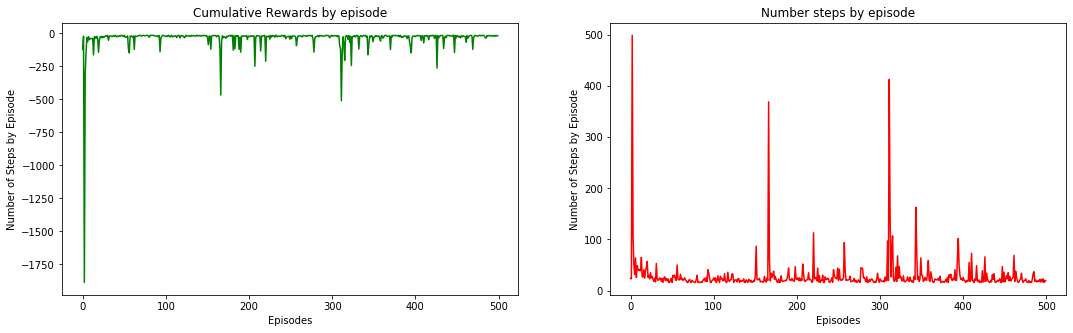

In [25]:
#Gráficas
fig, axs = plt.subplots(1, 2, figsize=(18, 5), sharey=False)
axs[0].plot(sum_reward, color='g')
axs[0].set_xlabel('Episodes')
axs[0].set_ylabel('Number of Steps by Episode')
axs[0].set_title('Cumulative Rewards by episode')
axs[1].plot(episode_steps, color='r')
axs[1].set_xlabel('Episodes')
axs[1].set_ylabel('Number of Steps by Episode')
axs[1].set_title('Number steps by episode')
plt.show()

In [26]:
max_steps = 20
play_game(Q, max_steps, time_visual=0.01)

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

Exploto [ -12.97499787 -114.68922306  -54.56197815  -25.18885926]
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-12.162157   -30.24407795 -31.12177572 -15.75537139]
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-11.54537773 -22.27581259 -27.17519398 -16.18597403]
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-16.71760628 -10.8477306  -14.9788128  -16.8632595 ]
o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

Exploto [-14.58520634  -9.80211513 -14.3374

## Observaciones:

Se puede ver que tanto Q-learning como SARSA logran que el robot aprenda llegar al punto de salida, sin embargo, es notoria las diferencias de las políticas aprendidas.

Mientras que Q-learning toma el menor número de pasos (la ruta óptima), en SARSA se puede decir que el robot aprendió la ruta más segura, dado que se aleja del risco. Esto se debe a que SARSA mira la siguiente acción que debería tomar el robot para actualizar la Q-table de su estado actual.

## Referencias consultadas

https://medium.com/analytics-vidhya/nuts-and-bolts-of-reinforcement-learning-introduction-to-temporal-difference-td-learning-a0624eb3b985


https://towardsdatascience.com/reinforcement-learning-rl-101-with-python-e1aa0d37d43b


https://towardsdatascience.com/reinforcement-learning-temporal-difference-sarsa-q-learning-expected-sarsa-on-python-9fecfda7467e


https://www.geeksforgeeks.org/sarsa-reinforcement-learning/


https://www.youtube.com/watch?v=DZzffdHNqtQ


https://towardsdatascience.com/reinforcement-learning-cliff-walking-implementation-e40ce98418d4

https://www.youtube.com/watch?v=w33Lplx49_A
